In [5]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification,TrainingArguments, Trainer
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
from peft import get_peft_model, LoraConfig
import json
import random
import torch
import shap
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math

import re
import torch
#import torch.nn.functional as F
#import torchvision
#from torchvision import models, transforms
#import cv2

## Loading in the data

In [6]:
HEALTH_DATA_PATH = "./data/domain_specific_articles.json"
GENERAL_DATA_PATH = "./data/general_articles.json"

In [7]:
with open(HEALTH_DATA_PATH, "r", encoding = "utf-8") as file:
    data = json.load(file)

In [8]:
len(data)

187

In [9]:
def separate_sugar_diabetes(data):
    domain_count = 0
    domain_specific_articles = []
    for dt in data:
        if "umdlavuza" in dt["content"] or "Umdlavuza" in dt["content"] or "cancer" in dt["content"]  or "Cancer" in dt["content"]:
            domain_count += 1
            domain_specific_articles.append(dt)
            data.remove(dt)
    print(domain_count)
    return data, domain_specific_articles
#data, domain_specific_articles = separate_sugar_diabetes(data)

In [11]:
#domain_specific_articles

In [12]:
# counting the number of covid 19 articles in the data
domain_count = 0
for dt in data:
    if "covid-19" in dt['content'] or "corona" in dt['content'] or "covid" in dt['content']  or "covid" in  dt['content'] or "Covid-19" in  dt['content']:
        domain_count += 1
print(domain_count)
        

72


In [13]:
health_data = data

In [14]:
def label_data(data_source, label):
    for dt in data_source:
        dt["label"] = label
    return data_source
data = label_data(health_data, 1)

In [15]:
health_data[0]

{'content': 'UKUBA nomuzwa wokuphila kahle, ukuthula nokukhululeka emoyeni, ngezinye zezinto eseziseqhulwini lezivakashi uma zihlela amaholidi nezindawo ezizozihambela.Yikho lokhu okwenza ukuthi sande isitayela sokuthi izivakashi uma zibheka izindawo ezizovakashela kuzo, ziqikelele ukuthi zinaso iSpa noma sisondelene yini naleyo ndawo.Izindawo eziningi zokuvakasha sezidlisa ngazo izindawo zokubhucunga nokwelapha umzimba.Sikuhlanganisele uhlu lwezindawo ezinhlanu ezineSpa esihamba phambili, okumele uhlele ukuzivakashela maduze.1. Brahman Hills Spa and Healing EarthSiyiklelise eqhulwini ngenhloso le ndawo njengoba nozokuthola kuyo kusezingeni eliphezulu.Uphuma uwuzwa umehluko hhayi emzimbeni kuphela kepha nasemoyeni uma uqeda ukubhucungwa nezinye izinto ezenziwa kulesi Spa njengeFacial, Yoga, iBody Detox neBody Polish.Kulesi Spa kunanechibi elinamanzi afudumele anezithako ezenza umzimba unethezeke. Ukuba sendaweni enokuthula nakho kukodwa kukunika umuzwa opholile.Lesi Spa singaphakathi e

In [16]:
len(health_data)

187

In [17]:
with open(GENERAL_DATA_PATH, "r", encoding = "utf-8") as file:
    general_data = json.load(file)

In [18]:
general_data = label_data(general_data, 0)

In [19]:
len(general_data)

1870

In [20]:
#general_data = random.shuffle(general_data)

In [21]:
def combine_data(general_data, health_data):
    train_data = general_data
    train_data.extend(health_data)
    return train_data

train_data = combine_data(general_data, health_data)

In [22]:
len(train_data)

2057

In [23]:
train_data[0]

{'content': 'UCWANINGO lwenkampani ebolekisa ngemali, iWonga, luveza ukuthi abantu baseNingizimu Afrika sebenciphise imali yokuthenga igilosa ukuze bakwazi ukukhokhela i-medical aid, umshwalense nezokuphepha emizini yabo njengoba izinga lempilo liqombola.Ucwaningo lwenziwe kubantu abawu-4 500 abaneminyaka engaphezu kuka-18.Kuvele ukuthi bayahluleka ukukhokhela ama-credit card nezinye izikweletu. Lokhu kusho ukuthi abakwazi ukonga imali nokongela umhlalaphansi.UMnuz James Williams oyinhloko yezokukhangisa eWonga, uthe inhloso yocwaningo lwabo wukuthola ukuthi abantu baphila kanjani njengoba impilo ibiza.“Njengoba impilo ibiza, abantu abasenayo imali yokwenza izidingo zabo. Bayaphoqeleka ukuthi babophe izifociya,” kusho uWilliams.Abantu okukhulunywe nabo kulolu cwaningo u-41% wabantu bahola phakathi kuka-R10 000 no-R25 000 ngenyanga.Kuthiwa bathwele kanzima njengoba besebenzisa u-80% womholo wabo ukukhokhela imizi noma irenti kanti abahola kangconywana basebenzisa u-24% womholo wabo ukwe

## Tokenization step

In [24]:
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

In [25]:
#custom dataloader
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the content and label from the data
        content = self.data[idx]['content']
        label = self.data[idx]['label']
        
        # Tokenize the input text
        encoding = self.tokenizer(
            content,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'  # Return PyTorch tensors
        )
        
        # Return tokenized input and label
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)  # Convert label to tensor
        }

In [342]:
def split_data(train_data, duplicate = False, duplicate_n_times = 0, test_size = 0.2, test_size_2 = 0.5):
    train, temp = train_test_split(train_data, test_size=test_size, random_state=42)
    validation, test = train_test_split(temp, test_size = test_size_2, random_state = 42)
    if duplicate:
        train = create_duplicates(train, duplicate_n_times)
    return train,validation, test

def tokenize(tokenizer):
    train, validation,test= split_data(train_data)
    train_set = CustomDataset(train, tokenizer)
    validation_set =CustomDataset(validation, tokenizer)
    test_set = CustomDataset(test, tokenizer)
    return train_set,validation_set, test_set



In [27]:
train_set, validation_set, test_set = tokenize(tokenizer)

In [28]:
len(train_set)

1645

In [29]:
len(test_set)

206

In [30]:
def check_data_distribution(dataset):
    labels = [item['label'] for item in dataset]
    unique, counts = np.unique(labels, return_counts=True)
    print("Label distribution:")
    for label, count in zip(unique, counts):
        print(f"Label {label}: {count} ({count/len(labels)*100:.2f}%)")

train, validation,test= split_data(train_data)
print("Train set:")
check_data_distribution(train)
print("\nValidation set:")
check_data_distribution(validation)
print("\nTest set:")
check_data_distribution(test)

Train set:
Label distribution:
Label 0: 1498 (91.06%)
Label 1: 147 (8.94%)

Validation set:
Label distribution:
Label 0: 185 (89.81%)
Label 1: 21 (10.19%)

Test set:
Label distribution:
Label 0: 187 (90.78%)
Label 1: 19 (9.22%)


In [31]:
# Ignore
"""def tokenize_data(data):
    tokenized_articles = []
    for article in data:
        tokenized_article = tokenizer(
            article['content'],
            padding='max_length',
            truncation=True,
            max_length=512
        )
        #tokenized_article['label'] = article['label'] 
        tokenized_articles.append(tokenized_article)
    return tokenized_articles

#test_set = tokenize_data(test)"""

"def tokenize_data(data):\n    tokenized_articles = []\n    for article in data:\n        tokenized_article = tokenizer(\n            article['content'],\n            padding='max_length',\n            truncation=True,\n            max_length=512\n        )\n        #tokenized_article['label'] = article['label'] \n        tokenized_articles.append(tokenized_article)\n    return tokenized_articles\n\n#test_set = tokenize_data(test)"

In [32]:
len(train_set)

1645

In [33]:
train_set[0]

{'input_ids': tensor([     0,  59584,  32462,  24592,    186,  17457,    143,   3616,   3719,
          20236,     10, 125441,   1021,  45511,      6,  86392,   2726,   8805,
          14612, 125470,  10627,   9132, 130400,   2471,   2943,    497,  15904,
          15855,    372,      6,  82497,  22188, 123916,   7022,  51642,  45793,
            286,    127,   8736,     31,    259,   7404,  19165,  35251,    156,
              9, 139701,    180,    238,  14051, 110517,     17,  11866,  46526,
           1314,    111,   2907,  14245,   1061,   2465,   2481,      4,  22951,
            172,    919,   6990,   5871,  48546,  39036,     57,    184,   3957,
             92,  86519,      5,  15363,  47119,  16646,  25609,    350,  22188,
         123916,     95,    150,   8753,    143,  13315,  16432,     13, 166722,
           2422, 231036,  73911,  21463,  11440,   7316,  20133,    143,  85068,
         213948,     22,   1234,  11033,    760,  77524,    202,    634,    459,
          32457

## Configuring LoRa

In [35]:
target_modules = [
    "query",
    "key",
    "value",
]

lora_config = LoraConfig(
    r=100,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
    target_modules=target_modules,
    modules_to_save=None
)


model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)


trainable_params_before = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params_before = sum(p.numel() for p in model.parameters())
print(f"Trainable params before LoRA: {trainable_params_before:,}")
print(f"Total params before LoRA: {total_params_before:,}")


for param in model.parameters():
    param.requires_grad = False


lora_model = get_peft_model(model, lora_config)


trainable_params_after = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
total_params_after = sum(p.numel() for p in lora_model.parameters())
print(f"\nTrainable params after LoRA: {trainable_params_after:,}")
print(f"Total params after LoRA: {total_params_after:,}")


print("\nTrainable layers:")
for name, param in lora_model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel():,} parameters")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params before LoRA: 278,045,186
Total params before LoRA: 278,045,186

Trainable params after LoRA: 6,121,730
Total params after LoRA: 284,166,916

Trainable layers:
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight: 76,800 parameters
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight: 76,800 parameters
base_model.model.roberta.encoder.layer.0.attention.self.key.lora_A.default.weight: 76,800 parameters
base_model.model.roberta.encoder.layer.0.attention.self.key.lora_B.default.weight: 76,800 parameters
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight: 76,800 parameters
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight: 76,800 parameters
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight: 76,800 parameters
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_B.default.weight: 76,800 parameters
base

## TRAINING

#### Train loop one

In [65]:
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.epoch_loss = 0  # Initialize variable to keep track of epoch loss

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Cross entropy with label smoothing
        loss = torch.nn.functional.cross_entropy(
            logits.view(-1, model.config.num_labels),
            labels.view(-1),
            label_smoothing=0.1
        )
        
        self.epoch_loss += loss.item()  # Accumulate loss for the epoch
        
        if self.state.global_step % 10 == 0:  # Log every 10 steps
            print(f"Step {self.state.global_step}, Loss: {loss.item():.4f}")

        return (loss, outputs) if return_outputs else loss

    def on_epoch_end(self):
        # Calculate average epoch loss
        average_epoch_loss = self.epoch_loss / self.state.epoch
        print(f"Epoch {self.state.epoch}, Average Loss: {average_epoch_loss:.4f}")
        self.epoch_loss = 0  # Reset epoch loss for the next epoch


In [88]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",       # Evaluate more frequently
    eval_steps=50,                     # Evaluate every 50 steps
    learning_rate=2e-5,               # Lower learning rate
    per_device_train_batch_size=4,    # Smaller batch size
    per_device_eval_batch_size=4,
    logging_dir='./logs',
    logging_steps=10,
    num_train_epochs=10,
    weight_decay=0.01,                # Add weight decay
    warmup_steps=100,                 # Add warmup
    load_best_model_at_end=True,      # Load best model
    metric_for_best_model="f1",       # Use F1 score
    save_strategy="steps",            # Save checkpoints
    save_steps=50,
    fp16=True if torch.cuda.is_available() else False,  # Mixed precision training
)

# Custom trainer with loss monitoring
"""class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Cross entropy with label smoothing
        loss = torch.nn.functional.cross_entropy(
            logits.view(-1, model.config.num_labels),
            labels.view(-1),
            label_smoothing=0.1
        )
        
        if self.state.global_step % 10 == 0:  # Log every 10 steps
            print(f"Step {self.state.global_step}, Loss: {loss.item():.4f}")
        
        return (loss, outputs) if return_outputs else loss"""

trainer = CustomTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics
)

# Print initial predictions before training
def check_predictions(model, dataset, num_samples=3):
    model.eval()
    for i in range(num_samples):
        inputs = {k: v.unsqueeze(0).to(model.device) for k, v in dataset[i].items() 
                 if k != 'labels'}
        labels = dataset[i]['labels']
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        print(f"\nSample {i+1}:")
        print(f"True label: {labels}")
        print(f"Predicted probabilities: {probs}")

"""print("Initial predictions:")
check_predictions(model, train_set)"""

# Train the model
trainer.train()

# Print final predictions
"""print("\nFinal predictions:")
check_predictions(model, train_set)

# Evaluate on test set
test_results = trainer.evaluate(test_set)
print("\nTest Results:", test_results)"""





/home/mpho/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step 0, Loss: 0.4491


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.508200,0.457163,0.898058,0.849825,0.806509,0.898058
100,0.474700,0.483130,0.898058,0.849825,0.806509,0.898058
150,0.284600,0.431178,0.898058,0.849825,0.806509,0.898058
200,0.414800,0.419257,0.898058,0.849825,0.806509,0.898058
250,0.432000,0.404026,0.898058,0.849825,0.806509,0.898058
300,0.379000,0.423656,0.898058,0.849825,0.806509,0.898058
350,0.369600,0.440020,0.898058,0.849825,0.806509,0.898058
400,0.343500,0.426855,0.898058,0.849825,0.806509,0.898058
450,0.318600,0.428920,0.898058,0.849825,0.806509,0.898058
500,0.477600,0.440817,0.898058,0.849825,0.806509,0.898058


Step 10, Loss: 0.4216
Step 20, Loss: 0.3863
Step 30, Loss: 0.4070
Step 40, Loss: 0.4516
Step 50, Loss: 0.5777
Step 50, Loss: 0.3699
Step 50, Loss: 0.5757
Step 50, Loss: 0.5713
Step 50, Loss: 0.3696
Step 50, Loss: 0.3753
Step 50, Loss: 0.3802
Step 50, Loss: 0.3742
Step 50, Loss: 0.5767
Step 50, Loss: 0.3682
Step 50, Loss: 0.5941
Step 50, Loss: 0.5711
Step 50, Loss: 0.3704
Step 50, Loss: 0.5724
Step 50, Loss: 0.3666
Step 50, Loss: 0.3774
Step 50, Loss: 0.3764
Step 50, Loss: 0.3782
Step 50, Loss: 0.3668
Step 50, Loss: 0.5828
Step 50, Loss: 0.3621
Step 50, Loss: 0.3833
Step 50, Loss: 0.5833
Step 50, Loss: 0.8028
Step 50, Loss: 0.3720
Step 50, Loss: 0.3734
Step 50, Loss: 0.3788
Step 50, Loss: 0.5863
Step 50, Loss: 0.3645
Step 50, Loss: 0.5742
Step 50, Loss: 0.7932
Step 50, Loss: 0.3756
Step 50, Loss: 0.3587
Step 50, Loss: 0.3668
Step 50, Loss: 0.3639
Step 50, Loss: 0.5757
Step 50, Loss: 0.3708
Step 50, Loss: 0.3645
Step 50, Loss: 0.3648
Step 50, Loss: 0.3662
Step 50, Loss: 0.5821
Step 50, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 50, Loss: 0.5699


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 60, Loss: 0.5631
Step 70, Loss: 0.2708
Step 80, Loss: 1.0419
Step 90, Loss: 0.2238
Step 100, Loss: 0.8034
Step 100, Loss: 0.2067
Step 100, Loss: 0.8941
Step 100, Loss: 0.8445
Step 100, Loss: 0.2062
Step 100, Loss: 0.2012
Step 100, Loss: 0.2040
Step 100, Loss: 0.2036
Step 100, Loss: 0.8521
Step 100, Loss: 0.2087
Step 100, Loss: 0.9463
Step 100, Loss: 0.7479
Step 100, Loss: 0.2061
Step 100, Loss: 0.7545
Step 100, Loss: 0.2058
Step 100, Loss: 0.2008
Step 100, Loss: 0.2032
Step 100, Loss: 0.2083
Step 100, Loss: 0.2069
Step 100, Loss: 0.8727
Step 100, Loss: 0.2091
Step 100, Loss: 0.1996
Step 100, Loss: 0.8608
Step 100, Loss: 1.6845
Step 100, Loss: 0.2050
Step 100, Loss: 0.2011
Step 100, Loss: 0.2010
Step 100, Loss: 0.9300
Step 100, Loss: 0.2051
Step 100, Loss: 0.9061
Step 100, Loss: 1.5231
Step 100, Loss: 0.2020
Step 100, Loss: 0.2058
Step 100, Loss: 0.2055
Step 100, Loss: 0.2079
Step 100, Loss: 0.8829
Step 100, Loss: 0.2046
Step 100, Loss: 0.2034
Step 100, Loss: 0.2079
Step 100, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 100, Loss: 0.2052


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 110, Loss: 0.2048
Step 120, Loss: 0.2056
Step 130, Loss: 0.2358
Step 140, Loss: 0.1992
Step 150, Loss: 0.7183
Step 150, Loss: 0.1989
Step 150, Loss: 0.7623
Step 150, Loss: 0.7341
Step 150, Loss: 0.1996
Step 150, Loss: 0.2033
Step 150, Loss: 0.2045
Step 150, Loss: 0.2012
Step 150, Loss: 0.7481
Step 150, Loss: 0.2018
Step 150, Loss: 0.7922
Step 150, Loss: 0.6926
Step 150, Loss: 0.2013
Step 150, Loss: 0.6883
Step 150, Loss: 0.2012
Step 150, Loss: 0.2015
Step 150, Loss: 0.2000
Step 150, Loss: 0.2074
Step 150, Loss: 0.2006
Step 150, Loss: 0.7696
Step 150, Loss: 0.1989
Step 150, Loss: 0.2058
Step 150, Loss: 0.7569
Step 150, Loss: 1.3799
Step 150, Loss: 0.2002
Step 150, Loss: 0.2006
Step 150, Loss: 0.2038
Step 150, Loss: 0.7839
Step 150, Loss: 0.2007
Step 150, Loss: 0.7697
Step 150, Loss: 1.3149
Step 150, Loss: 0.2021
Step 150, Loss: 0.2001
Step 150, Loss: 0.1993
Step 150, Loss: 0.1996
Step 150, Loss: 0.7663
Step 150, Loss: 0.2004
Step 150, Loss: 0.2001
Step 150, Loss: 0.1987
Step 150, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 150, Loss: 0.8594


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 160, Loss: 0.2070
Step 170, Loss: 0.2045
Step 180, Loss: 0.6934
Step 190, Loss: 0.2196
Step 200, Loss: 0.6947
Step 200, Loss: 0.2010
Step 200, Loss: 0.7266
Step 200, Loss: 0.7029
Step 200, Loss: 0.2020
Step 200, Loss: 0.2069
Step 200, Loss: 0.2066
Step 200, Loss: 0.2043
Step 200, Loss: 0.7195
Step 200, Loss: 0.2031
Step 200, Loss: 0.7523
Step 200, Loss: 0.6804
Step 200, Loss: 0.2032
Step 200, Loss: 0.6736
Step 200, Loss: 0.2030
Step 200, Loss: 0.2056
Step 200, Loss: 0.2026
Step 200, Loss: 0.2095
Step 200, Loss: 0.2024
Step 200, Loss: 0.7461
Step 200, Loss: 0.1998
Step 200, Loss: 0.2097
Step 200, Loss: 0.7266
Step 200, Loss: 1.2939
Step 200, Loss: 0.2022
Step 200, Loss: 0.2038
Step 200, Loss: 0.2073
Step 200, Loss: 0.7414
Step 200, Loss: 0.2029
Step 200, Loss: 0.7291
Step 200, Loss: 1.2507
Step 200, Loss: 0.2051
Step 200, Loss: 0.2019
Step 200, Loss: 0.2018
Step 200, Loss: 0.2009
Step 200, Loss: 0.7370
Step 200, Loss: 0.2032
Step 200, Loss: 0.2024
Step 200, Loss: 0.2004
Step 200, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 200, Loss: 0.2022


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 210, Loss: 0.2270
Step 220, Loss: 0.2001
Step 230, Loss: 0.7269
Step 240, Loss: 0.8225
Step 250, Loss: 0.6543
Step 250, Loss: 0.2128
Step 250, Loss: 0.6774
Step 250, Loss: 0.6540
Step 250, Loss: 0.2135
Step 250, Loss: 0.2199
Step 250, Loss: 0.2178
Step 250, Loss: 0.2160
Step 250, Loss: 0.6781
Step 250, Loss: 0.2125
Step 250, Loss: 0.6907
Step 250, Loss: 0.6474
Step 250, Loss: 0.2144
Step 250, Loss: 0.6374
Step 250, Loss: 0.2130
Step 250, Loss: 0.2184
Step 250, Loss: 0.2136
Step 250, Loss: 0.2206
Step 250, Loss: 0.2134
Step 250, Loss: 0.6895
Step 250, Loss: 0.2108
Step 250, Loss: 0.2219
Step 250, Loss: 0.6806
Step 250, Loss: 1.1586
Step 250, Loss: 0.2130
Step 250, Loss: 0.2152
Step 250, Loss: 0.2204
Step 250, Loss: 0.6805
Step 250, Loss: 0.2123
Step 250, Loss: 0.6769
Step 250, Loss: 1.1464
Step 250, Loss: 0.2167
Step 250, Loss: 0.2113
Step 250, Loss: 0.2128
Step 250, Loss: 0.2115
Step 250, Loss: 0.6880
Step 250, Loss: 0.2138
Step 250, Loss: 0.2132
Step 250, Loss: 0.2118
Step 250, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 250, Loss: 0.6856


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 260, Loss: 0.7322
Step 270, Loss: 0.2421
Step 280, Loss: 0.2299
Step 290, Loss: 0.8448
Step 300, Loss: 0.7135
Step 300, Loss: 0.2005
Step 300, Loss: 0.7463
Step 300, Loss: 0.7152
Step 300, Loss: 0.2011
Step 300, Loss: 0.2041
Step 300, Loss: 0.2035
Step 300, Loss: 0.2020
Step 300, Loss: 0.7480
Step 300, Loss: 0.2009
Step 300, Loss: 0.7601
Step 300, Loss: 0.7025
Step 300, Loss: 0.2017
Step 300, Loss: 0.6915
Step 300, Loss: 0.2012
Step 300, Loss: 0.2031
Step 300, Loss: 0.2006
Step 300, Loss: 0.2058
Step 300, Loss: 0.2014
Step 300, Loss: 0.7610
Step 300, Loss: 0.2000
Step 300, Loss: 0.2051
Step 300, Loss: 0.7476
Step 300, Loss: 1.3097
Step 300, Loss: 0.2007
Step 300, Loss: 0.2016
Step 300, Loss: 0.2042
Step 300, Loss: 0.7439
Step 300, Loss: 0.2011
Step 300, Loss: 0.7497
Step 300, Loss: 1.2952
Step 300, Loss: 0.2024
Step 300, Loss: 0.2005
Step 300, Loss: 0.2006
Step 300, Loss: 0.2002
Step 300, Loss: 0.7620
Step 300, Loss: 0.2011
Step 300, Loss: 0.2007
Step 300, Loss: 0.2003
Step 300, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 300, Loss: 0.2157


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 310, Loss: 0.2001
Step 320, Loss: 1.3151
Step 330, Loss: 0.6933
Step 340, Loss: 0.2138
Step 350, Loss: 0.7554
Step 350, Loss: 0.1989
Step 350, Loss: 0.7946
Step 350, Loss: 0.7576
Step 350, Loss: 0.1990
Step 350, Loss: 0.2001
Step 350, Loss: 0.2001
Step 350, Loss: 0.1991
Step 350, Loss: 0.8031
Step 350, Loss: 0.1990
Step 350, Loss: 0.7991
Step 350, Loss: 0.7477
Step 350, Loss: 0.1994
Step 350, Loss: 0.7349
Step 350, Loss: 0.1991
Step 350, Loss: 0.1995
Step 350, Loss: 0.1987
Step 350, Loss: 0.2013
Step 350, Loss: 0.1993
Step 350, Loss: 0.8041
Step 350, Loss: 0.1990
Step 350, Loss: 0.2001
Step 350, Loss: 0.7971
Step 350, Loss: 1.3961
Step 350, Loss: 0.1988
Step 350, Loss: 0.1990
Step 350, Loss: 0.2002
Step 350, Loss: 0.7821
Step 350, Loss: 0.1991
Step 350, Loss: 0.7974
Step 350, Loss: 1.3952
Step 350, Loss: 0.1993
Step 350, Loss: 0.1990
Step 350, Loss: 0.1988
Step 350, Loss: 0.1989
Step 350, Loss: 0.8152
Step 350, Loss: 0.1989
Step 350, Loss: 0.1990
Step 350, Loss: 0.1989
Step 350, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 350, Loss: 0.7126


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 360, Loss: 0.2223
Step 370, Loss: 0.8375
Step 380, Loss: 0.9338
Step 390, Loss: 0.2046
Step 400, Loss: 0.7274
Step 400, Loss: 0.2019
Step 400, Loss: 0.7594
Step 400, Loss: 0.7246
Step 400, Loss: 0.2018
Step 400, Loss: 0.2033
Step 400, Loss: 0.2026
Step 400, Loss: 0.2017
Step 400, Loss: 0.7733
Step 400, Loss: 0.2007
Step 400, Loss: 0.7563
Step 400, Loss: 0.7291
Step 400, Loss: 0.2023
Step 400, Loss: 0.7144
Step 400, Loss: 0.2010
Step 400, Loss: 0.2027
Step 400, Loss: 0.2010
Step 400, Loss: 0.2039
Step 400, Loss: 0.2018
Step 400, Loss: 0.7629
Step 400, Loss: 0.2019
Step 400, Loss: 0.2029
Step 400, Loss: 0.7617
Step 400, Loss: 1.3153
Step 400, Loss: 0.2013
Step 400, Loss: 0.2015
Step 400, Loss: 0.2034
Step 400, Loss: 0.7417
Step 400, Loss: 0.2014
Step 400, Loss: 0.7585
Step 400, Loss: 1.3233
Step 400, Loss: 0.2019
Step 400, Loss: 0.2015
Step 400, Loss: 0.2012
Step 400, Loss: 0.2012
Step 400, Loss: 0.7785
Step 400, Loss: 0.2010
Step 400, Loss: 0.2016
Step 400, Loss: 0.2016
Step 400, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 400, Loss: 0.2829


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 410, Loss: 0.2015
Step 420, Loss: 0.8523
Step 430, Loss: 0.1990
Step 440, Loss: 0.2051
Step 450, Loss: 0.7307
Step 450, Loss: 0.2007
Step 450, Loss: 0.7635
Step 450, Loss: 0.7285
Step 450, Loss: 0.2008
Step 450, Loss: 0.2024
Step 450, Loss: 0.2018
Step 450, Loss: 0.2009
Step 450, Loss: 0.7767
Step 450, Loss: 0.1999
Step 450, Loss: 0.7652
Step 450, Loss: 0.7320
Step 450, Loss: 0.2012
Step 450, Loss: 0.7170
Step 450, Loss: 0.2002
Step 450, Loss: 0.2019
Step 450, Loss: 0.2001
Step 450, Loss: 0.2032
Step 450, Loss: 0.2008
Step 450, Loss: 0.7717
Step 450, Loss: 0.2005
Step 450, Loss: 0.2024
Step 450, Loss: 0.7663
Step 450, Loss: 1.3322
Step 450, Loss: 0.2004
Step 450, Loss: 0.2008
Step 450, Loss: 0.2025
Step 450, Loss: 0.7487
Step 450, Loss: 0.2005
Step 450, Loss: 0.7640
Step 450, Loss: 1.3340
Step 450, Loss: 0.2011
Step 450, Loss: 0.2003
Step 450, Loss: 0.2003
Step 450, Loss: 0.2001
Step 450, Loss: 0.7843
Step 450, Loss: 0.2002
Step 450, Loss: 0.2004
Step 450, Loss: 0.2005
Step 450, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 450, Loss: 0.1994


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 460, Loss: 0.2124
Step 470, Loss: 0.1994
Step 480, Loss: 0.2704
Step 490, Loss: 0.1987
Step 500, Loss: 0.7647
Step 500, Loss: 0.1993
Step 500, Loss: 0.7969
Step 500, Loss: 0.7605
Step 500, Loss: 0.1992
Step 500, Loss: 0.1999
Step 500, Loss: 0.1997
Step 500, Loss: 0.1992
Step 500, Loss: 0.8157
Step 500, Loss: 0.1988
Step 500, Loss: 0.7946
Step 500, Loss: 0.7689
Step 500, Loss: 0.1995
Step 500, Loss: 0.7533
Step 500, Loss: 0.1990
Step 500, Loss: 0.1997
Step 500, Loss: 0.1988
Step 500, Loss: 0.2003
Step 500, Loss: 0.1992
Step 500, Loss: 0.8018
Step 500, Loss: 0.1992
Step 500, Loss: 0.1997
Step 500, Loss: 0.7985
Step 500, Loss: 1.3938
Step 500, Loss: 0.1990
Step 500, Loss: 0.1991
Step 500, Loss: 0.2000
Step 500, Loss: 0.7771
Step 500, Loss: 0.1992
Step 500, Loss: 0.7965
Step 500, Loss: 1.4016
Step 500, Loss: 0.1993
Step 500, Loss: 0.1990
Step 500, Loss: 0.1989
Step 500, Loss: 0.1990
Step 500, Loss: 0.8198
Step 500, Loss: 0.1989
Step 500, Loss: 0.1992
Step 500, Loss: 0.1992
Step 500, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 500, Loss: 0.2014


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 510, Loss: 0.2065
Step 520, Loss: 0.2080
Step 530, Loss: 0.8052
Step 540, Loss: 0.7801
Step 550, Loss: 0.7555
Step 550, Loss: 0.1993
Step 550, Loss: 0.7875
Step 550, Loss: 0.7509
Step 550, Loss: 0.1993
Step 550, Loss: 0.2002
Step 550, Loss: 0.1999
Step 550, Loss: 0.1993
Step 550, Loss: 0.8067
Step 550, Loss: 0.1988
Step 550, Loss: 0.7892
Step 550, Loss: 0.7582
Step 550, Loss: 0.1997
Step 550, Loss: 0.7431
Step 550, Loss: 0.1991
Step 550, Loss: 0.2000
Step 550, Loss: 0.1989
Step 550, Loss: 0.2008
Step 550, Loss: 0.1994
Step 550, Loss: 0.7939
Step 550, Loss: 0.1992
Step 550, Loss: 0.2001
Step 550, Loss: 0.7909
Step 550, Loss: 1.3788
Step 550, Loss: 0.1991
Step 550, Loss: 0.1992
Step 550, Loss: 0.2003
Step 550, Loss: 0.7682
Step 550, Loss: 0.1993
Step 550, Loss: 0.7899
Step 550, Loss: 1.3865
Step 550, Loss: 0.1995
Step 550, Loss: 0.1991
Step 550, Loss: 0.1990
Step 550, Loss: 0.1990
Step 550, Loss: 0.8140
Step 550, Loss: 0.1990
Step 550, Loss: 0.1992
Step 550, Loss: 0.1993
Step 550, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 550, Loss: 0.2000


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 560, Loss: 0.2008
Step 570, Loss: 0.2047
Step 580, Loss: 0.2037
Step 590, Loss: 0.5912
Step 600, Loss: 0.7021
Step 600, Loss: 0.2054
Step 600, Loss: 0.7297
Step 600, Loss: 0.6957
Step 600, Loss: 0.2052
Step 600, Loss: 0.2072
Step 600, Loss: 0.2056
Step 600, Loss: 0.2049
Step 600, Loss: 0.7457
Step 600, Loss: 0.2030
Step 600, Loss: 0.7272
Step 600, Loss: 0.7093
Step 600, Loss: 0.2058
Step 600, Loss: 0.6937
Step 600, Loss: 0.2035
Step 600, Loss: 0.2065
Step 600, Loss: 0.2037
Step 600, Loss: 0.2072
Step 600, Loss: 0.2047
Step 600, Loss: 0.7342
Step 600, Loss: 0.2052
Step 600, Loss: 0.2064
Step 600, Loss: 0.7338
Step 600, Loss: 1.2479
Step 600, Loss: 0.2042
Step 600, Loss: 0.2047
Step 600, Loss: 0.2072
Step 600, Loss: 0.7105
Step 600, Loss: 0.2042
Step 600, Loss: 0.7269
Step 600, Loss: 1.2609
Step 600, Loss: 0.2052
Step 600, Loss: 0.2044
Step 600, Loss: 0.2042
Step 600, Loss: 0.2041
Step 600, Loss: 0.7537
Step 600, Loss: 0.2035
Step 600, Loss: 0.2049
Step 600, Loss: 0.2050
Step 600, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 600, Loss: 0.7725


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 610, Loss: 0.2263
Step 620, Loss: 0.2285
Step 630, Loss: 0.1989
Step 640, Loss: 0.8407
Step 650, Loss: 0.7678
Step 650, Loss: 0.1985
Step 650, Loss: 0.8051
Step 650, Loss: 0.7654
Step 650, Loss: 0.1988
Step 650, Loss: 0.1992
Step 650, Loss: 0.1992
Step 650, Loss: 0.1987
Step 650, Loss: 0.8215
Step 650, Loss: 0.1990
Step 650, Loss: 0.8120
Step 650, Loss: 0.7696
Step 650, Loss: 0.1990
Step 650, Loss: 0.7519
Step 650, Loss: 0.1992
Step 650, Loss: 0.1990
Step 650, Loss: 0.1986
Step 650, Loss: 0.2003
Step 650, Loss: 0.1991
Step 650, Loss: 0.8197
Step 650, Loss: 0.1987
Step 650, Loss: 0.1992
Step 650, Loss: 0.8121
Step 650, Loss: 1.4194
Step 650, Loss: 0.1986
Step 650, Loss: 0.1987
Step 650, Loss: 0.1992
Step 650, Loss: 0.7874
Step 650, Loss: 0.1993
Step 650, Loss: 0.8102
Step 650, Loss: 1.4240
Step 650, Loss: 0.1988
Step 650, Loss: 0.1989
Step 650, Loss: 0.1986
Step 650, Loss: 0.1988
Step 650, Loss: 0.8364
Step 650, Loss: 0.1990
Step 650, Loss: 0.1987
Step 650, Loss: 0.1987
Step 650, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 650, Loss: 0.8524


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 660, Loss: 0.1998
Step 670, Loss: 0.9107
Step 680, Loss: 0.5957
Step 690, Loss: 0.1993
Step 700, Loss: 0.7180
Step 700, Loss: 0.2017
Step 700, Loss: 0.7460
Step 700, Loss: 0.7128
Step 700, Loss: 0.2019
Step 700, Loss: 0.2037
Step 700, Loss: 0.2024
Step 700, Loss: 0.2018
Step 700, Loss: 0.7618
Step 700, Loss: 0.2005
Step 700, Loss: 0.7507
Step 700, Loss: 0.7221
Step 700, Loss: 0.2022
Step 700, Loss: 0.7063
Step 700, Loss: 0.2009
Step 700, Loss: 0.2032
Step 700, Loss: 0.2008
Step 700, Loss: 0.2041
Step 700, Loss: 0.2017
Step 700, Loss: 0.7592
Step 700, Loss: 0.2014
Step 700, Loss: 0.2035
Step 700, Loss: 0.7535
Step 700, Loss: 1.2914
Step 700, Loss: 0.2010
Step 700, Loss: 0.2018
Step 700, Loss: 0.2036
Step 700, Loss: 0.7309
Step 700, Loss: 0.2013
Step 700, Loss: 0.7459
Step 700, Loss: 1.3028
Step 700, Loss: 0.2021
Step 700, Loss: 0.2010
Step 700, Loss: 0.2012
Step 700, Loss: 0.2009
Step 700, Loss: 0.7732
Step 700, Loss: 0.2010
Step 700, Loss: 0.2016
Step 700, Loss: 0.2015
Step 700, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 700, Loss: 0.7633


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 710, Loss: 0.2295
Step 720, Loss: 0.5610
Step 730, Loss: 0.2053
Step 740, Loss: 0.2125
Step 750, Loss: 0.6810
Step 750, Loss: 0.2089
Step 750, Loss: 0.6994
Step 750, Loss: 0.6738
Step 750, Loss: 0.2094
Step 750, Loss: 0.2119
Step 750, Loss: 0.2095
Step 750, Loss: 0.2096
Step 750, Loss: 0.7092
Step 750, Loss: 0.2070
Step 750, Loss: 0.7041
Step 750, Loss: 0.6852
Step 750, Loss: 0.2091
Step 750, Loss: 0.6723
Step 750, Loss: 0.2070
Step 750, Loss: 0.2115
Step 750, Loss: 0.2078
Step 750, Loss: 0.2117
Step 750, Loss: 0.2086
Step 750, Loss: 0.7156
Step 750, Loss: 0.2078
Step 750, Loss: 0.2121
Step 750, Loss: 0.7086
Step 750, Loss: 1.1907
Step 750, Loss: 0.2078
Step 750, Loss: 0.2094
Step 750, Loss: 0.2120
Step 750, Loss: 0.6905
Step 750, Loss: 0.2074
Step 750, Loss: 0.6951
Step 750, Loss: 1.2009
Step 750, Loss: 0.2096
Step 750, Loss: 0.2070
Step 750, Loss: 0.2082
Step 750, Loss: 0.2071
Step 750, Loss: 0.7219
Step 750, Loss: 0.2083
Step 750, Loss: 0.2089
Step 750, Loss: 0.2082
Step 750, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 750, Loss: 0.2060


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 760, Loss: 0.7267
Step 770, Loss: 0.2052
Step 780, Loss: 0.2136
Step 790, Loss: 0.2655
Step 800, Loss: 0.7451
Step 800, Loss: 0.1990
Step 800, Loss: 0.7752
Step 800, Loss: 0.7399
Step 800, Loss: 0.1993
Step 800, Loss: 0.2002
Step 800, Loss: 0.1995
Step 800, Loss: 0.1992
Step 800, Loss: 0.7920
Step 800, Loss: 0.1989
Step 800, Loss: 0.7819
Step 800, Loss: 0.7503
Step 800, Loss: 0.1995
Step 800, Loss: 0.7333
Step 800, Loss: 0.1993
Step 800, Loss: 0.2000
Step 800, Loss: 0.1987
Step 800, Loss: 0.2013
Step 800, Loss: 0.1995
Step 800, Loss: 0.7997
Step 800, Loss: 0.1989
Step 800, Loss: 0.2003
Step 800, Loss: 0.7893
Step 800, Loss: 1.3535
Step 800, Loss: 0.1988
Step 800, Loss: 0.1992
Step 800, Loss: 0.2002
Step 800, Loss: 0.7585
Step 800, Loss: 0.1994
Step 800, Loss: 0.7755
Step 800, Loss: 1.3690
Step 800, Loss: 0.1993
Step 800, Loss: 0.1989
Step 800, Loss: 0.1990
Step 800, Loss: 0.1989
Step 800, Loss: 0.8123
Step 800, Loss: 0.1990
Step 800, Loss: 0.1992
Step 800, Loss: 0.1991
Step 800, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 800, Loss: 0.2020


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 810, Loss: 0.2062
Step 820, Loss: 0.1986
Step 830, Loss: 0.6543
Step 840, Loss: 0.2056
Step 850, Loss: 0.6937
Step 850, Loss: 0.2066
Step 850, Loss: 0.7176
Step 850, Loss: 0.6842
Step 850, Loss: 0.2065
Step 850, Loss: 0.2084
Step 850, Loss: 0.2058
Step 850, Loss: 0.2058
Step 850, Loss: 0.7325
Step 850, Loss: 0.2037
Step 850, Loss: 0.7139
Step 850, Loss: 0.7032
Step 850, Loss: 0.2067
Step 850, Loss: 0.6873
Step 850, Loss: 0.2039
Step 850, Loss: 0.2077
Step 850, Loss: 0.2043
Step 850, Loss: 0.2081
Step 850, Loss: 0.2058
Step 850, Loss: 0.7276
Step 850, Loss: 0.2062
Step 850, Loss: 0.2074
Step 850, Loss: 0.7259
Step 850, Loss: 1.2168
Step 850, Loss: 0.2049
Step 850, Loss: 0.2058
Step 850, Loss: 0.2083
Step 850, Loss: 0.6954
Step 850, Loss: 0.2049
Step 850, Loss: 0.7108
Step 850, Loss: 1.2389
Step 850, Loss: 0.2059
Step 850, Loss: 0.2051
Step 850, Loss: 0.2052
Step 850, Loss: 0.2049
Step 850, Loss: 0.7464
Step 850, Loss: 0.2042
Step 850, Loss: 0.2065
Step 850, Loss: 0.2061
Step 850, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 850, Loss: 0.7529


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 860, Loss: 0.2101
Step 870, Loss: 0.1995
Step 880, Loss: 0.2206
Step 890, Loss: 0.2097
Step 900, Loss: 0.7528
Step 900, Loss: 0.1987
Step 900, Loss: 0.7844
Step 900, Loss: 0.7448
Step 900, Loss: 0.1990
Step 900, Loss: 0.1996
Step 900, Loss: 0.1991
Step 900, Loss: 0.1989
Step 900, Loss: 0.8030
Step 900, Loss: 0.1989
Step 900, Loss: 0.7877
Step 900, Loss: 0.7613
Step 900, Loss: 0.1991
Step 900, Loss: 0.7424
Step 900, Loss: 0.1993
Step 900, Loss: 0.1995
Step 900, Loss: 0.1986
Step 900, Loss: 0.2007
Step 900, Loss: 0.1992
Step 900, Loss: 0.8091
Step 900, Loss: 0.1988
Step 900, Loss: 0.1997
Step 900, Loss: 0.7989
Step 900, Loss: 1.3650
Step 900, Loss: 0.1986
Step 900, Loss: 0.1989
Step 900, Loss: 0.1996
Step 900, Loss: 0.7625
Step 900, Loss: 0.1993
Step 900, Loss: 0.7835
Step 900, Loss: 1.3888
Step 900, Loss: 0.1990
Step 900, Loss: 0.1988
Step 900, Loss: 0.1987
Step 900, Loss: 0.1988
Step 900, Loss: 0.8252
Step 900, Loss: 0.1990
Step 900, Loss: 0.1991
Step 900, Loss: 0.1991
Step 900, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 900, Loss: 0.2006


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 910, Loss: 0.7847
Step 920, Loss: 0.2055
Step 930, Loss: 0.2103
Step 940, Loss: 0.7439
Step 950, Loss: 0.6958
Step 950, Loss: 0.2044
Step 950, Loss: 0.7179
Step 950, Loss: 0.6869
Step 950, Loss: 0.2047
Step 950, Loss: 0.2070
Step 950, Loss: 0.2044
Step 950, Loss: 0.2045
Step 950, Loss: 0.7322
Step 950, Loss: 0.2025
Step 950, Loss: 0.7203
Step 950, Loss: 0.7029
Step 950, Loss: 0.2047
Step 950, Loss: 0.6878
Step 950, Loss: 0.2027
Step 950, Loss: 0.2065
Step 950, Loss: 0.2027
Step 950, Loss: 0.2069
Step 950, Loss: 0.2044
Step 950, Loss: 0.7377
Step 950, Loss: 0.2039
Step 950, Loss: 0.2068
Step 950, Loss: 0.7308
Step 950, Loss: 1.2253
Step 950, Loss: 0.2032
Step 950, Loss: 0.2047
Step 950, Loss: 0.2068
Step 950, Loss: 0.7020
Step 950, Loss: 0.2034
Step 950, Loss: 0.7156
Step 950, Loss: 1.2468
Step 950, Loss: 0.2046
Step 950, Loss: 0.2029
Step 950, Loss: 0.2038
Step 950, Loss: 0.2030
Step 950, Loss: 0.7506
Step 950, Loss: 0.2029
Step 950, Loss: 0.2047
Step 950, Loss: 0.2042
Step 950, L

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 950, Loss: 0.2618


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 960, Loss: 0.2020
Step 970, Loss: 0.2131
Step 980, Loss: 0.2122
Step 990, Loss: 0.1989
Step 1000, Loss: 0.7374
Step 1000, Loss: 0.1992
Step 1000, Loss: 0.7695
Step 1000, Loss: 0.7273
Step 1000, Loss: 0.1994
Step 1000, Loss: 0.2004
Step 1000, Loss: 0.1993
Step 1000, Loss: 0.1992
Step 1000, Loss: 0.7933
Step 1000, Loss: 0.1989
Step 1000, Loss: 0.7705
Step 1000, Loss: 0.7485
Step 1000, Loss: 0.1996
Step 1000, Loss: 0.7281
Step 1000, Loss: 0.1993
Step 1000, Loss: 0.2001
Step 1000, Loss: 0.1987
Step 1000, Loss: 0.2012
Step 1000, Loss: 0.1996
Step 1000, Loss: 0.7938
Step 1000, Loss: 0.1992
Step 1000, Loss: 0.2002
Step 1000, Loss: 0.7872
Step 1000, Loss: 1.3287
Step 1000, Loss: 0.1988
Step 1000, Loss: 0.1993
Step 1000, Loss: 0.2002
Step 1000, Loss: 0.7416
Step 1000, Loss: 0.1994
Step 1000, Loss: 0.7694
Step 1000, Loss: 1.3619
Step 1000, Loss: 0.1994
Step 1000, Loss: 0.1989
Step 1000, Loss: 0.1990
Step 1000, Loss: 0.1990
Step 1000, Loss: 0.8157
Step 1000, Loss: 0.1991
Step 1000, Loss: 0.1

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1000, Loss: 0.1998


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1010, Loss: 0.7863
Step 1020, Loss: 0.2113
Step 1030, Loss: 0.2625
Step 1040, Loss: 0.8091
Step 1050, Loss: 0.7043
Step 1050, Loss: 0.2016
Step 1050, Loss: 0.7311
Step 1050, Loss: 0.6935
Step 1050, Loss: 0.2020
Step 1050, Loss: 0.2040
Step 1050, Loss: 0.2016
Step 1050, Loss: 0.2017
Step 1050, Loss: 0.7510
Step 1050, Loss: 0.2002
Step 1050, Loss: 0.7350
Step 1050, Loss: 0.7137
Step 1050, Loss: 0.2020
Step 1050, Loss: 0.6953
Step 1050, Loss: 0.2006
Step 1050, Loss: 0.2035
Step 1050, Loss: 0.2002
Step 1050, Loss: 0.2043
Step 1050, Loss: 0.2020
Step 1050, Loss: 0.7567
Step 1050, Loss: 0.2014
Step 1050, Loss: 0.2037
Step 1050, Loss: 0.7493
Step 1050, Loss: 1.2521
Step 1050, Loss: 0.2007
Step 1050, Loss: 0.2020
Step 1050, Loss: 0.2036
Step 1050, Loss: 0.7097
Step 1050, Loss: 0.2012
Step 1050, Loss: 0.7311
Step 1050, Loss: 1.2815
Step 1050, Loss: 0.2018
Step 1050, Loss: 0.2006
Step 1050, Loss: 0.2012
Step 1050, Loss: 0.2007
Step 1050, Loss: 0.7741
Step 1050, Loss: 0.2006
Step 1050, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1050, Loss: 0.1993


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1060, Loss: 0.7768
Step 1070, Loss: 0.2009
Step 1080, Loss: 0.2279
Step 1090, Loss: 0.7404
Step 1100, Loss: 0.7086
Step 1100, Loss: 0.2011
Step 1100, Loss: 0.7336
Step 1100, Loss: 0.6958
Step 1100, Loss: 0.2014
Step 1100, Loss: 0.2034
Step 1100, Loss: 0.2010
Step 1100, Loss: 0.2010
Step 1100, Loss: 0.7570
Step 1100, Loss: 0.1998
Step 1100, Loss: 0.7384
Step 1100, Loss: 0.7167
Step 1100, Loss: 0.2016
Step 1100, Loss: 0.6989
Step 1100, Loss: 0.2003
Step 1100, Loss: 0.2028
Step 1100, Loss: 0.1997
Step 1100, Loss: 0.2036
Step 1100, Loss: 0.2014
Step 1100, Loss: 0.7616
Step 1100, Loss: 0.2010
Step 1100, Loss: 0.2028
Step 1100, Loss: 0.7549
Step 1100, Loss: 1.2555
Step 1100, Loss: 0.2001
Step 1100, Loss: 0.2013
Step 1100, Loss: 0.2028
Step 1100, Loss: 0.7107
Step 1100, Loss: 0.2008
Step 1100, Loss: 0.7371
Step 1100, Loss: 1.2910
Step 1100, Loss: 0.2013
Step 1100, Loss: 0.2004
Step 1100, Loss: 0.2007
Step 1100, Loss: 0.2004
Step 1100, Loss: 0.7829
Step 1100, Loss: 0.2000
Step 1100, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1100, Loss: 0.4356


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1110, Loss: 0.2013
Step 1120, Loss: 0.2339
Step 1130, Loss: 0.2007
Step 1140, Loss: 0.2011
Step 1150, Loss: 0.7281
Step 1150, Loss: 0.1992
Step 1150, Loss: 0.7582
Step 1150, Loss: 0.7139
Step 1150, Loss: 0.1995
Step 1150, Loss: 0.2007
Step 1150, Loss: 0.1993
Step 1150, Loss: 0.1992
Step 1150, Loss: 0.7887
Step 1150, Loss: 0.1989
Step 1150, Loss: 0.7606
Step 1150, Loss: 0.7388
Step 1150, Loss: 0.1997
Step 1150, Loss: 0.7190
Step 1150, Loss: 0.1994
Step 1150, Loss: 0.2003
Step 1150, Loss: 0.1986
Step 1150, Loss: 0.2014
Step 1150, Loss: 0.1998
Step 1150, Loss: 0.7918
Step 1150, Loss: 0.1993
Step 1150, Loss: 0.2004
Step 1150, Loss: 0.7842
Step 1150, Loss: 1.3006
Step 1150, Loss: 0.1987
Step 1150, Loss: 0.1993
Step 1150, Loss: 0.2002
Step 1150, Loss: 0.7276
Step 1150, Loss: 0.1994
Step 1150, Loss: 0.7628
Step 1150, Loss: 1.3467
Step 1150, Loss: 0.1995
Step 1150, Loss: 0.1989
Step 1150, Loss: 0.1990
Step 1150, Loss: 0.1992
Step 1150, Loss: 0.8188
Step 1150, Loss: 0.1991
Step 1150, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1150, Loss: 0.7418


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1160, Loss: 0.8105
Step 1170, Loss: 0.2191
Step 1180, Loss: 0.6362
Step 1190, Loss: 0.2032
Step 1200, Loss: 0.7169
Step 1200, Loss: 0.1999
Step 1200, Loss: 0.7465
Step 1200, Loss: 0.6998
Step 1200, Loss: 0.2001
Step 1200, Loss: 0.2017
Step 1200, Loss: 0.1996
Step 1200, Loss: 0.1996
Step 1200, Loss: 0.7802
Step 1200, Loss: 0.1991
Step 1200, Loss: 0.7459
Step 1200, Loss: 0.7306
Step 1200, Loss: 0.2004
Step 1200, Loss: 0.7092
Step 1200, Loss: 0.1996
Step 1200, Loss: 0.2012
Step 1200, Loss: 0.1989
Step 1200, Loss: 0.2020
Step 1200, Loss: 0.2003
Step 1200, Loss: 0.7769
Step 1200, Loss: 0.2000
Step 1200, Loss: 0.2011
Step 1200, Loss: 0.7724
Step 1200, Loss: 1.2720
Step 1200, Loss: 0.1991
Step 1200, Loss: 0.1999
Step 1200, Loss: 0.2011
Step 1200, Loss: 0.7124
Step 1200, Loss: 0.1998
Step 1200, Loss: 0.7473
Step 1200, Loss: 1.3194
Step 1200, Loss: 0.2000
Step 1200, Loss: 0.1994
Step 1200, Loss: 0.1996
Step 1200, Loss: 0.1996
Step 1200, Loss: 0.8083
Step 1200, Loss: 0.1993
Step 1200, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1200, Loss: 0.2031


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1210, Loss: 0.2106
Step 1220, Loss: 0.2162
Step 1230, Loss: 0.7789
Step 1240, Loss: 0.7341
Step 1250, Loss: 0.7186
Step 1250, Loss: 0.1999
Step 1250, Loss: 0.7459
Step 1250, Loss: 0.6987
Step 1250, Loss: 0.2000
Step 1250, Loss: 0.2016
Step 1250, Loss: 0.1993
Step 1250, Loss: 0.1995
Step 1250, Loss: 0.7844
Step 1250, Loss: 0.1991
Step 1250, Loss: 0.7443
Step 1250, Loss: 0.7327
Step 1250, Loss: 0.2004
Step 1250, Loss: 0.7106
Step 1250, Loss: 0.1995
Step 1250, Loss: 0.2009
Step 1250, Loss: 0.1988
Step 1250, Loss: 0.2017
Step 1250, Loss: 0.2001
Step 1250, Loss: 0.7800
Step 1250, Loss: 0.2000
Step 1250, Loss: 0.2009
Step 1250, Loss: 0.7768
Step 1250, Loss: 1.2669
Step 1250, Loss: 0.1990
Step 1250, Loss: 0.1997
Step 1250, Loss: 0.2008
Step 1250, Loss: 0.7091
Step 1250, Loss: 0.1997
Step 1250, Loss: 0.7485
Step 1250, Loss: 1.3231
Step 1250, Loss: 0.1999
Step 1250, Loss: 0.1994
Step 1250, Loss: 0.1995
Step 1250, Loss: 0.1996
Step 1250, Loss: 0.8156
Step 1250, Loss: 0.1992
Step 1250, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1250, Loss: 0.2199


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1260, Loss: 0.2018
Step 1270, Loss: 0.2015
Step 1280, Loss: 0.2122
Step 1290, Loss: 0.8102
Step 1300, Loss: 0.7368
Step 1300, Loss: 0.1988
Step 1300, Loss: 0.7650
Step 1300, Loss: 0.7140
Step 1300, Loss: 0.1990
Step 1300, Loss: 0.1999
Step 1300, Loss: 0.1988
Step 1300, Loss: 0.1988
Step 1300, Loss: 0.8117
Step 1300, Loss: 0.1991
Step 1300, Loss: 0.7659
Step 1300, Loss: 0.7503
Step 1300, Loss: 0.1994
Step 1300, Loss: 0.7277
Step 1300, Loss: 0.1997
Step 1300, Loss: 0.1996
Step 1300, Loss: 0.1987
Step 1300, Loss: 0.2005
Step 1300, Loss: 0.1993
Step 1300, Loss: 0.8049
Step 1300, Loss: 0.1989
Step 1300, Loss: 0.1998
Step 1300, Loss: 0.8018
Step 1300, Loss: 1.3009
Step 1300, Loss: 0.1987
Step 1300, Loss: 0.1988
Step 1300, Loss: 0.1994
Step 1300, Loss: 0.7224
Step 1300, Loss: 0.1992
Step 1300, Loss: 0.7726
Step 1300, Loss: 1.3695
Step 1300, Loss: 0.1992
Step 1300, Loss: 0.1988
Step 1300, Loss: 0.1987
Step 1300, Loss: 0.1991
Step 1300, Loss: 0.8459
Step 1300, Loss: 0.1993
Step 1300, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1300, Loss: 0.6063


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1310, Loss: 0.1997
Step 1320, Loss: 0.2013
Step 1330, Loss: 0.2011
Step 1340, Loss: 0.2578
Step 1350, Loss: 0.7648
Step 1350, Loss: 0.1988
Step 1350, Loss: 0.7938
Step 1350, Loss: 0.7394
Step 1350, Loss: 0.1991
Step 1350, Loss: 0.1988
Step 1350, Loss: 0.1994
Step 1350, Loss: 0.1993
Step 1350, Loss: 0.8484
Step 1350, Loss: 0.2004
Step 1350, Loss: 0.7963
Step 1350, Loss: 0.7770
Step 1350, Loss: 0.1993
Step 1350, Loss: 0.7541
Step 1350, Loss: 0.2011
Step 1350, Loss: 0.1991
Step 1350, Loss: 0.2000
Step 1350, Loss: 0.2003
Step 1350, Loss: 0.1996
Step 1350, Loss: 0.8412
Step 1350, Loss: 0.1987
Step 1350, Loss: 0.1997
Step 1350, Loss: 0.8359
Step 1350, Loss: 1.3590
Step 1350, Loss: 0.1998
Step 1350, Loss: 0.1990
Step 1350, Loss: 0.1989
Step 1350, Loss: 0.7483
Step 1350, Loss: 0.1999
Step 1350, Loss: 0.8081
Step 1350, Loss: 1.4346
Step 1350, Loss: 0.1995
Step 1350, Loss: 0.1993
Step 1350, Loss: 0.1990
Step 1350, Loss: 0.1999
Step 1350, Loss: 0.8850
Step 1350, Loss: 0.2007
Step 1350, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1350, Loss: 0.2059


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1360, Loss: 0.2007
Step 1370, Loss: 0.2685
Step 1380, Loss: 0.2138
Step 1390, Loss: 0.2004
Step 1400, Loss: 0.7220
Step 1400, Loss: 0.1996
Step 1400, Loss: 0.7464
Step 1400, Loss: 0.6965
Step 1400, Loss: 0.1996
Step 1400, Loss: 0.2011
Step 1400, Loss: 0.1990
Step 1400, Loss: 0.1991
Step 1400, Loss: 0.7948
Step 1400, Loss: 0.1992
Step 1400, Loss: 0.7434
Step 1400, Loss: 0.7360
Step 1400, Loss: 0.2000
Step 1400, Loss: 0.7139
Step 1400, Loss: 0.1995
Step 1400, Loss: 0.2006
Step 1400, Loss: 0.1986
Step 1400, Loss: 0.2012
Step 1400, Loss: 0.1998
Step 1400, Loss: 0.7871
Step 1400, Loss: 0.1997
Step 1400, Loss: 0.2005
Step 1400, Loss: 0.7817
Step 1400, Loss: 1.2581
Step 1400, Loss: 0.1988
Step 1400, Loss: 0.1993
Step 1400, Loss: 0.2003
Step 1400, Loss: 0.7046
Step 1400, Loss: 0.1994
Step 1400, Loss: 0.7523
Step 1400, Loss: 1.3277
Step 1400, Loss: 0.1997
Step 1400, Loss: 0.1993
Step 1400, Loss: 0.1992
Step 1400, Loss: 0.1995
Step 1400, Loss: 0.8293
Step 1400, Loss: 0.1992
Step 1400, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1400, Loss: 0.7623


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1410, Loss: 0.8043
Step 1420, Loss: 0.6906
Step 1430, Loss: 0.2075
Step 1440, Loss: 0.2026
Step 1450, Loss: 0.7188
Step 1450, Loss: 0.1995
Step 1450, Loss: 0.7425
Step 1450, Loss: 0.6936
Step 1450, Loss: 0.1997
Step 1450, Loss: 0.2012
Step 1450, Loss: 0.1990
Step 1450, Loss: 0.1991
Step 1450, Loss: 0.7922
Step 1450, Loss: 0.1991
Step 1450, Loss: 0.7416
Step 1450, Loss: 0.7294
Step 1450, Loss: 0.2000
Step 1450, Loss: 0.7089
Step 1450, Loss: 0.1997
Step 1450, Loss: 0.2006
Step 1450, Loss: 0.1986
Step 1450, Loss: 0.2015
Step 1450, Loss: 0.2000
Step 1450, Loss: 0.7844
Step 1450, Loss: 0.1996
Step 1450, Loss: 0.2006
Step 1450, Loss: 0.7785
Step 1450, Loss: 1.2550
Step 1450, Loss: 0.1988
Step 1450, Loss: 0.1994
Step 1450, Loss: 0.2003
Step 1450, Loss: 0.7016
Step 1450, Loss: 0.1995
Step 1450, Loss: 0.7517
Step 1450, Loss: 1.3229
Step 1450, Loss: 0.1997
Step 1450, Loss: 0.1992
Step 1450, Loss: 0.1992
Step 1450, Loss: 0.1994
Step 1450, Loss: 0.8247
Step 1450, Loss: 0.1992
Step 1450, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1450, Loss: 0.2074


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1460, Loss: 0.1993
Step 1470, Loss: 0.2043
Step 1480, Loss: 0.2005
Step 1490, Loss: 0.2023
Step 1500, Loss: 0.6753
Step 1500, Loss: 0.2045
Step 1500, Loss: 0.6916
Step 1500, Loss: 0.6486
Step 1500, Loss: 0.2045
Step 1500, Loss: 0.2081
Step 1500, Loss: 0.2024
Step 1500, Loss: 0.2031
Step 1500, Loss: 0.7365
Step 1500, Loss: 0.2016
Step 1500, Loss: 0.6889
Step 1500, Loss: 0.6827
Step 1500, Loss: 0.2049
Step 1500, Loss: 0.6654
Step 1500, Loss: 0.2015
Step 1500, Loss: 0.2063
Step 1500, Loss: 0.2011
Step 1500, Loss: 0.2064
Step 1500, Loss: 0.2044
Step 1500, Loss: 0.7286
Step 1500, Loss: 0.2047
Step 1500, Loss: 0.2053
Step 1500, Loss: 0.7254
Step 1500, Loss: 1.1452
Step 1500, Loss: 0.2016
Step 1500, Loss: 0.2038
Step 1500, Loss: 0.2059
Step 1500, Loss: 0.6553
Step 1500, Loss: 0.2030
Step 1500, Loss: 0.6990
Step 1500, Loss: 1.2102
Step 1500, Loss: 0.2037
Step 1500, Loss: 0.2034
Step 1500, Loss: 0.2034
Step 1500, Loss: 0.2032
Step 1500, Loss: 0.7676
Step 1500, Loss: 0.2014
Step 1500, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1500, Loss: 0.5124


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1510, Loss: 0.2190
Step 1520, Loss: 0.7191
Step 1530, Loss: 0.2013
Step 1540, Loss: 0.6941
Step 1550, Loss: 0.6895
Step 1550, Loss: 0.2010
Step 1550, Loss: 0.7043
Step 1550, Loss: 0.6613
Step 1550, Loss: 0.2015
Step 1550, Loss: 0.2044
Step 1550, Loss: 0.2001
Step 1550, Loss: 0.2006
Step 1550, Loss: 0.7571
Step 1550, Loss: 0.2000
Step 1550, Loss: 0.7067
Step 1550, Loss: 0.6944
Step 1550, Loss: 0.2018
Step 1550, Loss: 0.6785
Step 1550, Loss: 0.2003
Step 1550, Loss: 0.2031
Step 1550, Loss: 0.1992
Step 1550, Loss: 0.2038
Step 1550, Loss: 0.2022
Step 1550, Loss: 0.7577
Step 1550, Loss: 0.2013
Step 1550, Loss: 0.2027
Step 1550, Loss: 0.7500
Step 1550, Loss: 1.1782
Step 1550, Loss: 0.1994
Step 1550, Loss: 0.2012
Step 1550, Loss: 0.2025
Step 1550, Loss: 0.6681
Step 1550, Loss: 0.2009
Step 1550, Loss: 0.7198
Step 1550, Loss: 1.2506
Step 1550, Loss: 0.2011
Step 1550, Loss: 0.2005
Step 1550, Loss: 0.2008
Step 1550, Loss: 0.2007
Step 1550, Loss: 0.7931
Step 1550, Loss: 0.1998
Step 1550, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1550, Loss: 0.2061


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1560, Loss: 0.2227
Step 1570, Loss: 0.1998
Step 1580, Loss: 0.6768
Step 1590, Loss: 0.2026
Step 1600, Loss: 0.7055
Step 1600, Loss: 0.1992
Step 1600, Loss: 0.7158
Step 1600, Loss: 0.6680
Step 1600, Loss: 0.1996
Step 1600, Loss: 0.2017
Step 1600, Loss: 0.1988
Step 1600, Loss: 0.1990
Step 1600, Loss: 0.7864
Step 1600, Loss: 0.1997
Step 1600, Loss: 0.7199
Step 1600, Loss: 0.7114
Step 1600, Loss: 0.2001
Step 1600, Loss: 0.6928
Step 1600, Loss: 0.2004
Step 1600, Loss: 0.2006
Step 1600, Loss: 0.1987
Step 1600, Loss: 0.2019
Step 1600, Loss: 0.2007
Step 1600, Loss: 0.7902
Step 1600, Loss: 0.1994
Step 1600, Loss: 0.2010
Step 1600, Loss: 0.7796
Step 1600, Loss: 1.1948
Step 1600, Loss: 0.1989
Step 1600, Loss: 0.1993
Step 1600, Loss: 0.2002
Step 1600, Loss: 0.6726
Step 1600, Loss: 0.1997
Step 1600, Loss: 0.7429
Step 1600, Loss: 1.2922
Step 1600, Loss: 0.1999
Step 1600, Loss: 0.1994
Step 1600, Loss: 0.1994
Step 1600, Loss: 0.2000
Step 1600, Loss: 0.8352
Step 1600, Loss: 0.1996
Step 1600, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1600, Loss: 0.2047


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1610, Loss: 1.2234
Step 1620, Loss: 1.1367
Step 1630, Loss: 0.4977
Step 1640, Loss: 0.2251
Step 1650, Loss: 0.6687
Step 1650, Loss: 0.2012
Step 1650, Loss: 0.6602
Step 1650, Loss: 0.6157
Step 1650, Loss: 0.2017
Step 1650, Loss: 0.2067
Step 1650, Loss: 0.1993
Step 1650, Loss: 0.2002
Step 1650, Loss: 0.7413
Step 1650, Loss: 0.2010
Step 1650, Loss: 0.6687
Step 1650, Loss: 0.6709
Step 1650, Loss: 0.2023
Step 1650, Loss: 0.6525
Step 1650, Loss: 0.2006
Step 1650, Loss: 0.2033
Step 1650, Loss: 0.1989
Step 1650, Loss: 0.2038
Step 1650, Loss: 0.2027
Step 1650, Loss: 0.7543
Step 1650, Loss: 0.2017
Step 1650, Loss: 0.2030
Step 1650, Loss: 0.7411
Step 1650, Loss: 1.0755
Step 1650, Loss: 0.1992
Step 1650, Loss: 0.2009
Step 1650, Loss: 0.2027
Step 1650, Loss: 0.6205
Step 1650, Loss: 0.2012
Step 1650, Loss: 0.7049
Step 1650, Loss: 1.1908
Step 1650, Loss: 0.2018
Step 1650, Loss: 0.2015
Step 1650, Loss: 0.2016
Step 1650, Loss: 0.2017
Step 1650, Loss: 0.8104
Step 1650, Loss: 0.1996
Step 1650, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1650, Loss: 0.2038


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1660, Loss: 0.2001
Step 1670, Loss: 0.2097
Step 1680, Loss: 0.8021
Step 1690, Loss: 0.7072
Step 1700, Loss: 0.6863
Step 1700, Loss: 0.1995
Step 1700, Loss: 0.6795
Step 1700, Loss: 0.6310
Step 1700, Loss: 0.2000
Step 1700, Loss: 0.2032
Step 1700, Loss: 0.1988
Step 1700, Loss: 0.1991
Step 1700, Loss: 0.7660
Step 1700, Loss: 0.2004
Step 1700, Loss: 0.6920
Step 1700, Loss: 0.6900
Step 1700, Loss: 0.2005
Step 1700, Loss: 0.6698
Step 1700, Loss: 0.2005
Step 1700, Loss: 0.2012
Step 1700, Loss: 0.1989
Step 1700, Loss: 0.2022
Step 1700, Loss: 0.2011
Step 1700, Loss: 0.7812
Step 1700, Loss: 0.1996
Step 1700, Loss: 0.2016
Step 1700, Loss: 0.7669
Step 1700, Loss: 1.1156
Step 1700, Loss: 0.1991
Step 1700, Loss: 0.1995
Step 1700, Loss: 0.2006
Step 1700, Loss: 0.6391
Step 1700, Loss: 0.1999
Step 1700, Loss: 0.7404
Step 1700, Loss: 1.2380
Step 1700, Loss: 0.2005
Step 1700, Loss: 0.2000
Step 1700, Loss: 0.2003
Step 1700, Loss: 0.2005
Step 1700, Loss: 0.8396
Step 1700, Loss: 0.1997
Step 1700, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1700, Loss: 0.2017


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1710, Loss: 0.2087
Step 1720, Loss: 0.2023
Step 1730, Loss: 0.2012
Step 1740, Loss: 0.1994
Step 1750, Loss: 0.6600
Step 1750, Loss: 0.1994
Step 1750, Loss: 0.6362
Step 1750, Loss: 0.5904
Step 1750, Loss: 0.2003
Step 1750, Loss: 0.2047
Step 1750, Loss: 0.1989
Step 1750, Loss: 0.1992
Step 1750, Loss: 0.7414
Step 1750, Loss: 0.2023
Step 1750, Loss: 0.6585
Step 1750, Loss: 0.6620
Step 1750, Loss: 0.2008
Step 1750, Loss: 0.6362
Step 1750, Loss: 0.2009
Step 1750, Loss: 0.2018
Step 1750, Loss: 0.1993
Step 1750, Loss: 0.2024
Step 1750, Loss: 0.2023
Step 1750, Loss: 0.7978
Step 1750, Loss: 0.1993
Step 1750, Loss: 0.2020
Step 1750, Loss: 0.7648
Step 1750, Loss: 1.0305
Step 1750, Loss: 0.1996
Step 1750, Loss: 0.1996
Step 1750, Loss: 0.2005
Step 1750, Loss: 0.6023
Step 1750, Loss: 0.2005
Step 1750, Loss: 0.7331
Step 1750, Loss: 1.1816
Step 1750, Loss: 0.2010
Step 1750, Loss: 0.2012
Step 1750, Loss: 0.2025
Step 1750, Loss: 0.2012
Step 1750, Loss: 0.8498
Step 1750, Loss: 0.2004
Step 1750, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1750, Loss: 0.4450


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1760, Loss: 0.9423
Step 1770, Loss: 0.2190
Step 1780, Loss: 0.2173
Step 1790, Loss: 0.8347
Step 1800, Loss: 0.6438
Step 1800, Loss: 0.1987
Step 1800, Loss: 0.5604
Step 1800, Loss: 0.5136
Step 1800, Loss: 0.2000
Step 1800, Loss: 0.2044
Step 1800, Loss: 0.1998
Step 1800, Loss: 0.1997
Step 1800, Loss: 0.7287
Step 1800, Loss: 0.2023
Step 1800, Loss: 0.6621
Step 1800, Loss: 0.5930
Step 1800, Loss: 0.2007
Step 1800, Loss: 0.5833
Step 1800, Loss: 0.2010
Step 1800, Loss: 0.2004
Step 1800, Loss: 0.2001
Step 1800, Loss: 0.2018
Step 1800, Loss: 0.2039
Step 1800, Loss: 0.8159
Step 1800, Loss: 0.1987
Step 1800, Loss: 0.2004
Step 1800, Loss: 0.7766
Step 1800, Loss: 0.8938
Step 1800, Loss: 0.2003
Step 1800, Loss: 0.1996
Step 1800, Loss: 0.2002
Step 1800, Loss: 0.5446
Step 1800, Loss: 0.2002
Step 1800, Loss: 0.7489
Step 1800, Loss: 1.1106
Step 1800, Loss: 0.2013
Step 1800, Loss: 0.2008
Step 1800, Loss: 0.2056
Step 1800, Loss: 0.2013
Step 1800, Loss: 0.8873
Step 1800, Loss: 0.2018
Step 1800, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1800, Loss: 1.0368


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1810, Loss: 0.4674
Step 1820, Loss: 0.5054
Step 1830, Loss: 0.2040
Step 1840, Loss: 0.2000
Step 1850, Loss: 0.6359
Step 1850, Loss: 0.1989
Step 1850, Loss: 0.5472
Step 1850, Loss: 0.5060
Step 1850, Loss: 0.2002
Step 1850, Loss: 0.2045
Step 1850, Loss: 0.2007
Step 1850, Loss: 0.1995
Step 1850, Loss: 0.7283
Step 1850, Loss: 0.2035
Step 1850, Loss: 0.6375
Step 1850, Loss: 0.6035
Step 1850, Loss: 0.2012
Step 1850, Loss: 0.5733
Step 1850, Loss: 0.2019
Step 1850, Loss: 0.2009
Step 1850, Loss: 0.2010
Step 1850, Loss: 0.2018
Step 1850, Loss: 0.2047
Step 1850, Loss: 0.8371
Step 1850, Loss: 0.1986
Step 1850, Loss: 0.2009
Step 1850, Loss: 0.7884
Step 1850, Loss: 0.8881
Step 1850, Loss: 0.2015
Step 1850, Loss: 0.1993
Step 1850, Loss: 0.2001
Step 1850, Loss: 0.5336
Step 1850, Loss: 0.2005
Step 1850, Loss: 0.7582
Step 1850, Loss: 1.1013
Step 1850, Loss: 0.2019
Step 1850, Loss: 0.2022
Step 1850, Loss: 0.2070
Step 1850, Loss: 0.2020
Step 1850, Loss: 0.9056
Step 1850, Loss: 0.2032
Step 1850, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1850, Loss: 0.2081


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1860, Loss: 0.1996
Step 1870, Loss: 0.2024
Step 1880, Loss: 0.2005
Step 1890, Loss: 0.1991
Step 1900, Loss: 0.5653
Step 1900, Loss: 0.2002
Step 1900, Loss: 0.5004
Step 1900, Loss: 0.4571
Step 1900, Loss: 0.2030
Step 1900, Loss: 0.2134
Step 1900, Loss: 0.1988
Step 1900, Loss: 0.2003
Step 1900, Loss: 0.6664
Step 1900, Loss: 0.2071
Step 1900, Loss: 0.5628
Step 1900, Loss: 0.5353
Step 1900, Loss: 0.2027
Step 1900, Loss: 0.5057
Step 1900, Loss: 0.2012
Step 1900, Loss: 0.2065
Step 1900, Loss: 0.1990
Step 1900, Loss: 0.2037
Step 1900, Loss: 0.2096
Step 1900, Loss: 0.7753
Step 1900, Loss: 0.2008
Step 1900, Loss: 0.2035
Step 1900, Loss: 0.7223
Step 1900, Loss: 0.7792
Step 1900, Loss: 0.1995
Step 1900, Loss: 0.2012
Step 1900, Loss: 0.2028
Step 1900, Loss: 0.4888
Step 1900, Loss: 0.2027
Step 1900, Loss: 0.6782
Step 1900, Loss: 0.9825
Step 1900, Loss: 0.2029
Step 1900, Loss: 0.2049
Step 1900, Loss: 0.2161
Step 1900, Loss: 0.2034
Step 1900, Loss: 0.8374
Step 1900, Loss: 0.2006
Step 1900, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1900, Loss: 0.5352


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1910, Loss: 0.1990
Step 1920, Loss: 0.6580
Step 1930, Loss: 0.2001
Step 1940, Loss: 0.2077
Step 1950, Loss: 0.5286
Step 1950, Loss: 0.2001
Step 1950, Loss: 0.4764
Step 1950, Loss: 0.4344
Step 1950, Loss: 0.2029
Step 1950, Loss: 0.2119
Step 1950, Loss: 0.1991
Step 1950, Loss: 0.1998
Step 1950, Loss: 0.6647
Step 1950, Loss: 0.2097
Step 1950, Loss: 0.5340
Step 1950, Loss: 0.5116
Step 1950, Loss: 0.2027
Step 1950, Loss: 0.4759
Step 1950, Loss: 0.2017
Step 1950, Loss: 0.2083
Step 1950, Loss: 0.1997
Step 1950, Loss: 0.2033
Step 1950, Loss: 0.2112
Step 1950, Loss: 0.7956
Step 1950, Loss: 0.1999
Step 1950, Loss: 0.2032
Step 1950, Loss: 0.7267
Step 1950, Loss: 0.7320
Step 1950, Loss: 0.2004
Step 1950, Loss: 0.2008
Step 1950, Loss: 0.2016
Step 1950, Loss: 0.4726
Step 1950, Loss: 0.2030
Step 1950, Loss: 0.6742
Step 1950, Loss: 0.9598
Step 1950, Loss: 0.2024
Step 1950, Loss: 0.2060
Step 1950, Loss: 0.2227
Step 1950, Loss: 0.2037
Step 1950, Loss: 0.8495
Step 1950, Loss: 0.2011
Step 1950, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 1950, Loss: 0.2621


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1960, Loss: 0.5694
Step 1970, Loss: 0.5038
Step 1980, Loss: 1.2330
Step 1990, Loss: 1.2328
Step 2000, Loss: 0.5810
Step 2000, Loss: 0.1991
Step 2000, Loss: 0.3943
Step 2000, Loss: 0.3698
Step 2000, Loss: 0.2004
Step 2000, Loss: 0.2056
Step 2000, Loss: 0.2007
Step 2000, Loss: 0.2006
Step 2000, Loss: 0.7098
Step 2000, Loss: 0.2028
Step 2000, Loss: 0.6172
Step 2000, Loss: 0.4333
Step 2000, Loss: 0.2012
Step 2000, Loss: 0.4441
Step 2000, Loss: 0.2012
Step 2000, Loss: 0.2010
Step 2000, Loss: 0.2010
Step 2000, Loss: 0.2014
Step 2000, Loss: 0.2126
Step 2000, Loss: 0.8412
Step 2000, Loss: 0.1986
Step 2000, Loss: 0.1997
Step 2000, Loss: 0.7863
Step 2000, Loss: 0.6385
Step 2000, Loss: 0.2014
Step 2000, Loss: 0.2001
Step 2000, Loss: 0.2001
Step 2000, Loss: 0.4075
Step 2000, Loss: 0.2004
Step 2000, Loss: 0.7616
Step 2000, Loss: 0.9488
Step 2000, Loss: 0.2022
Step 2000, Loss: 0.2029
Step 2000, Loss: 0.2090
Step 2000, Loss: 0.2024
Step 2000, Loss: 0.9282
Step 2000, Loss: 0.2037
Step 2000, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 2000, Loss: 0.2095


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2010, Loss: 0.2006
Step 2020, Loss: 0.2031
Step 2030, Loss: 0.3916
Step 2040, Loss: 0.2008
Step 2050, Loss: 0.4971
Step 2050, Loss: 0.1992
Step 2050, Loss: 0.3666
Step 2050, Loss: 0.3168
Step 2050, Loss: 0.2005
Step 2050, Loss: 0.2060
Step 2050, Loss: 0.2009
Step 2050, Loss: 0.2002
Step 2050, Loss: 0.6890
Step 2050, Loss: 0.2045
Step 2050, Loss: 0.5639
Step 2050, Loss: 0.3797
Step 2050, Loss: 0.2016
Step 2050, Loss: 0.3826
Step 2050, Loss: 0.2015
Step 2050, Loss: 0.2020
Step 2050, Loss: 0.2015
Step 2050, Loss: 0.2014
Step 2050, Loss: 0.2179
Step 2050, Loss: 0.8435
Step 2050, Loss: 0.1986
Step 2050, Loss: 0.2001
Step 2050, Loss: 0.7732
Step 2050, Loss: 0.5739
Step 2050, Loss: 0.2022
Step 2050, Loss: 0.2005
Step 2050, Loss: 0.2000
Step 2050, Loss: 0.3770
Step 2050, Loss: 0.2006
Step 2050, Loss: 0.7505
Step 2050, Loss: 0.8939
Step 2050, Loss: 0.2020
Step 2050, Loss: 0.2036
Step 2050, Loss: 0.2164
Step 2050, Loss: 0.2029
Step 2050, Loss: 0.9207
Step 2050, Loss: 0.2030
Step 2050, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2060, Loss: 0.2035
Step 2070, Loss: 0.2054
Step 2080, Loss: 0.2127
Step 2090, Loss: 0.9022
Step 2100, Loss: 0.7030
Step 2100, Loss: 0.2018
Step 2100, Loss: 0.4273
Step 2100, Loss: 0.4101
Step 2100, Loss: 0.2024
Step 2100, Loss: 0.1999
Step 2100, Loss: 0.2042
Step 2100, Loss: 0.2011
Step 2100, Loss: 0.8206
Step 2100, Loss: 0.2053
Step 2100, Loss: 0.7258
Step 2100, Loss: 0.4794
Step 2100, Loss: 0.2025
Step 2100, Loss: 0.5132
Step 2100, Loss: 0.2032
Step 2100, Loss: 0.2018
Step 2100, Loss: 0.2058
Step 2100, Loss: 0.2027
Step 2100, Loss: 0.2062
Step 2100, Loss: 0.8964
Step 2100, Loss: 0.2000
Step 2100, Loss: 0.2005
Step 2100, Loss: 0.8431
Step 2100, Loss: 0.7128
Step 2100, Loss: 0.2059
Step 2100, Loss: 0.2008
Step 2100, Loss: 0.2004
Step 2100, Loss: 0.4589
Step 2100, Loss: 0.2028
Step 2100, Loss: 0.8467
Step 2100, Loss: 1.0686
Step 2100, Loss: 0.2032
Step 2100, Loss: 0.2031
Step 2100, Loss: 0.2036
Step 2100, Loss: 0.2046
Step 2100, Loss: 0.9886
Step 2100, Loss: 0.2077
Step 2100, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 2100, Loss: 1.5448


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2110, Loss: 0.3590
Step 2120, Loss: 0.3380
Step 2130, Loss: 0.2145
Step 2140, Loss: 0.3302
Step 2150, Loss: 0.3332
Step 2150, Loss: 0.2067
Step 2150, Loss: 0.3114
Step 2150, Loss: 0.2661
Step 2150, Loss: 0.2206
Step 2150, Loss: 0.2461
Step 2150, Loss: 0.1988
Step 2150, Loss: 0.2075
Step 2150, Loss: 0.4841
Step 2150, Loss: 0.2333
Step 2150, Loss: 0.3363
Step 2150, Loss: 0.3073
Step 2150, Loss: 0.2114
Step 2150, Loss: 0.2757
Step 2150, Loss: 0.2040
Step 2150, Loss: 0.2451
Step 2150, Loss: 0.1997
Step 2150, Loss: 0.2088
Step 2150, Loss: 0.2736
Step 2150, Loss: 0.7589
Step 2150, Loss: 0.2082
Step 2150, Loss: 0.2129
Step 2150, Loss: 0.6027
Step 2150, Loss: 0.3922
Step 2150, Loss: 0.1997
Step 2150, Loss: 0.2095
Step 2150, Loss: 0.2098
Step 2150, Loss: 0.3089
Step 2150, Loss: 0.2215
Step 2150, Loss: 0.5790
Step 2150, Loss: 0.6196
Step 2150, Loss: 0.2057
Step 2150, Loss: 0.2243
Step 2150, Loss: 0.2844
Step 2150, Loss: 0.2130
Step 2150, Loss: 0.8027
Step 2150, Loss: 0.2033
Step 2150, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2160, Loss: 0.2274
Step 2170, Loss: 0.5456
Step 2180, Loss: 0.1991
Step 2190, Loss: 0.2611
Step 2200, Loss: 0.2820
Step 2200, Loss: 0.2040
Step 2200, Loss: 0.2728
Step 2200, Loss: 0.2362
Step 2200, Loss: 0.2181
Step 2200, Loss: 0.2355
Step 2200, Loss: 0.1995
Step 2200, Loss: 0.2054
Step 2200, Loss: 0.4668
Step 2200, Loss: 0.2401
Step 2200, Loss: 0.2890
Step 2200, Loss: 0.2639
Step 2200, Loss: 0.2107
Step 2200, Loss: 0.2386
Step 2200, Loss: 0.2048
Step 2200, Loss: 0.2588
Step 2200, Loss: 0.2013
Step 2200, Loss: 0.2049
Step 2200, Loss: 0.3105
Step 2200, Loss: 0.8286
Step 2200, Loss: 0.2037
Step 2200, Loss: 0.2070
Step 2200, Loss: 0.6156
Step 2200, Loss: 0.3172
Step 2200, Loss: 0.2003
Step 2200, Loss: 0.2053
Step 2200, Loss: 0.2041
Step 2200, Loss: 0.2723
Step 2200, Loss: 0.2197
Step 2200, Loss: 0.5652
Step 2200, Loss: 0.5746
Step 2200, Loss: 0.2036
Step 2200, Loss: 0.2252
Step 2200, Loss: 0.3188
Step 2200, Loss: 0.2098
Step 2200, Loss: 0.8753
Step 2200, Loss: 0.2047
Step 2200, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2210, Loss: 0.2005
Step 2220, Loss: 0.6006
Step 2230, Loss: 0.2304
Step 2240, Loss: 0.2013
Step 2250, Loss: 0.2839
Step 2250, Loss: 0.1999
Step 2250, Loss: 0.2640
Step 2250, Loss: 0.2277
Step 2250, Loss: 0.2097
Step 2250, Loss: 0.2230
Step 2250, Loss: 0.1997
Step 2250, Loss: 0.2056
Step 2250, Loss: 0.5065
Step 2250, Loss: 0.2241
Step 2250, Loss: 0.3023
Step 2250, Loss: 0.2638
Step 2250, Loss: 0.2079
Step 2250, Loss: 0.2381
Step 2250, Loss: 0.2045
Step 2250, Loss: 0.2282
Step 2250, Loss: 0.2016
Step 2250, Loss: 0.2047
Step 2250, Loss: 0.2766
Step 2250, Loss: 0.8278
Step 2250, Loss: 0.2004
Step 2250, Loss: 0.2047
Step 2250, Loss: 0.6088
Step 2250, Loss: 0.3094
Step 2250, Loss: 0.2002
Step 2250, Loss: 0.2060
Step 2250, Loss: 0.2024
Step 2250, Loss: 0.2613
Step 2250, Loss: 0.2084
Step 2250, Loss: 0.5768
Step 2250, Loss: 0.6148
Step 2250, Loss: 0.2031
Step 2250, Loss: 0.2111
Step 2250, Loss: 0.2911
Step 2250, Loss: 0.2065
Step 2250, Loss: 0.8984
Step 2250, Loss: 0.2038
Step 2250, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2260, Loss: 0.1989
Step 2270, Loss: 0.2012
Step 2280, Loss: 0.2027
Step 2290, Loss: 0.2617
Step 2300, Loss: 0.3313
Step 2300, Loss: 0.1986
Step 2300, Loss: 0.2503
Step 2300, Loss: 0.2177
Step 2300, Loss: 0.2019
Step 2300, Loss: 0.2100
Step 2300, Loss: 0.1996
Step 2300, Loss: 0.2052
Step 2300, Loss: 0.6102
Step 2300, Loss: 0.2069
Step 2300, Loss: 0.3752
Step 2300, Loss: 0.2546
Step 2300, Loss: 0.2027
Step 2300, Loss: 0.2391
Step 2300, Loss: 0.2015
Step 2300, Loss: 0.2036
Step 2300, Loss: 0.2014
Step 2300, Loss: 0.2027
Step 2300, Loss: 0.2462
Step 2300, Loss: 0.8261
Step 2300, Loss: 0.1987
Step 2300, Loss: 0.2008
Step 2300, Loss: 0.6755
Step 2300, Loss: 0.3070
Step 2300, Loss: 0.2001
Step 2300, Loss: 0.2058
Step 2300, Loss: 0.2008
Step 2300, Loss: 0.2502
Step 2300, Loss: 0.2012
Step 2300, Loss: 0.7256
Step 2300, Loss: 0.7126
Step 2300, Loss: 0.2018
Step 2300, Loss: 0.2032
Step 2300, Loss: 0.2222
Step 2300, Loss: 0.2035
Step 2300, Loss: 0.9193
Step 2300, Loss: 0.2031
Step 2300, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2310, Loss: 0.2064
Step 2320, Loss: 0.2048
Step 2330, Loss: 0.5634
Step 2340, Loss: 0.2043
Step 2350, Loss: 0.2477
Step 2350, Loss: 0.2013
Step 2350, Loss: 0.2361
Step 2350, Loss: 0.2103
Step 2350, Loss: 0.2126
Step 2350, Loss: 0.2331
Step 2350, Loss: 0.1993
Step 2350, Loss: 0.2061
Step 2350, Loss: 0.4816
Step 2350, Loss: 0.2530
Step 2350, Loss: 0.2518
Step 2350, Loss: 0.2327
Step 2350, Loss: 0.2108
Step 2350, Loss: 0.2134
Step 2350, Loss: 0.2062
Step 2350, Loss: 0.2576
Step 2350, Loss: 0.2008
Step 2350, Loss: 0.2046
Step 2350, Loss: 0.3521
Step 2350, Loss: 0.8174
Step 2350, Loss: 0.2012
Step 2350, Loss: 0.2059
Step 2350, Loss: 0.5647
Step 2350, Loss: 0.2484
Step 2350, Loss: 0.2001
Step 2350, Loss: 0.2080
Step 2350, Loss: 0.2029
Step 2350, Loss: 0.2429
Step 2350, Loss: 0.2175
Step 2350, Loss: 0.5609
Step 2350, Loss: 0.5191
Step 2350, Loss: 0.2031
Step 2350, Loss: 0.2191
Step 2350, Loss: 0.3409
Step 2350, Loss: 0.2091
Step 2350, Loss: 0.8870
Step 2350, Loss: 0.2029
Step 2350, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2360, Loss: 0.2132
Step 2370, Loss: 0.2075
Step 2380, Loss: 0.2037
Step 2390, Loss: 0.1996
Step 2400, Loss: 0.2478
Step 2400, Loss: 0.1990
Step 2400, Loss: 0.2250
Step 2400, Loss: 0.2077
Step 2400, Loss: 0.2073
Step 2400, Loss: 0.2279
Step 2400, Loss: 0.1991
Step 2400, Loss: 0.2072
Step 2400, Loss: 0.5371
Step 2400, Loss: 0.2307
Step 2400, Loss: 0.2488
Step 2400, Loss: 0.2273
Step 2400, Loss: 0.2070
Step 2400, Loss: 0.2109
Step 2400, Loss: 0.2047
Step 2400, Loss: 0.2264
Step 2400, Loss: 0.2005
Step 2400, Loss: 0.2037
Step 2400, Loss: 0.3374
Step 2400, Loss: 0.8051
Step 2400, Loss: 0.1999
Step 2400, Loss: 0.2038
Step 2400, Loss: 0.5771
Step 2400, Loss: 0.2410
Step 2400, Loss: 0.1995
Step 2400, Loss: 0.2082
Step 2400, Loss: 0.2026
Step 2400, Loss: 0.2309
Step 2400, Loss: 0.2077
Step 2400, Loss: 0.6424
Step 2400, Loss: 0.5395
Step 2400, Loss: 0.2032
Step 2400, Loss: 0.2116
Step 2400, Loss: 0.2829
Step 2400, Loss: 0.2079
Step 2400, Loss: 0.8961
Step 2400, Loss: 0.2026
Step 2400, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2410, Loss: 0.2235
Step 2420, Loss: 0.2142
Step 2430, Loss: 0.2384
Step 2440, Loss: 0.2488
Step 2450, Loss: 0.2342
Step 2450, Loss: 0.1995
Step 2450, Loss: 0.2164
Step 2450, Loss: 0.2053
Step 2450, Loss: 0.2039
Step 2450, Loss: 0.2153
Step 2450, Loss: 0.2021
Step 2450, Loss: 0.2043
Step 2450, Loss: 0.5665
Step 2450, Loss: 0.2287
Step 2450, Loss: 0.2478
Step 2450, Loss: 0.2246
Step 2450, Loss: 0.2058
Step 2450, Loss: 0.2072
Step 2450, Loss: 0.2048
Step 2450, Loss: 0.2158
Step 2450, Loss: 0.2036
Step 2450, Loss: 0.2025
Step 2450, Loss: 0.3361
Step 2450, Loss: 0.8643
Step 2450, Loss: 0.1988
Step 2450, Loss: 0.1998
Step 2450, Loss: 0.6176
Step 2450, Loss: 0.2316
Step 2450, Loss: 0.2028
Step 2450, Loss: 0.2050
Step 2450, Loss: 0.2005
Step 2450, Loss: 0.2209
Step 2450, Loss: 0.2047
Step 2450, Loss: 0.7182
Step 2450, Loss: 0.5612
Step 2450, Loss: 0.2038
Step 2450, Loss: 0.2091
Step 2450, Loss: 0.2807
Step 2450, Loss: 0.2066
Step 2450, Loss: 0.9511
Step 2450, Loss: 0.2056
Step 2450, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2460, Loss: 0.2056
Step 2470, Loss: 0.2175
Step 2480, Loss: 0.2017
Step 2490, Loss: 0.2025
Step 2500, Loss: 0.2344
Step 2500, Loss: 0.2012
Step 2500, Loss: 0.2130
Step 2500, Loss: 0.2047
Step 2500, Loss: 0.2049
Step 2500, Loss: 0.2100
Step 2500, Loss: 0.2038
Step 2500, Loss: 0.2057
Step 2500, Loss: 0.6070
Step 2500, Loss: 0.2230
Step 2500, Loss: 0.2484
Step 2500, Loss: 0.2264
Step 2500, Loss: 0.2062
Step 2500, Loss: 0.2056
Step 2500, Loss: 0.2038
Step 2500, Loss: 0.2082
Step 2500, Loss: 0.2067
Step 2500, Loss: 0.2037
Step 2500, Loss: 0.3195
Step 2500, Loss: 0.8990
Step 2500, Loss: 0.1993
Step 2500, Loss: 0.1989
Step 2500, Loss: 0.6323
Step 2500, Loss: 0.2304
Step 2500, Loss: 0.2041
Step 2500, Loss: 0.2049
Step 2500, Loss: 0.2008
Step 2500, Loss: 0.2149
Step 2500, Loss: 0.2022
Step 2500, Loss: 0.7950
Step 2500, Loss: 0.5705
Step 2500, Loss: 0.2053
Step 2500, Loss: 0.2074
Step 2500, Loss: 0.2522
Step 2500, Loss: 0.2067
Step 2500, Loss: 0.9972
Step 2500, Loss: 0.2102
Step 2500, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2510, Loss: 0.2069
Step 2520, Loss: 0.2092
Step 2530, Loss: 0.4183
Step 2540, Loss: 0.2146
Step 2550, Loss: 0.2485
Step 2550, Loss: 0.1993
Step 2550, Loss: 0.2099
Step 2550, Loss: 0.2010
Step 2550, Loss: 0.2011
Step 2550, Loss: 0.2086
Step 2550, Loss: 0.2008
Step 2550, Loss: 0.2022
Step 2550, Loss: 0.6657
Step 2550, Loss: 0.2127
Step 2550, Loss: 0.2695
Step 2550, Loss: 0.2228
Step 2550, Loss: 0.2025
Step 2550, Loss: 0.2047
Step 2550, Loss: 0.2018
Step 2550, Loss: 0.2019
Step 2550, Loss: 0.2022
Step 2550, Loss: 0.2013
Step 2550, Loss: 0.2685
Step 2550, Loss: 0.8491
Step 2550, Loss: 0.1987
Step 2550, Loss: 0.1990
Step 2550, Loss: 0.6269
Step 2550, Loss: 0.2257
Step 2550, Loss: 0.2017
Step 2550, Loss: 0.2053
Step 2550, Loss: 0.2002
Step 2550, Loss: 0.2111
Step 2550, Loss: 0.2011
Step 2550, Loss: 0.8052
Step 2550, Loss: 0.5822
Step 2550, Loss: 0.2025
Step 2550, Loss: 0.2033
Step 2550, Loss: 0.2215
Step 2550, Loss: 0.2046
Step 2550, Loss: 0.9400
Step 2550, Loss: 0.2042
Step 2550, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2560, Loss: 0.2182
Step 2570, Loss: 0.8065
Step 2580, Loss: 0.2251
Step 2590, Loss: 0.7390
Step 2600, Loss: 0.2252
Step 2600, Loss: 0.2013
Step 2600, Loss: 0.2190
Step 2600, Loss: 0.2010
Step 2600, Loss: 0.2080
Step 2600, Loss: 0.2331
Step 2600, Loss: 0.2005
Step 2600, Loss: 0.2005
Step 2600, Loss: 0.5548
Step 2600, Loss: 0.2869
Step 2600, Loss: 0.2156
Step 2600, Loss: 0.2151
Step 2600, Loss: 0.2125
Step 2600, Loss: 0.2019
Step 2600, Loss: 0.2139
Step 2600, Loss: 0.2686
Step 2600, Loss: 0.2013
Step 2600, Loss: 0.2020
Step 2600, Loss: 0.4256
Step 2600, Loss: 0.8306
Step 2600, Loss: 0.1994
Step 2600, Loss: 0.2035
Step 2600, Loss: 0.4356
Step 2600, Loss: 0.2132
Step 2600, Loss: 0.2018
Step 2600, Loss: 0.2041
Step 2600, Loss: 0.2008
Step 2600, Loss: 0.2203
Step 2600, Loss: 0.2161
Step 2600, Loss: 0.5257
Step 2600, Loss: 0.3417
Step 2600, Loss: 0.2029
Step 2600, Loss: 0.2175
Step 2600, Loss: 0.4315
Step 2600, Loss: 0.2109
Step 2600, Loss: 0.8920
Step 2600, Loss: 0.2025
Step 2600, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2610, Loss: 0.2130
Step 2620, Loss: 0.2104
Step 2630, Loss: 0.2112
Step 2640, Loss: 0.6875
Step 2650, Loss: 0.2303
Step 2650, Loss: 0.2007
Step 2650, Loss: 0.2083
Step 2650, Loss: 0.2011
Step 2650, Loss: 0.2017
Step 2650, Loss: 0.2035
Step 2650, Loss: 0.2025
Step 2650, Loss: 0.2008
Step 2650, Loss: 0.7464
Step 2650, Loss: 0.2095
Step 2650, Loss: 0.2417
Step 2650, Loss: 0.2235
Step 2650, Loss: 0.2023
Step 2650, Loss: 0.2029
Step 2650, Loss: 0.2024
Step 2650, Loss: 0.2032
Step 2650, Loss: 0.2037
Step 2650, Loss: 0.2017
Step 2650, Loss: 0.2681
Step 2650, Loss: 0.8768
Step 2650, Loss: 0.1992
Step 2650, Loss: 0.1991
Step 2650, Loss: 0.6250
Step 2650, Loss: 0.2215
Step 2650, Loss: 0.2034
Step 2650, Loss: 0.2017
Step 2650, Loss: 0.2000
Step 2650, Loss: 0.2082
Step 2650, Loss: 0.2011
Step 2650, Loss: 0.8362
Step 2650, Loss: 0.5960
Step 2650, Loss: 0.2032
Step 2650, Loss: 0.2044
Step 2650, Loss: 0.2191
Step 2650, Loss: 0.2059
Step 2650, Loss: 0.9583
Step 2650, Loss: 0.2056
Step 2650, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2660, Loss: 0.7032
Step 2670, Loss: 0.2047
Step 2680, Loss: 0.1997
Step 2690, Loss: 0.2259
Step 2700, Loss: 0.4675
Step 2700, Loss: 0.2004
Step 2700, Loss: 0.2085
Step 2700, Loss: 0.2007
Step 2700, Loss: 0.2010
Step 2700, Loss: 0.2004
Step 2700, Loss: 0.2007
Step 2700, Loss: 0.2002
Step 2700, Loss: 0.9378
Step 2700, Loss: 0.2026
Step 2700, Loss: 0.3723
Step 2700, Loss: 0.2446
Step 2700, Loss: 0.2005
Step 2700, Loss: 0.2151
Step 2700, Loss: 0.2005
Step 2700, Loss: 0.2002
Step 2700, Loss: 0.2022
Step 2700, Loss: 0.2011
Step 2700, Loss: 0.2068
Step 2700, Loss: 0.8623
Step 2700, Loss: 0.1990
Step 2700, Loss: 0.1990
Step 2700, Loss: 0.7065
Step 2700, Loss: 0.2566
Step 2700, Loss: 0.2018
Step 2700, Loss: 0.2015
Step 2700, Loss: 0.1997
Step 2700, Loss: 0.2205
Step 2700, Loss: 0.2012
Step 2700, Loss: 0.8707
Step 2700, Loss: 0.7464
Step 2700, Loss: 0.2019
Step 2700, Loss: 0.2015
Step 2700, Loss: 0.2023
Step 2700, Loss: 0.2033
Step 2700, Loss: 0.9403
Step 2700, Loss: 0.2044
Step 2700, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2710, Loss: 0.8422
Step 2720, Loss: 0.2037
Step 2730, Loss: 0.2001
Step 2740, Loss: 0.2253
Step 2750, Loss: 0.2396
Step 2750, Loss: 0.1991
Step 2750, Loss: 0.2039
Step 2750, Loss: 0.1991
Step 2750, Loss: 0.2003
Step 2750, Loss: 0.2050
Step 2750, Loss: 0.1995
Step 2750, Loss: 0.2002
Step 2750, Loss: 0.8313
Step 2750, Loss: 0.2043
Step 2750, Loss: 0.2347
Step 2750, Loss: 0.2195
Step 2750, Loss: 0.2005
Step 2750, Loss: 0.2002
Step 2750, Loss: 0.2004
Step 2750, Loss: 0.2009
Step 2750, Loss: 0.2006
Step 2750, Loss: 0.2007
Step 2750, Loss: 0.2405
Step 2750, Loss: 0.8349
Step 2750, Loss: 0.1990
Step 2750, Loss: 0.1990
Step 2750, Loss: 0.6102
Step 2750, Loss: 0.2121
Step 2750, Loss: 0.1999
Step 2750, Loss: 0.2029
Step 2750, Loss: 0.1998
Step 2750, Loss: 0.2067
Step 2750, Loss: 0.2007
Step 2750, Loss: 0.8079
Step 2750, Loss: 0.6101
Step 2750, Loss: 0.2016
Step 2750, Loss: 0.2021
Step 2750, Loss: 0.2058
Step 2750, Loss: 0.2043
Step 2750, Loss: 0.9112
Step 2750, Loss: 0.2028
Step 2750, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2760, Loss: 0.2011
Step 2770, Loss: 0.2036
Step 2780, Loss: 0.3413
Step 2790, Loss: 0.2439
Step 2800, Loss: 0.2156
Step 2800, Loss: 0.1989
Step 2800, Loss: 0.2076
Step 2800, Loss: 0.1996
Step 2800, Loss: 0.2042
Step 2800, Loss: 0.2243
Step 2800, Loss: 0.1988
Step 2800, Loss: 0.2031
Step 2800, Loss: 0.6970
Step 2800, Loss: 0.2492
Step 2800, Loss: 0.2079
Step 2800, Loss: 0.2098
Step 2800, Loss: 0.2061
Step 2800, Loss: 0.2000
Step 2800, Loss: 0.2061
Step 2800, Loss: 0.2283
Step 2800, Loss: 0.1994
Step 2800, Loss: 0.2016
Step 2800, Loss: 0.3730
Step 2800, Loss: 0.7999
Step 2800, Loss: 0.2006
Step 2800, Loss: 0.2021
Step 2800, Loss: 0.4105
Step 2800, Loss: 0.2047
Step 2800, Loss: 0.1988
Step 2800, Loss: 0.2072
Step 2800, Loss: 0.2015
Step 2800, Loss: 0.2105
Step 2800, Loss: 0.2065
Step 2800, Loss: 0.6566
Step 2800, Loss: 0.3671
Step 2800, Loss: 0.2021
Step 2800, Loss: 0.2105
Step 2800, Loss: 0.2859
Step 2800, Loss: 0.2102
Step 2800, Loss: 0.8722
Step 2800, Loss: 0.2014
Step 2800, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2810, Loss: 0.2072
Step 2820, Loss: 0.2003
Step 2830, Loss: 0.2156
Step 2840, Loss: 0.2038
Step 2850, Loss: 0.2095
Step 2850, Loss: 0.1995
Step 2850, Loss: 0.2025
Step 2850, Loss: 0.1993
Step 2850, Loss: 0.2012
Step 2850, Loss: 0.2059
Step 2850, Loss: 0.2009
Step 2850, Loss: 0.2005
Step 2850, Loss: 0.7917
Step 2850, Loss: 0.2221
Step 2850, Loss: 0.2141
Step 2850, Loss: 0.2138
Step 2850, Loss: 0.2023
Step 2850, Loss: 0.1990
Step 2850, Loss: 0.2030
Step 2850, Loss: 0.2048
Step 2850, Loss: 0.2022
Step 2850, Loss: 0.2011
Step 2850, Loss: 0.2733
Step 2850, Loss: 0.8589
Step 2850, Loss: 0.1987
Step 2850, Loss: 0.1990
Step 2850, Loss: 0.5041
Step 2850, Loss: 0.2050
Step 2850, Loss: 0.2014
Step 2850, Loss: 0.2022
Step 2850, Loss: 0.1998
Step 2850, Loss: 0.2044
Step 2850, Loss: 0.2011
Step 2850, Loss: 0.7748
Step 2850, Loss: 0.4947
Step 2850, Loss: 0.2025
Step 2850, Loss: 0.2038
Step 2850, Loss: 0.2260
Step 2850, Loss: 0.2052
Step 2850, Loss: 0.9347
Step 2850, Loss: 0.2044
Step 2850, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2860, Loss: 0.2024
Step 2870, Loss: 0.2443
Step 2880, Loss: 0.1999
Step 2890, Loss: 0.2065
Step 2900, Loss: 0.2085
Step 2900, Loss: 0.1995
Step 2900, Loss: 0.2042
Step 2900, Loss: 0.1997
Step 2900, Loss: 0.2028
Step 2900, Loss: 0.2101
Step 2900, Loss: 0.2017
Step 2900, Loss: 0.2009
Step 2900, Loss: 0.6930
Step 2900, Loss: 0.2626
Step 2900, Loss: 0.2081
Step 2900, Loss: 0.2112
Step 2900, Loss: 0.2058
Step 2900, Loss: 0.1990
Step 2900, Loss: 0.2067
Step 2900, Loss: 0.2312
Step 2900, Loss: 0.2031
Step 2900, Loss: 0.2014
Step 2900, Loss: 0.3643
Step 2900, Loss: 0.8737
Step 2900, Loss: 0.1986
Step 2900, Loss: 0.1991
Step 2900, Loss: 0.4071
Step 2900, Loss: 0.2040
Step 2900, Loss: 0.2017
Step 2900, Loss: 0.2020
Step 2900, Loss: 0.1999
Step 2900, Loss: 0.2050
Step 2900, Loss: 0.2040
Step 2900, Loss: 0.6650
Step 2900, Loss: 0.3475
Step 2900, Loss: 0.2033
Step 2900, Loss: 0.2081
Step 2900, Loss: 0.3399
Step 2900, Loss: 0.2069
Step 2900, Loss: 0.9408
Step 2900, Loss: 0.2055
Step 2900, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2910, Loss: 0.2045
Step 2920, Loss: 0.2124
Step 2930, Loss: 0.2044
Step 2940, Loss: 0.2068
Step 2950, Loss: 0.2064
Step 2950, Loss: 0.1990
Step 2950, Loss: 0.2028
Step 2950, Loss: 0.1991
Step 2950, Loss: 0.2019
Step 2950, Loss: 0.2095
Step 2950, Loss: 0.2002
Step 2950, Loss: 0.2004
Step 2950, Loss: 0.7111
Step 2950, Loss: 0.2409
Step 2950, Loss: 0.2072
Step 2950, Loss: 0.2096
Step 2950, Loss: 0.2037
Step 2950, Loss: 0.1988
Step 2950, Loss: 0.2048
Step 2950, Loss: 0.2211
Step 2950, Loss: 0.2014
Step 2950, Loss: 0.2008
Step 2950, Loss: 0.3423
Step 2950, Loss: 0.8539
Step 2950, Loss: 0.1987
Step 2950, Loss: 0.1990
Step 2950, Loss: 0.4213
Step 2950, Loss: 0.2030
Step 2950, Loss: 0.2003
Step 2950, Loss: 0.2024
Step 2950, Loss: 0.1996
Step 2950, Loss: 0.2033
Step 2950, Loss: 0.2021
Step 2950, Loss: 0.7021
Step 2950, Loss: 0.3550
Step 2950, Loss: 0.2022
Step 2950, Loss: 0.2057
Step 2950, Loss: 0.2963
Step 2950, Loss: 0.2058
Step 2950, Loss: 0.9177
Step 2950, Loss: 0.2041
Step 2950, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2960, Loss: 0.2145
Step 2970, Loss: 0.2017
Step 2980, Loss: 0.2052
Step 2990, Loss: 0.7857
Step 3000, Loss: 0.2055
Step 3000, Loss: 0.1989
Step 3000, Loss: 0.2016
Step 3000, Loss: 0.1989
Step 3000, Loss: 0.2006
Step 3000, Loss: 0.2071
Step 3000, Loss: 0.1997
Step 3000, Loss: 0.1999
Step 3000, Loss: 0.7622
Step 3000, Loss: 0.2235
Step 3000, Loss: 0.2097
Step 3000, Loss: 0.2106
Step 3000, Loss: 0.2018
Step 3000, Loss: 0.1987
Step 3000, Loss: 0.2025
Step 3000, Loss: 0.2088
Step 3000, Loss: 0.2005
Step 3000, Loss: 0.2004
Step 3000, Loss: 0.2979
Step 3000, Loss: 0.8427
Step 3000, Loss: 0.1988
Step 3000, Loss: 0.1989
Step 3000, Loss: 0.4593
Step 3000, Loss: 0.2022
Step 3000, Loss: 0.2000
Step 3000, Loss: 0.2023
Step 3000, Loss: 0.1994
Step 3000, Loss: 0.2025
Step 3000, Loss: 0.2008
Step 3000, Loss: 0.7666
Step 3000, Loss: 0.4076
Step 3000, Loss: 0.2015
Step 3000, Loss: 0.2034
Step 3000, Loss: 0.2441
Step 3000, Loss: 0.2046
Step 3000, Loss: 0.9057
Step 3000, Loss: 0.2027
Step 3000, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3010, Loss: 0.2474
Step 3020, Loss: 0.1990
Step 3030, Loss: 0.1992
Step 3040, Loss: 0.8112
Step 3050, Loss: 0.2120
Step 3050, Loss: 0.1990
Step 3050, Loss: 0.2053
Step 3050, Loss: 0.1989
Step 3050, Loss: 0.2027
Step 3050, Loss: 0.2227
Step 3050, Loss: 0.1990
Step 3050, Loss: 0.2004
Step 3050, Loss: 0.7055
Step 3050, Loss: 0.2743
Step 3050, Loss: 0.2029
Step 3050, Loss: 0.2057
Step 3050, Loss: 0.2065
Step 3050, Loss: 0.1998
Step 3050, Loss: 0.2077
Step 3050, Loss: 0.2432
Step 3050, Loss: 0.1996
Step 3050, Loss: 0.2002
Step 3050, Loss: 0.4208
Step 3050, Loss: 0.8182
Step 3050, Loss: 0.1998
Step 3050, Loss: 0.2001
Step 3050, Loss: 0.3401
Step 3050, Loss: 0.2011
Step 3050, Loss: 0.1988
Step 3050, Loss: 0.2046
Step 3050, Loss: 0.1999
Step 3050, Loss: 0.2071
Step 3050, Loss: 0.2068
Step 3050, Loss: 0.6283
Step 3050, Loss: 0.2833
Step 3050, Loss: 0.2014
Step 3050, Loss: 0.2091
Step 3050, Loss: 0.4016
Step 3050, Loss: 0.2086
Step 3050, Loss: 0.8721
Step 3050, Loss: 0.2015
Step 3050, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3060, Loss: 0.2057
Step 3070, Loss: 0.1990
Step 3080, Loss: 0.2018
Step 3090, Loss: 0.2012
Step 3100, Loss: 0.2031
Step 3100, Loss: 0.2003
Step 3100, Loss: 0.2004
Step 3100, Loss: 0.1999
Step 3100, Loss: 0.2016
Step 3100, Loss: 0.2015
Step 3100, Loss: 0.2009
Step 3100, Loss: 0.2006
Step 3100, Loss: 0.8211
Step 3100, Loss: 0.2083
Step 3100, Loss: 0.2108
Step 3100, Loss: 0.2114
Step 3100, Loss: 0.2014
Step 3100, Loss: 0.1988
Step 3100, Loss: 0.2013
Step 3100, Loss: 0.2028
Step 3100, Loss: 0.2022
Step 3100, Loss: 0.2013
Step 3100, Loss: 0.2572
Step 3100, Loss: 0.8798
Step 3100, Loss: 0.1990
Step 3100, Loss: 0.1991
Step 3100, Loss: 0.5144
Step 3100, Loss: 0.2019
Step 3100, Loss: 0.2011
Step 3100, Loss: 0.2011
Step 3100, Loss: 0.1998
Step 3100, Loss: 0.2004
Step 3100, Loss: 0.2004
Step 3100, Loss: 0.8300
Step 3100, Loss: 0.4741
Step 3100, Loss: 0.2026
Step 3100, Loss: 0.2026
Step 3100, Loss: 0.2159
Step 3100, Loss: 0.2035
Step 3100, Loss: 0.9304
Step 3100, Loss: 0.2055
Step 3100, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3110, Loss: 0.2045
Step 3120, Loss: 0.2346
Step 3130, Loss: 0.2042
Step 3140, Loss: 0.4095
Step 3150, Loss: 0.2025
Step 3150, Loss: 0.1992
Step 3150, Loss: 0.1996
Step 3150, Loss: 0.2002
Step 3150, Loss: 0.2002
Step 3150, Loss: 0.2026
Step 3150, Loss: 0.1993
Step 3150, Loss: 0.1995
Step 3150, Loss: 0.8636
Step 3150, Loss: 0.2048
Step 3150, Loss: 0.2087
Step 3150, Loss: 0.2090
Step 3150, Loss: 0.2002
Step 3150, Loss: 0.1989
Step 3150, Loss: 0.2004
Step 3150, Loss: 0.2018
Step 3150, Loss: 0.2002
Step 3150, Loss: 0.2001
Step 3150, Loss: 0.2437
Step 3150, Loss: 0.8486
Step 3150, Loss: 0.1990
Step 3150, Loss: 0.1988
Step 3150, Loss: 0.5209
Step 3150, Loss: 0.1999
Step 3150, Loss: 0.1995
Step 3150, Loss: 0.2016
Step 3150, Loss: 0.1993
Step 3150, Loss: 0.1996
Step 3150, Loss: 0.1998
Step 3150, Loss: 0.8112
Step 3150, Loss: 0.5042
Step 3150, Loss: 0.2011
Step 3150, Loss: 0.2013
Step 3150, Loss: 0.2074
Step 3150, Loss: 0.2026
Step 3150, Loss: 0.8943
Step 3150, Loss: 0.2028
Step 3150, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3160, Loss: 0.2018
Step 3170, Loss: 0.2014
Step 3180, Loss: 0.2015
Step 3190, Loss: 0.2009
Step 3200, Loss: 0.2014
Step 3200, Loss: 0.1995
Step 3200, Loss: 0.1996
Step 3200, Loss: 0.2007
Step 3200, Loss: 0.2005
Step 3200, Loss: 0.2022
Step 3200, Loss: 0.2000
Step 3200, Loss: 0.2001
Step 3200, Loss: 0.8581
Step 3200, Loss: 0.2068
Step 3200, Loss: 0.2064
Step 3200, Loss: 0.2081
Step 3200, Loss: 0.2007
Step 3200, Loss: 0.1992
Step 3200, Loss: 0.2015
Step 3200, Loss: 0.2032
Step 3200, Loss: 0.2009
Step 3200, Loss: 0.2004
Step 3200, Loss: 0.2487
Step 3200, Loss: 0.8663
Step 3200, Loss: 0.1989
Step 3200, Loss: 0.1989
Step 3200, Loss: 0.4899
Step 3200, Loss: 0.1998
Step 3200, Loss: 0.2003
Step 3200, Loss: 0.2005
Step 3200, Loss: 0.1994
Step 3200, Loss: 0.1993
Step 3200, Loss: 0.2000
Step 3200, Loss: 0.7953
Step 3200, Loss: 0.4870
Step 3200, Loss: 0.2017
Step 3200, Loss: 0.2020
Step 3200, Loss: 0.2099
Step 3200, Loss: 0.2031
Step 3200, Loss: 0.9084
Step 3200, Loss: 0.2035
Step 3200, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3210, Loss: 0.1998
Step 3220, Loss: 0.7181
Step 3230, Loss: 0.2006
Step 3240, Loss: 0.2000
Step 3250, Loss: 0.2026
Step 3250, Loss: 0.2003
Step 3250, Loss: 0.1999
Step 3250, Loss: 0.2004
Step 3250, Loss: 0.2012
Step 3250, Loss: 0.2002
Step 3250, Loss: 0.2006
Step 3250, Loss: 0.2008
Step 3250, Loss: 0.9016
Step 3250, Loss: 0.2042
Step 3250, Loss: 0.2118
Step 3250, Loss: 0.2124
Step 3250, Loss: 0.2008
Step 3250, Loss: 0.1989
Step 3250, Loss: 0.2010
Step 3250, Loss: 0.2017
Step 3250, Loss: 0.2017
Step 3250, Loss: 0.2011
Step 3250, Loss: 0.2260
Step 3250, Loss: 0.8832
Step 3250, Loss: 0.1991
Step 3250, Loss: 0.1993
Step 3250, Loss: 0.5339
Step 3250, Loss: 0.2009
Step 3250, Loss: 0.2011
Step 3250, Loss: 0.2002
Step 3250, Loss: 0.1998
Step 3250, Loss: 0.2001
Step 3250, Loss: 0.2004
Step 3250, Loss: 0.8334
Step 3250, Loss: 0.5475
Step 3250, Loss: 0.2023
Step 3250, Loss: 0.2020
Step 3250, Loss: 0.2048
Step 3250, Loss: 0.2027
Step 3250, Loss: 0.9236
Step 3250, Loss: 0.2046
Step 3250, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3260, Loss: 0.2000
Step 3270, Loss: 0.2027
Step 3280, Loss: 0.1989
Step 3290, Loss: 0.4237
Step 3300, Loss: 0.2020
Step 3300, Loss: 0.1994
Step 3300, Loss: 0.1997
Step 3300, Loss: 0.2002
Step 3300, Loss: 0.2003
Step 3300, Loss: 0.2028
Step 3300, Loss: 0.1998
Step 3300, Loss: 0.2000
Step 3300, Loss: 0.8612
Step 3300, Loss: 0.2099
Step 3300, Loss: 0.2073
Step 3300, Loss: 0.2097
Step 3300, Loss: 0.2007
Step 3300, Loss: 0.1989
Step 3300, Loss: 0.2016
Step 3300, Loss: 0.2023
Step 3300, Loss: 0.2006
Step 3300, Loss: 0.2002
Step 3300, Loss: 0.2422
Step 3300, Loss: 0.8638
Step 3300, Loss: 0.1988
Step 3300, Loss: 0.1988
Step 3300, Loss: 0.4609
Step 3300, Loss: 0.2000
Step 3300, Loss: 0.2001
Step 3300, Loss: 0.2008
Step 3300, Loss: 0.1994
Step 3300, Loss: 0.2000
Step 3300, Loss: 0.2000
Step 3300, Loss: 0.8009
Step 3300, Loss: 0.4442
Step 3300, Loss: 0.2015
Step 3300, Loss: 0.2016
Step 3300, Loss: 0.2130
Step 3300, Loss: 0.2027
Step 3300, Loss: 0.9035
Step 3300, Loss: 0.2031
Step 3300, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3310, Loss: 0.6414
Step 3320, Loss: 0.2557
Step 3330, Loss: 0.1992
Step 3340, Loss: 0.2003
Step 3350, Loss: 0.2036
Step 3350, Loss: 0.1989
Step 3350, Loss: 0.2006
Step 3350, Loss: 0.2005
Step 3350, Loss: 0.2004
Step 3350, Loss: 0.2088
Step 3350, Loss: 0.1997
Step 3350, Loss: 0.1999
Step 3350, Loss: 0.7811
Step 3350, Loss: 0.2388
Step 3350, Loss: 0.2030
Step 3350, Loss: 0.2067
Step 3350, Loss: 0.2027
Step 3350, Loss: 0.1996
Step 3350, Loss: 0.2065
Step 3350, Loss: 0.2150
Step 3350, Loss: 0.2004
Step 3350, Loss: 0.2001
Step 3350, Loss: 0.3167
Step 3350, Loss: 0.8584
Step 3350, Loss: 0.1988
Step 3350, Loss: 0.1987
Step 3350, Loss: 0.3435
Step 3350, Loss: 0.1997
Step 3350, Loss: 0.1998
Step 3350, Loss: 0.2016
Step 3350, Loss: 0.1993
Step 3350, Loss: 0.2010
Step 3350, Loss: 0.2009
Step 3350, Loss: 0.6961
Step 3350, Loss: 0.3046
Step 3350, Loss: 0.2016
Step 3350, Loss: 0.2034
Step 3350, Loss: 0.2993
Step 3350, Loss: 0.2041
Step 3350, Loss: 0.8961
Step 3350, Loss: 0.2029
Step 3350, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3360, Loss: 0.1992
Step 3370, Loss: 0.7360
Step 3380, Loss: 0.3055
Step 3390, Loss: 0.2069
Step 3400, Loss: 0.2019
Step 3400, Loss: 0.1992
Step 3400, Loss: 0.1996
Step 3400, Loss: 0.2009
Step 3400, Loss: 0.2005
Step 3400, Loss: 0.2061
Step 3400, Loss: 0.1997
Step 3400, Loss: 0.1998
Step 3400, Loss: 0.8309
Step 3400, Loss: 0.2212
Step 3400, Loss: 0.2032
Step 3400, Loss: 0.2070
Step 3400, Loss: 0.2013
Step 3400, Loss: 0.1997
Step 3400, Loss: 0.2030
Step 3400, Loss: 0.2059
Step 3400, Loss: 0.2004
Step 3400, Loss: 0.2002
Step 3400, Loss: 0.2746
Step 3400, Loss: 0.8612
Step 3400, Loss: 0.1989
Step 3400, Loss: 0.1988
Step 3400, Loss: 0.3774
Step 3400, Loss: 0.1997
Step 3400, Loss: 0.1996
Step 3400, Loss: 0.2014
Step 3400, Loss: 0.1994
Step 3400, Loss: 0.2000
Step 3400, Loss: 0.2002
Step 3400, Loss: 0.7671
Step 3400, Loss: 0.3407
Step 3400, Loss: 0.2016
Step 3400, Loss: 0.2022
Step 3400, Loss: 0.2403
Step 3400, Loss: 0.2031
Step 3400, Loss: 0.8961
Step 3400, Loss: 0.2034
Step 3400, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3410, Loss: 0.2001
Step 3420, Loss: 0.2015
Step 3430, Loss: 0.1994
Step 3440, Loss: 0.2033
Step 3450, Loss: 0.2052
Step 3450, Loss: 0.2000
Step 3450, Loss: 0.1996
Step 3450, Loss: 0.2004
Step 3450, Loss: 0.2010
Step 3450, Loss: 0.2009
Step 3450, Loss: 0.2000
Step 3450, Loss: 0.2000
Step 3450, Loss: 0.9549
Step 3450, Loss: 0.2033
Step 3450, Loss: 0.2120
Step 3450, Loss: 0.2139
Step 3450, Loss: 0.2002
Step 3450, Loss: 0.1987
Step 3450, Loss: 0.2001
Step 3450, Loss: 0.2005
Step 3450, Loss: 0.2009
Step 3450, Loss: 0.2009
Step 3450, Loss: 0.2143
Step 3450, Loss: 0.8748
Step 3450, Loss: 0.1989
Step 3450, Loss: 0.1994
Step 3450, Loss: 0.5127
Step 3450, Loss: 0.2007
Step 3450, Loss: 0.2000
Step 3450, Loss: 0.2004
Step 3450, Loss: 0.1997
Step 3450, Loss: 0.2004
Step 3450, Loss: 0.2005
Step 3450, Loss: 0.8667
Step 3450, Loss: 0.5122
Step 3450, Loss: 0.2018
Step 3450, Loss: 0.2011
Step 3450, Loss: 0.2031
Step 3450, Loss: 0.2017
Step 3450, Loss: 0.9065
Step 3450, Loss: 0.2043
Step 3450, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3460, Loss: 0.2026
Step 3470, Loss: 0.1998
Step 3480, Loss: 0.8846
Step 3490, Loss: 0.2022
Step 3500, Loss: 0.2131
Step 3500, Loss: 0.2003
Step 3500, Loss: 0.1999
Step 3500, Loss: 0.2003
Step 3500, Loss: 0.2013
Step 3500, Loss: 0.2000
Step 3500, Loss: 0.2001
Step 3500, Loss: 0.2001
Step 3500, Loss: 1.0070
Step 3500, Loss: 0.2019
Step 3500, Loss: 0.2185
Step 3500, Loss: 0.2179
Step 3500, Loss: 0.2002
Step 3500, Loss: 0.1985
Step 3500, Loss: 0.2000
Step 3500, Loss: 0.2006
Step 3500, Loss: 0.2011
Step 3500, Loss: 0.2011
Step 3500, Loss: 0.2067
Step 3500, Loss: 0.8797
Step 3500, Loss: 0.1990
Step 3500, Loss: 0.1998
Step 3500, Loss: 0.5500
Step 3500, Loss: 0.2017
Step 3500, Loss: 0.2001
Step 3500, Loss: 0.2002
Step 3500, Loss: 0.1999
Step 3500, Loss: 0.2014
Step 3500, Loss: 0.2008
Step 3500, Loss: 0.8882
Step 3500, Loss: 0.5596
Step 3500, Loss: 0.2020
Step 3500, Loss: 0.2010
Step 3500, Loss: 0.2020
Step 3500, Loss: 0.2013
Step 3500, Loss: 0.9083
Step 3500, Loss: 0.2047
Step 3500, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3510, Loss: 0.3051
Step 3520, Loss: 0.2013
Step 3530, Loss: 0.2203
Step 3540, Loss: 0.7477
Step 3550, Loss: 0.2038
Step 3550, Loss: 0.1996
Step 3550, Loss: 0.1993
Step 3550, Loss: 0.2004
Step 3550, Loss: 0.2006
Step 3550, Loss: 0.2018
Step 3550, Loss: 0.1996
Step 3550, Loss: 0.1996
Step 3550, Loss: 0.9449
Step 3550, Loss: 0.2047
Step 3550, Loss: 0.2094
Step 3550, Loss: 0.2129
Step 3550, Loss: 0.2000
Step 3550, Loss: 0.1988
Step 3550, Loss: 0.1999
Step 3550, Loss: 0.2003
Step 3550, Loss: 0.2004
Step 3550, Loss: 0.2005
Step 3550, Loss: 0.2158
Step 3550, Loss: 0.8664
Step 3550, Loss: 0.1989
Step 3550, Loss: 0.1992
Step 3550, Loss: 0.4792
Step 3550, Loss: 0.2001
Step 3550, Loss: 0.1995
Step 3550, Loss: 0.2005
Step 3550, Loss: 0.1995
Step 3550, Loss: 0.2002
Step 3550, Loss: 0.2002
Step 3550, Loss: 0.8569
Step 3550, Loss: 0.4573
Step 3550, Loss: 0.2014
Step 3550, Loss: 0.2007
Step 3550, Loss: 0.2041
Step 3550, Loss: 0.2015
Step 3550, Loss: 0.8947
Step 3550, Loss: 0.2037
Step 3550, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3560, Loss: 0.1997
Step 3570, Loss: 0.2013
Step 3580, Loss: 0.1990
Step 3590, Loss: 0.2019
Step 3600, Loss: 0.2018
Step 3600, Loss: 0.1988
Step 3600, Loss: 0.1994
Step 3600, Loss: 0.2004
Step 3600, Loss: 0.1997
Step 3600, Loss: 0.2065
Step 3600, Loss: 0.1991
Step 3600, Loss: 0.1992
Step 3600, Loss: 0.8681
Step 3600, Loss: 0.2173
Step 3600, Loss: 0.2039
Step 3600, Loss: 0.2086
Step 3600, Loss: 0.2006
Step 3600, Loss: 0.1995
Step 3600, Loss: 0.2016
Step 3600, Loss: 0.2024
Step 3600, Loss: 0.1995
Step 3600, Loss: 0.1997
Step 3600, Loss: 0.2480
Step 3600, Loss: 0.8453
Step 3600, Loss: 0.1991
Step 3600, Loss: 0.1987
Step 3600, Loss: 0.3864
Step 3600, Loss: 0.1994
Step 3600, Loss: 0.1990
Step 3600, Loss: 0.2012
Step 3600, Loss: 0.1992
Step 3600, Loss: 0.2001
Step 3600, Loss: 0.1998
Step 3600, Loss: 0.7841
Step 3600, Loss: 0.3437
Step 3600, Loss: 0.2008
Step 3600, Loss: 0.2011
Step 3600, Loss: 0.2239
Step 3600, Loss: 0.2025
Step 3600, Loss: 0.8749
Step 3600, Loss: 0.2019
Step 3600, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3610, Loss: 0.2013
Step 3620, Loss: 0.2465
Step 3630, Loss: 0.2870
Step 3640, Loss: 0.3160
Step 3650, Loss: 0.2023
Step 3650, Loss: 0.1988
Step 3650, Loss: 0.1998
Step 3650, Loss: 0.2005
Step 3650, Loss: 0.1999
Step 3650, Loss: 0.2074
Step 3650, Loss: 0.1992
Step 3650, Loss: 0.1994
Step 3650, Loss: 0.8294
Step 3650, Loss: 0.2249
Step 3650, Loss: 0.2025
Step 3650, Loss: 0.2070
Step 3650, Loss: 0.2013
Step 3650, Loss: 0.1998
Step 3650, Loss: 0.2036
Step 3650, Loss: 0.2076
Step 3650, Loss: 0.1996
Step 3650, Loss: 0.1997
Step 3650, Loss: 0.2773
Step 3650, Loss: 0.8478
Step 3650, Loss: 0.1989
Step 3650, Loss: 0.1988
Step 3650, Loss: 0.3555
Step 3650, Loss: 0.1994
Step 3650, Loss: 0.1992
Step 3650, Loss: 0.2008
Step 3650, Loss: 0.1992
Step 3650, Loss: 0.2001
Step 3650, Loss: 0.2001
Step 3650, Loss: 0.7344
Step 3650, Loss: 0.3070
Step 3650, Loss: 0.2010
Step 3650, Loss: 0.2020
Step 3650, Loss: 0.2541
Step 3650, Loss: 0.2033
Step 3650, Loss: 0.8783
Step 3650, Loss: 0.2020
Step 3650, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3660, Loss: 0.2038
Step 3670, Loss: 0.2025
Step 3680, Loss: 0.1998
Step 3690, Loss: 0.2013
Step 3700, Loss: 0.2017
Step 3700, Loss: 0.1999
Step 3700, Loss: 0.1992
Step 3700, Loss: 0.2006
Step 3700, Loss: 0.2008
Step 3700, Loss: 0.2018
Step 3700, Loss: 0.1999
Step 3700, Loss: 0.2001
Step 3700, Loss: 0.9302
Step 3700, Loss: 0.2065
Step 3700, Loss: 0.2064
Step 3700, Loss: 0.2111
Step 3700, Loss: 0.2002
Step 3700, Loss: 0.1991
Step 3700, Loss: 0.2005
Step 3700, Loss: 0.2008
Step 3700, Loss: 0.2007
Step 3700, Loss: 0.2006
Step 3700, Loss: 0.2208
Step 3700, Loss: 0.8740
Step 3700, Loss: 0.1989
Step 3700, Loss: 0.1993
Step 3700, Loss: 0.4593
Step 3700, Loss: 0.2000
Step 3700, Loss: 0.2000
Step 3700, Loss: 0.2001
Step 3700, Loss: 0.1996
Step 3700, Loss: 0.1997
Step 3700, Loss: 0.2003
Step 3700, Loss: 0.8474
Step 3700, Loss: 0.4237
Step 3700, Loss: 0.2018
Step 3700, Loss: 0.2012
Step 3700, Loss: 0.2061
Step 3700, Loss: 0.2020
Step 3700, Loss: 0.9035
Step 3700, Loss: 0.2039
Step 3700, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3710, Loss: 0.2022
Step 3720, Loss: 0.2066
Step 3730, Loss: 0.2008
Step 3740, Loss: 0.2051
Step 3750, Loss: 0.2015
Step 3750, Loss: 0.1993
Step 3750, Loss: 0.1991
Step 3750, Loss: 0.2006
Step 3750, Loss: 0.2001
Step 3750, Loss: 0.2029
Step 3750, Loss: 0.1994
Step 3750, Loss: 0.1996
Step 3750, Loss: 0.9255
Step 3750, Loss: 0.2070
Step 3750, Loss: 0.2054
Step 3750, Loss: 0.2103
Step 3750, Loss: 0.1999
Step 3750, Loss: 0.1992
Step 3750, Loss: 0.2004
Step 3750, Loss: 0.2007
Step 3750, Loss: 0.2000
Step 3750, Loss: 0.2001
Step 3750, Loss: 0.2232
Step 3750, Loss: 0.8601
Step 3750, Loss: 0.1989
Step 3750, Loss: 0.1989
Step 3750, Loss: 0.4453
Step 3750, Loss: 0.1995
Step 3750, Loss: 0.1995
Step 3750, Loss: 0.2003
Step 3750, Loss: 0.1993
Step 3750, Loss: 0.1996
Step 3750, Loss: 0.1999
Step 3750, Loss: 0.8308
Step 3750, Loss: 0.4079
Step 3750, Loss: 0.2012
Step 3750, Loss: 0.2008
Step 3750, Loss: 0.2066
Step 3750, Loss: 0.2019
Step 3750, Loss: 0.8890
Step 3750, Loss: 0.2027
Step 3750, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3760, Loss: 0.1999
Step 3770, Loss: 0.8452
Step 3780, Loss: 0.2039
Step 3790, Loss: 0.2007
Step 3800, Loss: 0.2017
Step 3800, Loss: 0.1998
Step 3800, Loss: 0.1991
Step 3800, Loss: 0.2007
Step 3800, Loss: 0.2005
Step 3800, Loss: 0.2018
Step 3800, Loss: 0.1998
Step 3800, Loss: 0.2000
Step 3800, Loss: 0.9531
Step 3800, Loss: 0.2052
Step 3800, Loss: 0.2064
Step 3800, Loss: 0.2112
Step 3800, Loss: 0.2000
Step 3800, Loss: 0.1991
Step 3800, Loss: 0.2003
Step 3800, Loss: 0.2005
Step 3800, Loss: 0.2005
Step 3800, Loss: 0.2005
Step 3800, Loss: 0.2181
Step 3800, Loss: 0.8700
Step 3800, Loss: 0.1989
Step 3800, Loss: 0.1992
Step 3800, Loss: 0.4652
Step 3800, Loss: 0.1998
Step 3800, Loss: 0.1999
Step 3800, Loss: 0.2000
Step 3800, Loss: 0.1995
Step 3800, Loss: 0.1996
Step 3800, Loss: 0.2002
Step 3800, Loss: 0.8508
Step 3800, Loss: 0.4342
Step 3800, Loss: 0.2015
Step 3800, Loss: 0.2010
Step 3800, Loss: 0.2045
Step 3800, Loss: 0.2019
Step 3800, Loss: 0.8993
Step 3800, Loss: 0.2034
Step 3800, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3810, Loss: 0.1988
Step 3820, Loss: 0.2035
Step 3830, Loss: 0.2028
Step 3840, Loss: 0.6022
Step 3850, Loss: 0.2010
Step 3850, Loss: 0.1994
Step 3850, Loss: 0.1991
Step 3850, Loss: 0.2006
Step 3850, Loss: 0.2002
Step 3850, Loss: 0.2034
Step 3850, Loss: 0.1995
Step 3850, Loss: 0.1996
Step 3850, Loss: 0.9021
Step 3850, Loss: 0.2090
Step 3850, Loss: 0.2043
Step 3850, Loss: 0.2095
Step 3850, Loss: 0.2001
Step 3850, Loss: 0.1994
Step 3850, Loss: 0.2008
Step 3850, Loss: 0.2015
Step 3850, Loss: 0.2001
Step 3850, Loss: 0.2002
Step 3850, Loss: 0.2323
Step 3850, Loss: 0.8635
Step 3850, Loss: 0.1988
Step 3850, Loss: 0.1990
Step 3850, Loss: 0.4161
Step 3850, Loss: 0.1996
Step 3850, Loss: 0.1995
Step 3850, Loss: 0.2001
Step 3850, Loss: 0.1994
Step 3850, Loss: 0.1994
Step 3850, Loss: 0.1999
Step 3850, Loss: 0.8181
Step 3850, Loss: 0.3768
Step 3850, Loss: 0.2013
Step 3850, Loss: 0.2011
Step 3850, Loss: 0.2110
Step 3850, Loss: 0.2022
Step 3850, Loss: 0.8913
Step 3850, Loss: 0.2030
Step 3850, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3860, Loss: 0.2846
Step 3870, Loss: 0.7458
Step 3880, Loss: 0.9329
Step 3890, Loss: 0.1994
Step 3900, Loss: 0.2009
Step 3900, Loss: 0.1993
Step 3900, Loss: 0.1991
Step 3900, Loss: 0.2008
Step 3900, Loss: 0.2002
Step 3900, Loss: 0.2042
Step 3900, Loss: 0.1995
Step 3900, Loss: 0.1997
Step 3900, Loss: 0.8949
Step 3900, Loss: 0.2119
Step 3900, Loss: 0.2034
Step 3900, Loss: 0.2086
Step 3900, Loss: 0.2003
Step 3900, Loss: 0.1996
Step 3900, Loss: 0.2013
Step 3900, Loss: 0.2021
Step 3900, Loss: 0.2001
Step 3900, Loss: 0.2001
Step 3900, Loss: 0.2391
Step 3900, Loss: 0.8626
Step 3900, Loss: 0.1988
Step 3900, Loss: 0.1990
Step 3900, Loss: 0.3933
Step 3900, Loss: 0.1995
Step 3900, Loss: 0.1996
Step 3900, Loss: 0.2001
Step 3900, Loss: 0.1994
Step 3900, Loss: 0.1994
Step 3900, Loss: 0.1999
Step 3900, Loss: 0.8056
Step 3900, Loss: 0.3521
Step 3900, Loss: 0.2013
Step 3900, Loss: 0.2013
Step 3900, Loss: 0.2159
Step 3900, Loss: 0.2025
Step 3900, Loss: 0.8908
Step 3900, Loss: 0.2029
Step 3900, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3910, Loss: 0.2027
Step 3920, Loss: 1.4077
Step 3930, Loss: 0.4134
Step 3940, Loss: 1.2864
Step 3950, Loss: 0.2009
Step 3950, Loss: 0.1995
Step 3950, Loss: 0.1991
Step 3950, Loss: 0.2007
Step 3950, Loss: 0.2003
Step 3950, Loss: 0.2034
Step 3950, Loss: 0.1996
Step 3950, Loss: 0.1997
Step 3950, Loss: 0.9093
Step 3950, Loss: 0.2093
Step 3950, Loss: 0.2040
Step 3950, Loss: 0.2093
Step 3950, Loss: 0.2001
Step 3950, Loss: 0.1995
Step 3950, Loss: 0.2008
Step 3950, Loss: 0.2014
Step 3950, Loss: 0.2002
Step 3950, Loss: 0.2003
Step 3950, Loss: 0.2305
Step 3950, Loss: 0.8654
Step 3950, Loss: 0.1988
Step 3950, Loss: 0.1991
Step 3950, Loss: 0.4093
Step 3950, Loss: 0.1996
Step 3950, Loss: 0.1996
Step 3950, Loss: 0.2000
Step 3950, Loss: 0.1994
Step 3950, Loss: 0.1993
Step 3950, Loss: 0.2000
Step 3950, Loss: 0.8203
Step 3950, Loss: 0.3697
Step 3950, Loss: 0.2014
Step 3950, Loss: 0.2011
Step 3950, Loss: 0.2113
Step 3950, Loss: 0.2023
Step 3950, Loss: 0.8927
Step 3950, Loss: 0.2031
Step 3950, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3960, Loss: 0.2015
Step 3970, Loss: 0.2069
Step 3980, Loss: 0.2024
Step 3990, Loss: 0.2001
Step 4000, Loss: 0.2009
Step 4000, Loss: 0.1996
Step 4000, Loss: 0.1991
Step 4000, Loss: 0.2007
Step 4000, Loss: 0.2004
Step 4000, Loss: 0.2028
Step 4000, Loss: 0.1997
Step 4000, Loss: 0.1999
Step 4000, Loss: 0.9250
Step 4000, Loss: 0.2077
Step 4000, Loss: 0.2046
Step 4000, Loss: 0.2100
Step 4000, Loss: 0.2001
Step 4000, Loss: 0.1994
Step 4000, Loss: 0.2006
Step 4000, Loss: 0.2010
Step 4000, Loss: 0.2004
Step 4000, Loss: 0.2004
Step 4000, Loss: 0.2249
Step 4000, Loss: 0.8684
Step 4000, Loss: 0.1988
Step 4000, Loss: 0.1991
Step 4000, Loss: 0.4252
Step 4000, Loss: 0.1996
Step 4000, Loss: 0.1998
Step 4000, Loss: 0.1999
Step 4000, Loss: 0.1995
Step 4000, Loss: 0.1994
Step 4000, Loss: 0.2001
Step 4000, Loss: 0.8337
Step 4000, Loss: 0.3864
Step 4000, Loss: 0.2015
Step 4000, Loss: 0.2011
Step 4000, Loss: 0.2083
Step 4000, Loss: 0.2021
Step 4000, Loss: 0.8961
Step 4000, Loss: 0.2033
Step 4000, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 4010, Loss: 0.2017
Step 4020, Loss: 0.2020
Step 4030, Loss: 1.2008
Step 4040, Loss: 0.2072
Step 4050, Loss: 0.2010
Step 4050, Loss: 0.1998
Step 4050, Loss: 0.1991
Step 4050, Loss: 0.2008
Step 4050, Loss: 0.2006
Step 4050, Loss: 0.2024
Step 4050, Loss: 0.1999
Step 4050, Loss: 0.2001
Step 4050, Loss: 0.9282
Step 4050, Loss: 0.2072
Step 4050, Loss: 0.2050
Step 4050, Loss: 0.2103
Step 4050, Loss: 0.2002
Step 4050, Loss: 0.1994
Step 4050, Loss: 0.2006
Step 4050, Loss: 0.2009
Step 4050, Loss: 0.2006
Step 4050, Loss: 0.2006
Step 4050, Loss: 0.2236
Step 4050, Loss: 0.8732
Step 4050, Loss: 0.1988
Step 4050, Loss: 0.1993
Step 4050, Loss: 0.4291
Step 4050, Loss: 0.1998
Step 4050, Loss: 0.1999
Step 4050, Loss: 0.1999
Step 4050, Loss: 0.1996
Step 4050, Loss: 0.1994
Step 4050, Loss: 0.2002
Step 4050, Loss: 0.8423
Step 4050, Loss: 0.3904
Step 4050, Loss: 0.2017
Step 4050, Loss: 0.2012
Step 4050, Loss: 0.2075
Step 4050, Loss: 0.2021
Step 4050, Loss: 0.9005
Step 4050, Loss: 0.2037
Step 4050, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 4060, Loss: 0.2001
Step 4070, Loss: 0.2041
Step 4080, Loss: 0.2036
Step 4090, Loss: 0.1992
Step 4100, Loss: 0.2011
Step 4100, Loss: 0.1999
Step 4100, Loss: 0.1991
Step 4100, Loss: 0.2007
Step 4100, Loss: 0.2007
Step 4100, Loss: 0.2021
Step 4100, Loss: 0.2000
Step 4100, Loss: 0.2001
Step 4100, Loss: 0.9330
Step 4100, Loss: 0.2066
Step 4100, Loss: 0.2053
Step 4100, Loss: 0.2106
Step 4100, Loss: 0.2002
Step 4100, Loss: 0.1993
Step 4100, Loss: 0.2005
Step 4100, Loss: 0.2009
Step 4100, Loss: 0.2007
Step 4100, Loss: 0.2007
Step 4100, Loss: 0.2220
Step 4100, Loss: 0.8751
Step 4100, Loss: 0.1988
Step 4100, Loss: 0.1994
Step 4100, Loss: 0.4352
Step 4100, Loss: 0.1998
Step 4100, Loss: 0.2000
Step 4100, Loss: 0.1998
Step 4100, Loss: 0.1997
Step 4100, Loss: 0.1994
Step 4100, Loss: 0.2003
Step 4100, Loss: 0.8472
Step 4100, Loss: 0.3969
Step 4100, Loss: 0.2018
Step 4100, Loss: 0.2012
Step 4100, Loss: 0.2067
Step 4100, Loss: 0.2021
Step 4100, Loss: 0.9023
Step 4100, Loss: 0.2038
Step 4100, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 4110, Loss: 0.2008


'print("\nFinal predictions:")\ncheck_predictions(model, train_set)\n\n# Evaluate on test set\ntest_results = trainer.evaluate(test_set)\nprint("\nTest Results:", test_results)'

#### Train Loop 2

In [89]:
"""from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=0.001,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=10,
    num_train_epochs=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set
)

trainer.train()"""

'from transformers import Trainer, TrainingArguments\n\ntraining_args = TrainingArguments(\n    output_dir="./results",\n    evaluation_strategy="epoch",\n    learning_rate=0.001,\n    per_device_train_batch_size=8,\n    per_device_eval_batch_size=8,\n    logging_dir=\'./logs\',\n    logging_steps=10,\n    num_train_epochs=10\n)\n\ntrainer = Trainer(\n    model=model,\n    args=training_args,\n    train_dataset=train_set,\n    eval_dataset=validation_set\n)\n\ntrainer.train()'

## EVALUATING MODEL PERFORMANCE

In [90]:
def get_losess(trainer):
    train_loss = []
    eval_loss = []
    for log in trainer.state.log_history:
        if 'loss' in log:
            train_loss.append(log['loss'])
        if 'eval_loss' in log:
            eval_loss.append(log['eval_loss'])
    return train_loss, eval_loss

train_loss, eval_loss = get_losess(trainer)

In [91]:
def get_epoch_losses(trainer):
    epoch_train_loss = []
    epoch_eval_loss = []
    
    # Initialize variables to track cumulative losses
    train_loss_sum = 0
    eval_loss_sum = 0
    train_loss_count = 0
    eval_loss_count = 0

    for log in trainer.state.log_history:
        if 'loss' in log:
            train_loss_sum += log['loss']
            train_loss_count += 1
        
        if 'eval_loss' in log:
            eval_loss_sum += log['eval_loss']
            eval_loss_count += 1
            
        # At the end of an epoch
        if log.get('epoch') is not None:
            # Calculate average train loss for the epoch
            avg_train_loss = train_loss_sum / train_loss_count if train_loss_count > 0 else 0
            epoch_train_loss.append(avg_train_loss)
            
            # Calculate average eval loss for the epoch
            avg_eval_loss = eval_loss_sum / eval_loss_count if eval_loss_count > 0 else 0
            epoch_eval_loss.append(avg_eval_loss)

            # Reset the sums and counts for the next epoch
            train_loss_sum = 0
            eval_loss_sum = 0
            train_loss_count = 0
            eval_loss_count = 0
            
    return epoch_train_loss, epoch_eval_loss

# Usage example
#train_losses, val_losses = get_epoch_losses(trainer)
#print("Train Losses:", train_losses)
#print("Validation Losses:", val_losses)


In [92]:
def plot_losses(loss_arr, type_loss, color, save_name):
    plt.plot(loss_arr, color = color, label = type_loss)
    plt.title(type_loss)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{save_name}.png")
    plt.show()



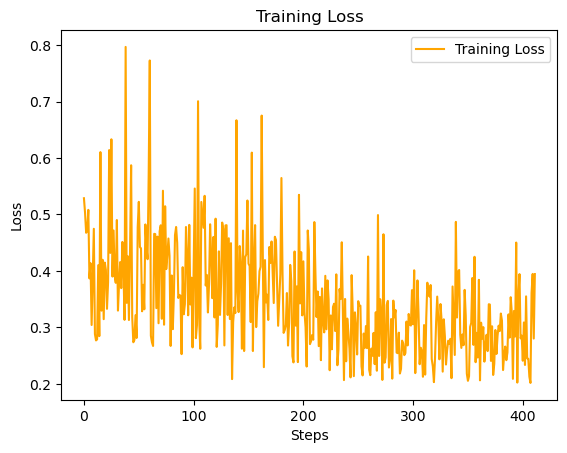

In [93]:
plot_losses(train_loss, "Training Loss", "orange", "Train Loss")

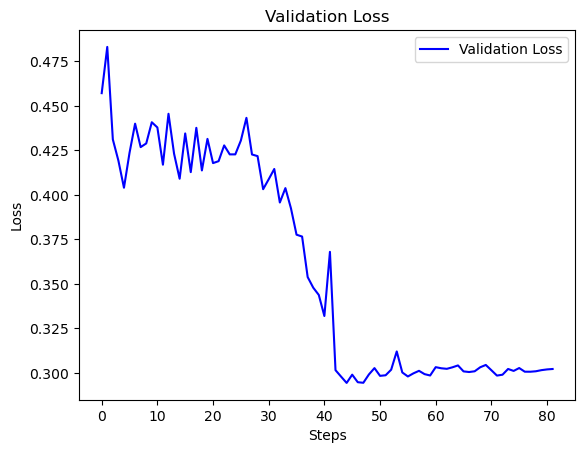

In [94]:
plot_losses(eval_loss, "Validation Loss", "blue", "validation Loss")

In [95]:
train_set[0]

{'input_ids': tensor([     0,  59584,  32462,  24592,    186,  17457,    143,   3616,   3719,
          20236,     10, 125441,   1021,  45511,      6,  86392,   2726,   8805,
          14612, 125470,  10627,   9132, 130400,   2471,   2943,    497,  15904,
          15855,    372,      6,  82497,  22188, 123916,   7022,  51642,  45793,
            286,    127,   8736,     31,    259,   7404,  19165,  35251,    156,
              9, 139701,    180,    238,  14051, 110517,     17,  11866,  46526,
           1314,    111,   2907,  14245,   1061,   2465,   2481,      4,  22951,
            172,    919,   6990,   5871,  48546,  39036,     57,    184,   3957,
             92,  86519,      5,  15363,  47119,  16646,  25609,    350,  22188,
         123916,     95,    150,   8753,    143,  13315,  16432,     13, 166722,
           2422, 231036,  73911,  21463,  11440,   7316,  20133,    143,  85068,
         213948,     22,   1234,  11033,    760,  77524,    202,    634,    459,
          32457

In [96]:
# Testing using the test set
test_set[0]

{'input_ids': tensor([     0,   8992,  23415,  27587,    445,  10902,    365,  18885,   7057,
          22519,   6332,  12948,  16646,   7299,   6774,    161,   1240,     11,
          95254,   1151,    932,   1158, 170114,     17,      9,    284,  53975,
           1326,  51899,   6644,  46640,     15,    284,  47744,    247,   1257,
          92115,  58182,  39862,   4759,    350,     96,   1177,   1158,  55762,
          89064,    433,    203,  57566,    110,  19379,    265,  37663,   1106,
            273,   2527,  62309,    537,  90508,     90,  54140,    110,    605,
            133,    372,  33978,  11631,    634,    566,  14612,   6774,   2422,
          38170,  10955,   1240,  11067,      9,   1052,    758, 154784,  19879,
             28,   9012,  28952,  86519,   1240,  11067,  31043,   1602,    594,
            273,  19120,    642,   5709,     14,   4233,    776,    708,   3005,
            594,  90604,     28,    594, 113032, 107008,      4,     24,  38303,
          39036

In [97]:
test_results = trainer.evaluate(test_set)

Step 4120, Loss: 0.1991


Step 4120, Loss: 0.2033
Step 4120, Loss: 0.2015
Step 4120, Loss: 0.5706
Step 4120, Loss: 0.2014
Step 4120, Loss: 0.2013
Step 4120, Loss: 0.2029
Step 4120, Loss: 0.2261
Step 4120, Loss: 0.1993
Step 4120, Loss: 0.7252
Step 4120, Loss: 0.2000
Step 4120, Loss: 0.2019
Step 4120, Loss: 0.2004
Step 4120, Loss: 0.7543
Step 4120, Loss: 0.1999
Step 4120, Loss: 0.2225
Step 4120, Loss: 0.2006
Step 4120, Loss: 0.2020
Step 4120, Loss: 0.2007
Step 4120, Loss: 0.2271
Step 4120, Loss: 0.2009
Step 4120, Loss: 0.2456
Step 4120, Loss: 0.2002
Step 4120, Loss: 0.2153
Step 4120, Loss: 0.1988
Step 4120, Loss: 0.9184
Step 4120, Loss: 0.2027
Step 4120, Loss: 0.3541
Step 4120, Loss: 0.1997
Step 4120, Loss: 0.3443
Step 4120, Loss: 0.1995
Step 4120, Loss: 0.2059
Step 4120, Loss: 0.2031
Step 4120, Loss: 0.7345
Step 4120, Loss: 0.2060
Step 4120, Loss: 0.2081
Step 4120, Loss: 0.2000
Step 4120, Loss: 0.2005
Step 4120, Loss: 0.2023
Step 4120, Loss: 0.1997
Step 4120, Loss: 0.4423
Step 4120, Loss: 0.3492
Step 4120, Loss:

In [98]:
test_set[0]

{'input_ids': tensor([     0,   8992,  23415,  27587,    445,  10902,    365,  18885,   7057,
          22519,   6332,  12948,  16646,   7299,   6774,    161,   1240,     11,
          95254,   1151,    932,   1158, 170114,     17,      9,    284,  53975,
           1326,  51899,   6644,  46640,     15,    284,  47744,    247,   1257,
          92115,  58182,  39862,   4759,    350,     96,   1177,   1158,  55762,
          89064,    433,    203,  57566,    110,  19379,    265,  37663,   1106,
            273,   2527,  62309,    537,  90508,     90,  54140,    110,    605,
            133,    372,  33978,  11631,    634,    566,  14612,   6774,   2422,
          38170,  10955,   1240,  11067,      9,   1052,    758, 154784,  19879,
             28,   9012,  28952,  86519,   1240,  11067,  31043,   1602,    594,
            273,  19120,    642,   5709,     14,   4233,    776,    708,   3005,
            594,  90604,     28,    594, 113032, 107008,      4,     24,  38303,
          39036

In [99]:
test_results

{'eval_loss': 0.2768128514289856,
 'eval_accuracy': 0.9563106796116505,
 'eval_f1': 0.9568122343311704,
 'eval_precision': 0.9574198768138636,
 'eval_recall': 0.9563106796116505,
 'eval_runtime': 2.0464,
 'eval_samples_per_second': 100.666,
 'eval_steps_per_second': 25.411,
 'epoch': 10.0}

In [100]:
test_set[0]

{'input_ids': tensor([     0,   8992,  23415,  27587,    445,  10902,    365,  18885,   7057,
          22519,   6332,  12948,  16646,   7299,   6774,    161,   1240,     11,
          95254,   1151,    932,   1158, 170114,     17,      9,    284,  53975,
           1326,  51899,   6644,  46640,     15,    284,  47744,    247,   1257,
          92115,  58182,  39862,   4759,    350,     96,   1177,   1158,  55762,
          89064,    433,    203,  57566,    110,  19379,    265,  37663,   1106,
            273,   2527,  62309,    537,  90508,     90,  54140,    110,    605,
            133,    372,  33978,  11631,    634,    566,  14612,   6774,   2422,
          38170,  10955,   1240,  11067,      9,   1052,    758, 154784,  19879,
             28,   9012,  28952,  86519,   1240,  11067,  31043,   1602,    594,
            273,  19120,    642,   5709,     14,   4233,    776,    708,   3005,
            594,  90604,     28,    594, 113032, 107008,      4,     24,  38303,
          39036

In [101]:
len(test)

206

In [102]:
def get_true_labels(test_set):
    true_labels = []
    for i in range(len(test_set)):
        label = test_set[i]['labels']
        true_labels.append(label.item())
    return true_labels

true_labels = get_true_labels(test_set)

In [103]:
true_labels = np.array(true_labels)
#true_labels

In [104]:
def get_predicted_labes(test_set):
    predictions = trainer.predict(test_set)
    logits = predictions.predictions
    predicted_classes = torch.argmax(torch.tensor(logits), dim=-1)
    return predicted_classes

In [105]:
predictions = trainer.predict(test_set)
logits = predictions.predictions

Step 4120, Loss: 0.1991
Step 4120, Loss: 0.2033
Step 4120, Loss: 0.2015
Step 4120, Loss: 0.5706
Step 4120, Loss: 0.2014
Step 4120, Loss: 0.2013
Step 4120, Loss: 0.2029
Step 4120, Loss: 0.2261
Step 4120, Loss: 0.1993
Step 4120, Loss: 0.7252
Step 4120, Loss: 0.2000
Step 4120, Loss: 0.2019
Step 4120, Loss: 0.2004
Step 4120, Loss: 0.7543
Step 4120, Loss: 0.1999
Step 4120, Loss: 0.2225
Step 4120, Loss: 0.2006
Step 4120, Loss: 0.2020
Step 4120, Loss: 0.2007
Step 4120, Loss: 0.2271
Step 4120, Loss: 0.2009
Step 4120, Loss: 0.2456
Step 4120, Loss: 0.2002
Step 4120, Loss: 0.2153
Step 4120, Loss: 0.1988
Step 4120, Loss: 0.9184
Step 4120, Loss: 0.2027
Step 4120, Loss: 0.3541
Step 4120, Loss: 0.1997
Step 4120, Loss: 0.3443
Step 4120, Loss: 0.1995
Step 4120, Loss: 0.2059
Step 4120, Loss: 0.2031
Step 4120, Loss: 0.7345
Step 4120, Loss: 0.2060
Step 4120, Loss: 0.2081
Step 4120, Loss: 0.2000
Step 4120, Loss: 0.2005
Step 4120, Loss: 0.2023
Step 4120, Loss: 0.1997
Step 4120, Loss: 0.4423
Step 4120, Loss:

In [106]:
#logits

In [107]:
predicted_classes = torch.argmax(torch.tensor(logits), dim=-1)
predicted_classes = np.array(predicted_classes)

In [108]:
print(classification_report(true_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       187
           1       0.75      0.79      0.77        19

    accuracy                           0.96       206
   macro avg       0.86      0.88      0.87       206
weighted avg       0.96      0.96      0.96       206



In [109]:
## CHECKING WHICH TOKENS INFLUENCE THE MODEL's DECISION MAKING

In [110]:


def analyze_token_importance(model, tokenizer, text, label, top_k=10):
    # Tokenize input
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt'
    )
    
    # Get input_ids and attention mask
    input_ids = inputs['input_ids'].to(model.device)
    attention_mask = inputs['attention_mask'].to(model.device)
    
    # Get embeddings from input_ids
    embeddings = model.get_input_embeddings()(input_ids)
    embeddings.requires_grad = True  # Enable gradient calculation for embeddings
    
    # Forward pass with embeddings
    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
    logits = outputs.logits
    
    # Get prediction
    pred = torch.argmax(logits, dim=1).item()
    
    # Compute gradient with respect to predicted class
    logits[:, pred].backward()
    
    # Get gradients with respect to the embeddings
    gradients = embeddings.grad.abs()
    
    # Convert to numpy for analysis
    importance_scores = gradients[0].cpu().numpy()
    tokens = input_ids[0].cpu().numpy()
    
    # Create list of (token, importance) tuples
    token_importance = []
    for token, score in zip(tokens, importance_scores):
        if token != tokenizer.pad_token_id:  # Skip padding tokens
            token_text = tokenizer.decode([token])
            token_importance.append((token_text, score.mean()))  # Averaging across embedding dimensions
    
    # Sort by importance
    token_importance.sort(key=lambda x: x[1], reverse=True)
    
    # Print results
    print(f"\nAnalyzing text: {text[:100]}...")
    print(f"True label: {label}")
    print(f"Predicted label: {pred}")
    print(f"\nTop {top_k} most influential tokens:")
    for token, importance in token_importance[:top_k]:
        print(f"Token: {token:15} Importance: {importance:.5f}")
        
    return token_importance

# Test on a few examples
def analyze_and_highlight_all(model, tokenizer, dataset, top_k=5):
    model.eval()  # Set the model to evaluation mode
    num_samples = len(dataset)  # Get the total number of samples in the dataset
    
    for i in range(num_samples):
        sample = dataset[i]
        
        # Get original text by decoding input_ids
        text = tokenizer.decode(sample['input_ids'])
        label = sample['labels'].item()
        
        print(f"\n=== Article {i+1}/{num_samples} ===")
        token_importance = analyze_token_importance(model, tokenizer, text, label, top_k=top_k)
        
        # Visualize with highlighting
        print("\nText with highlighting:")
        words = text.split()
        important_tokens = [t[0].strip() for t in token_importance[:top_k]]  # Top important tokens
        highlighted_text = []
        
        for word in words:
            if any(token in word for token in important_tokens):
                highlighted_text.append(f"**{word}**")  # Highlight important tokens
            else:
                highlighted_text.append(word)
                
        # Print the highlighted text
        print(" ".join(highlighted_text))




In [111]:


def analyze_token_importance(model, tokenizer, text, label, top_k=10):
    # Tokenize input
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt'
    )
    
    # Get input_ids and attention mask
    input_ids = inputs['input_ids'].to(model.device)
    attention_mask = inputs['attention_mask'].to(model.device)
    
    # Get embeddings from input_ids
    embeddings = model.get_input_embeddings()(input_ids)
    embeddings.requires_grad = True  # Enable gradient calculation for embeddings
    
    # Forward pass with embeddings
    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
    logits = outputs.logits
    
    # Get prediction
    pred = torch.argmax(logits, dim=1).item()
    
    # Compute gradient with respect to predicted class
    logits[:, pred].backward()
    
    # Get gradients with respect to the embeddings
    gradients = embeddings.grad.abs()
    
    # Convert to numpy for analysis
    importance_scores = gradients[0].cpu().numpy()
    tokens = input_ids[0].cpu().numpy()
    
    # Create list of (token, importance) tuples
    token_importance = []
    for token, score in zip(tokens, importance_scores):
        if token != tokenizer.pad_token_id:  # Skip padding tokens
            token_text = tokenizer.decode([token])
            token_importance.append((token_text, score.mean()))  # Averaging across embedding dimensions
    
    # Sort by importance
    token_importance.sort(key=lambda x: x[1], reverse=True)
    
    # Print results
    print(f"\nAnalyzing text: {text[:100]}...")
    print(f"True label: {label}")
    print(f"Predicted label: {pred}")
    print(f"\nTop {top_k} most influential tokens:")
    for token, importance in token_importance[:top_k]:
        print(f"Token: {token:15} Importance: {importance:.5f}")
        
    return token_importance

# Test on a few examples
def analyze_and_highlight_all(model, tokenizer, dataset, top_k=5):
    model.eval()  # Set the model to evaluation mode
    num_samples = len(dataset)  # Get the total number of samples in the dataset
    
    for i in range(num_samples):
        sample = dataset[i]
        
        # Get original text by decoding input_ids
        text = tokenizer.decode(sample['input_ids'])
        label = sample['labels'].item()
        
        print(f"\n=== Article {i+1}/{num_samples} ===")
        token_importance = analyze_token_importance(model, tokenizer, text, label, top_k=top_k)
        
        # Visualize with highlighting
        print("\nText with highlighting:")
        words = text.split()
        important_tokens = [t[0].strip() for t in token_importance[:top_k]]  # Top important tokens
        highlighted_text = []
        
        for word in words:
            if any(token in word for token in important_tokens):
                highlighted_text.append(f"**{word}**")  # Highlight important tokens
            else:
                highlighted_text.append(word)
                
        # Print the highlighted text
        print(" ".join(highlighted_text))

# Use the function to process the entire test set
print("\nAnalyzing and highlighting for all articles in the test set...")
analyze_and_highlight_all(lora_model, tokenizer, test_set)

# Use the functions
#print("Analyzing model decisions...")
#analyze_samples(lora_model, tokenizer, test_set)



Analyzing and highlighting for all articles in the test set...

=== Article 1/206 ===

Analyzing text: <s> KUTHELE izithelo ezinhle ukubambisana kwezinhlaka ezahlukene zezomthetho i-Asset Forfeiture Unit...
True label: 0
Predicted label: 0

Top 5 most influential tokens:
Token: <s>             Importance: 0.00654
Token: phakathi        Importance: 0.00452
Token: mthetho         Importance: 0.00366
Token: mthetho         Importance: 0.00335
Token: PP              Importance: 0.00332

Text with highlighting:
**<s>** KUTHELE izithelo ezinhle ukubambisana kwezinhlaka ezahlukene **zezomthetho** i-Asset Forfeiture Unit (AFU), uphiko lukazwelonke lwezokushushisa kanjalo nophiko oluphenya amacala ayisipesheli noKlebe kushaqwa imphahla yezigidi ezingu-R52.6 million ezikhulwini ezingu-22 zoMnyango wezemiSebenzi **yoMphakathi** eMpumalanga, nakumabhizinisi aphakela lo mnyango ngemisebenzi.Ukushaqwa kwale mpahla kuhambisana **nomthetho** wesiGaba 26 **womthetho** Wokuvimbela Ubugebengu Obuhleliwe

In [112]:
# 100% seem suspicious so we pulled a randome article from google to see how we will classify it correctly

## Visualizing model decision making

In [113]:
cm = confusion_matrix(true_labels, predicted_classes)


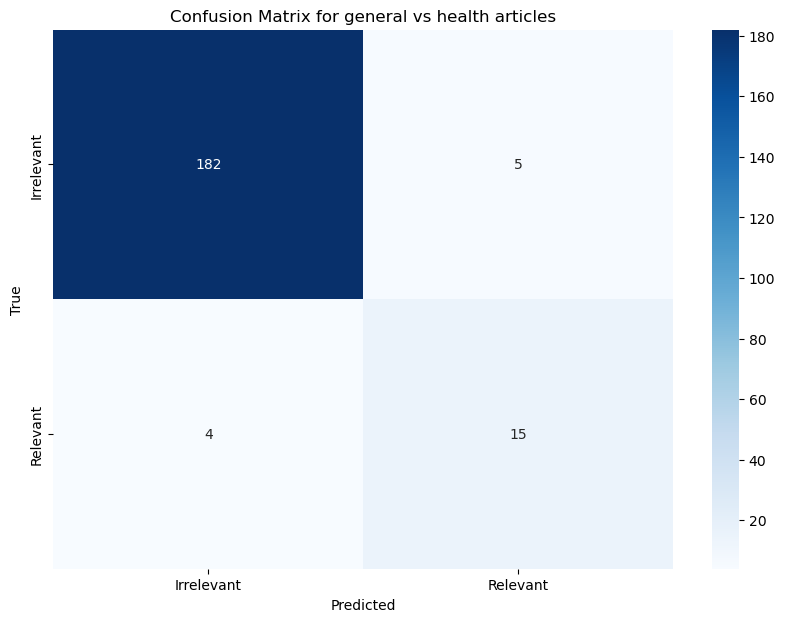

In [114]:

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Irrelevant", "Relevant"], yticklabels=["Irrelevant", "Relevant"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for general vs health articles')
plt.savefig("confusion matrix unbalanced")
plt.show()

## Visualizing attention

In [130]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os

def ensure_save_dir(base_dir='visualization_outputs'):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    save_dir = os.path.join(base_dir, timestamp)
    os.makedirs(save_dir, exist_ok=True)
    return save_dir

def select_important_tokens(tokens, attention_weights, max_tokens=30):
    mean_attention = attention_weights.mean(axis=0)
    top_indices = np.argsort(mean_attention)[-max_tokens:]
    start_tokens = set(range(min(5, len(tokens))))
    end_tokens = set(range(max(0, len(tokens)-5), len(tokens)))
    important_indices = sorted(set(list(top_indices) + list(start_tokens) + list(end_tokens)))
    return important_indices

def visualize_attention_for_sample(model, tokenizer, sample, layer_num=-1, max_tokens=30, save_dir=None):
    if save_dir:
        save_dir = ensure_save_dir(save_dir)
    
    model.eval()
    
    input_ids = sample['input_ids'].unsqueeze(0).to(model.device)
    attention_mask = sample['attention_mask'].unsqueeze(0).to(model.device)
    label = sample['labels'].item()
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, 
                      attention_mask=attention_mask,
                      output_attentions=True)
    
    attention = outputs.attentions[layer_num][0]
    avg_attention = attention.mean(dim=0).cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    important_indices = select_important_tokens(tokens, avg_attention, max_tokens)
    selected_tokens = [tokens[idx] for idx in important_indices]
    selected_attention = avg_attention[important_indices][:, important_indices]
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(selected_attention,
                xticklabels=selected_tokens,
                yticklabels=selected_tokens,
                cmap='viridis')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title(f'Label: {label} - Attention Pattern (Layer {layer_num})\nShowing {len(selected_tokens)} most important tokens')
    plt.tight_layout()
    
    if save_dir:
        save_path = os.path.join(save_dir, f'attention_layer_{layer_num}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved attention plot to: {save_path}")
    
    plt.show()

def visualize_token_importance_for_sample(model, tokenizer, sample, max_tokens=30, save_dir=None):
    if save_dir:
        save_dir = ensure_save_dir(save_dir)
    
    model.eval()
    
    input_ids = sample['input_ids'].unsqueeze(0).to(model.device)
    attention_mask = sample['attention_mask'].unsqueeze(0).to(model.device)
    label = sample['labels'].item()
    
    embeddings = model.roberta.embeddings(input_ids)
    embeddings.retain_grad()
    
    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
    outputs.logits.max().backward()
    
    importance = embeddings.grad.abs().mean(dim=-1)[0].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    top_indices = np.argsort(importance)[-max_tokens:]
    top_tokens = [tokens[idx] for idx in top_indices]
    top_importance = importance[top_indices]
    
    plt.figure(figsize=(15, 6))
    bars = plt.bar(range(len(top_tokens)), top_importance)
    plt.xticks(range(len(top_tokens)), top_tokens, rotation=45, ha='right')
    plt.title(f'Label: {label} - Top {max_tokens} Most Important Tokens')
    plt.xlabel('Tokens')
    plt.ylabel('Importance Score')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    
    if save_dir:
        save_path = os.path.join(save_dir, f'token_importance.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved token importance plot to: {save_path}")
    
    plt.show()

def visualize_activations_for_sample(model, tokenizer, sample, max_tokens=30, save_dir=None):
    if save_dir:
        save_dir = ensure_save_dir(save_dir)
    
    model.eval()
    
    input_ids = sample['input_ids'].unsqueeze(0).to(model.device)
    attention_mask = sample['attention_mask'].unsqueeze(0).to(model.device)
    label = sample['labels'].item()
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids,
                      attention_mask=attention_mask,
                      output_hidden_states=True)
    
    hidden_states = outputs.hidden_states
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])[:max_tokens]
    
    layers_to_plot = [0, len(hidden_states)//2, -1]
    fig, axes = plt.subplots(len(layers_to_plot), 1, figsize=(15, 5*len(layers_to_plot)))
    fig.suptitle(f'Label: {label} - Layer Activations (First {max_tokens} tokens)')
    
    for idx, layer_idx in enumerate(layers_to_plot):
        activations = hidden_states[layer_idx][0, :max_tokens, :50].cpu().numpy()
        sns.heatmap(activations, 
                   cmap='coolwarm',
                   center=0,
                   ax=axes[idx])
        axes[idx].set_title(f'Layer {layer_idx}')
        axes[idx].set_xlabel('Hidden Dimension (first 50)')
        axes[idx].set_ylabel('Token Position')
        if idx == 0:
            axes[idx].set_yticklabels(tokens, rotation=0)
    
    plt.tight_layout()
    
    if save_dir:
        save_path = os.path.join(save_dir, f'activations.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved activations plot to: {save_path}")
    
    plt.show()

def analyze_single_sample(model, tokenizer, sample, max_tokens=30, save_dir=None):
    if save_dir:
        save_dir = ensure_save_dir(save_dir)
        print(f"Saving all visualizations to: {save_dir}")
    
    visualize_attention_for_sample(model, tokenizer, sample, max_tokens=max_tokens, save_dir=save_dir)
    
    visualize_token_importance_for_sample(model, tokenizer, sample, max_tokens=max_tokens, save_dir=save_dir)
    
    visualize_activations_for_sample(model, tokenizer, sample, max_tokens=max_tokens, save_dir=save_dir)


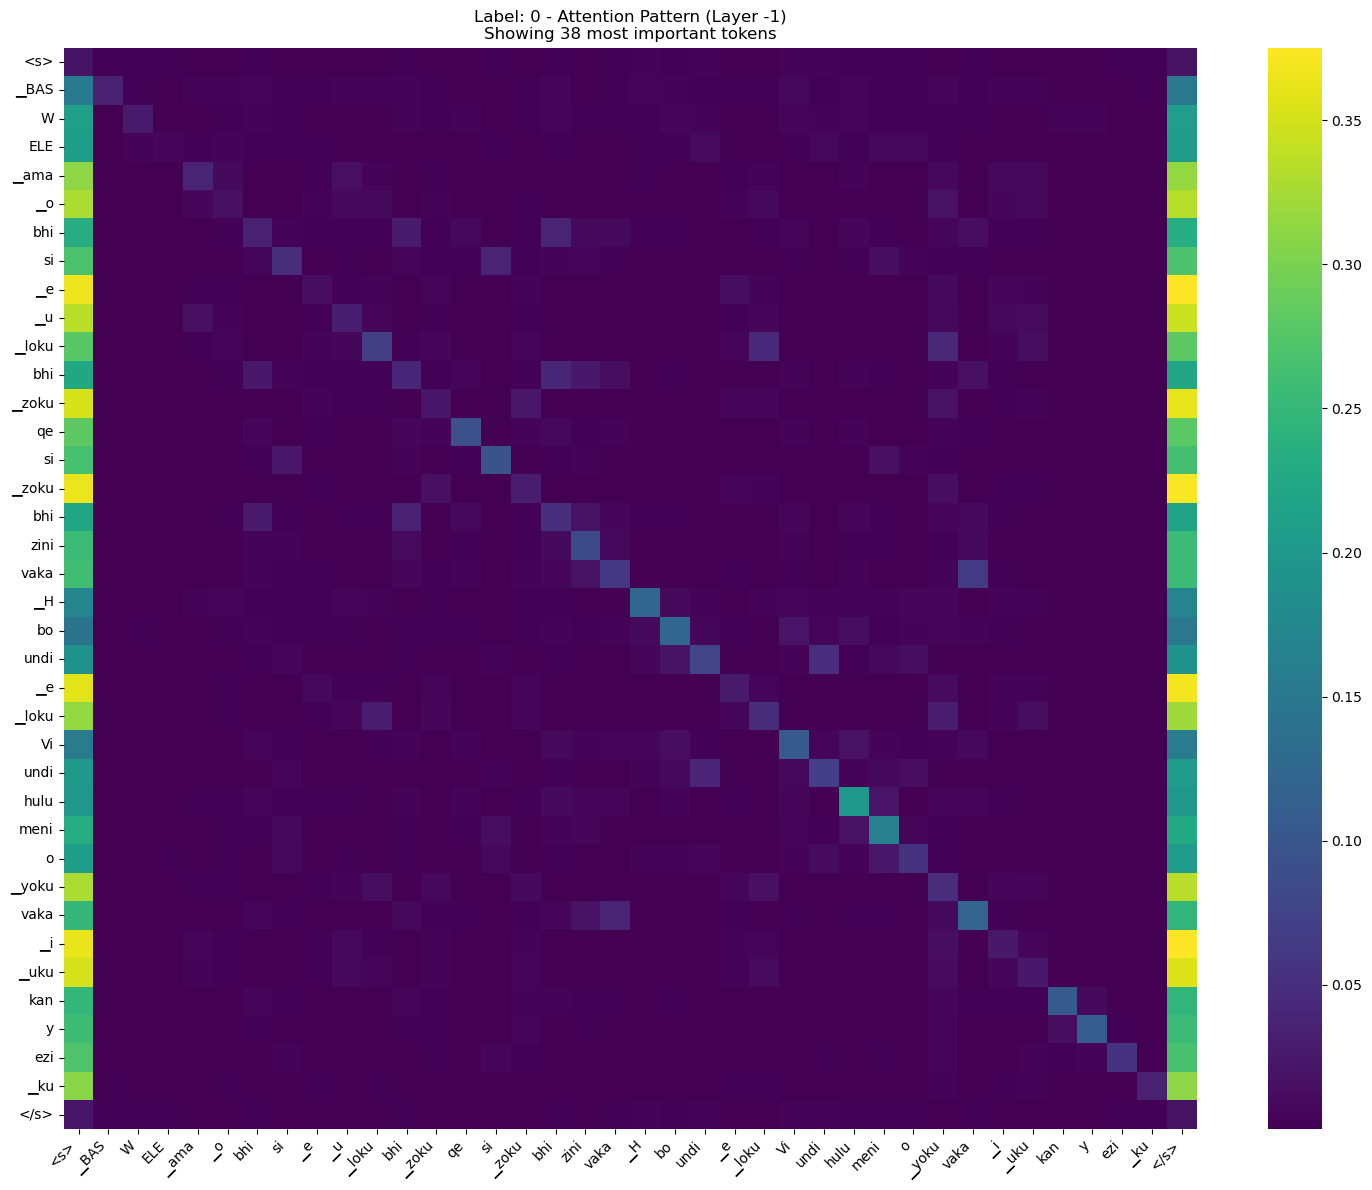

RuntimeError: can't retain_grad on Tensor that has requires_grad=False

In [131]:
sample = test_set[100]  # Select a specific article/sample
analyze_single_sample(model, tokenizer, sample, max_tokens=30)


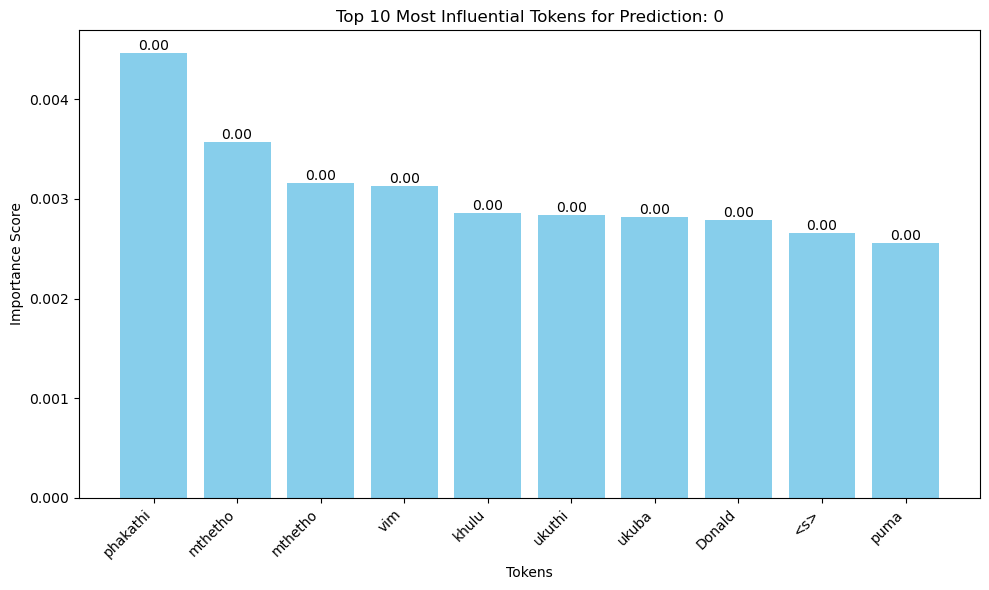

[('phakathi', 0.004469681),
 ('mthetho', 0.0035759269),
 ('mthetho', 0.0031586941),
 ('vim', 0.0031294783),
 ('khulu', 0.0028610528),
 ('ukuthi', 0.0028354984),
 ('ukuba', 0.002816568),
 ('Donald', 0.0027872294),
 ('<s>', 0.002655118),
 ('puma', 0.0025574062),
 ('khulu', 0.0023538705),
 ('geben', 0.0023506247),
 ('sebenzi', 0.00234056),
 ('bhi', 0.002297999),
 ('kodwa', 0.002292883),
 ('mthetho', 0.0022426615),
 ('Unit', 0.0021966812),
 ('sikhathi', 0.002157539),
 ('fei', 0.0021541042),
 ('ndlela', 0.0021396542),
 ('SI', 0.0019808281),
 ('frica', 0.0019272673),
 ('ukuze', 0.0019160127),
 ('1998', 0.0018464889),
 ('Mac', 0.0018214183),
 ('CC', 0.001804546),
 ('umsebenzi', 0.0017990259),
 ('bonke', 0.0017766586),
 (',', 0.001751731),
 ('Properties', 0.001688661),
 ('aq', 0.0016846958),
 ('.', 0.0016602846),
 ('tando', 0.0016284551),
 ('.', 0.0016232679),
 ('.', 0.0016190602),
 ('geben', 0.0016161989),
 ('.', 0.0015386777),
 ('.', 0.0014817392),
 ('nya', 0.0014556352),
 ('ane', 0.00145531

In [132]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def analyze_token_importance_from_test_set(model, tokenizer, sample, top_k=10):
    # Extract tokenized input from the sample
    input_ids = sample['input_ids'].unsqueeze(0).to(model.device)
    attention_mask = sample['attention_mask'].unsqueeze(0).to(model.device)
    label = sample['labels'].item() if 'labels' in sample else None
    embeddings = model.get_input_embeddings()(input_ids)
    embeddings.requires_grad = True  # Enable gradient calculation for embeddings
    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    logits[:, pred].backward()
    gradients = embeddings.grad.abs()
    importance_scores = gradients[0].cpu().numpy()
    tokens = input_ids[0].cpu().numpy()
    token_importance = []
    for token, score in zip(tokens, importance_scores):
        if token != tokenizer.pad_token_id:  # Skip padding tokens
            token_text = tokenizer.decode([token])
            token_importance.append((token_text, score.mean()))  # Averaging across embedding dimensions
    token_importance.sort(key=lambda x: x[1], reverse=True)
    top_tokens = [token for token, _ in token_importance[:top_k]]
    top_scores = [importance for _, importance in token_importance[:top_k]]
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(top_k), top_scores, color='skyblue')
    plt.xticks(range(top_k), top_tokens, rotation=45, ha='right')
    plt.xlabel('Tokens')
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_k} Most Influential Tokens for Prediction: {pred}')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{height:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return token_importance

analyze_token_importance_from_test_set(model, tokenizer, test_set[0], top_k=10)


In [136]:
"""def analyze_attention_across_layers(model, tokenizer, test_set, article_idx, 
                                  max_tokens=30, num_layers=None):
    Analyze attention patterns across multiple layers for a specific article
    model.eval()
    
    # Get the specific article
    sample = test_set[article_idx]
    input_ids = sample['input_ids'].unsqueeze(0).to(model.device)
    attention_mask = sample['attention_mask'].unsqueeze(0).to(model.device)
    label = sample['labels'].item()
    
    # Get model outputs
    with torch.no_grad():
        outputs = model(input_ids=input_ids, 
                      attention_mask=attention_mask,
                      output_attentions=True)
    
    # Determine number of layers to show
    if num_layers is None:
        num_layers = len(outputs.attentions)
    num_layers = min(num_layers, len(outputs.attentions))
    
    # Select layers to visualize (evenly spaced)
    layer_indices = np.linspace(0, len(outputs.attentions)-1, num_layers, dtype=int)
    
    # Create subplot grid
    fig, axes = plt.subplots(num_layers, 1, figsize=(15, 5*num_layers))
    if num_layers == 1:
        axes = [axes]
    
    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # Analyze each selected layer
    for idx, layer_idx in enumerate(layer_indices):
        attention = outputs.attentions[layer_idx][0]
        avg_attention = attention.mean(dim=0).cpu().numpy()
        
        # Select important tokens
        token_importance = avg_attention.mean(axis=0)
        top_indices = np.argsort(token_importance)[-max_tokens:]
        selected_tokens = [tokens[idx] for idx in top_indices]
        selected_attention = avg_attention[top_indices][:, top_indices]
        
        # Create heatmap
        sns.heatmap(selected_attention,
                    xticklabels=selected_tokens,
                    yticklabels=selected_tokens,
                    cmap='viridis',
                    ax=axes[idx])
        
        axes[idx].set_xticklabels(selected_tokens, rotation=45, ha='right')
        axes[idx].set_yticklabels(selected_tokens, rotation=0)
        axes[idx].set_title(f'Layer {layer_idx} Attention Pattern')
    
    # Overall title
    article_text = tokenizer.decode(sample['input_ids'])
    plt.suptitle(f'Article {article_idx} (Label: {label})\n' +
                f'First 100 chars: "{article_text[:100]}..."',
                y=1.02)
    
    plt.tight_layout()
    plt.show()
    analyze_attention_across_layers(model, tokenizer, test_set, 
                              article_idx=3, max_tokens=10, num_layers=3)"""

111

111

## The data imbalance is significant and the model learns more to the dominating class, we suspect that for each the class 0 is limited or not present at all, we balance the data by creating duplicates

In [167]:
with open(HEALTH_DATA_PATH, "r", encoding = "utf-8") as file:
    health_data = json.load(file)

In [168]:
len(health_data)

187

In [169]:
with open(GENERAL_DATA_PATH, "r", encoding = "utf-8") as file:
    general_data = json.load(file)

In [170]:
#duplicating the dataset
def create_duplicates(data_list, duplicate_n_times):
    n = 0
    if duplicate_n_times != 0:
        print("duplicate predined times")
        n = duplicate_n_times
    else:
        label_0_count = 0
        for i in range(len(data_list)):
            #print(data_list[i]['label'])
            if data_list[i]['label'] == 0:
                label_0_count+=1
        print(label_0_count)
        label_1_count = len(data_list)- label_0_count
        n = label_0_count
        n-= label_1_count
        n/=label_1_count
        n = math.floor(n)
    print(f"duplicating for {n} times")
    for i in range(len(data_list)):
        if data_list[i]['label']  == 1:
            for j in range(n):
                data_list.append(data_list[i])
    return data_list

#duplicated_health = create_duplicates(health_data)

In [171]:
health_data = label_data(health_data, 1)
general_data = label_data(general_data, 0)

In [172]:
train = combine_data(general_data, health_data)

In [173]:
len(train)

2057

In [174]:
train, validation, test = split_data(train, duplicate = True)

1498
duplicating for 9 times


In [175]:
len(test)


206

In [176]:
len(train)

2968

In [177]:
print("Train set:")
check_data_distribution(train)

Train set:
Label distribution:
Label 0: 1498 (50.47%)
Label 1: 1470 (49.53%)


In [178]:
print("Test set:")
check_data_distribution(test)

Test set:
Label distribution:
Label 0: 187 (90.78%)
Label 1: 19 (9.22%)


In [179]:
print("Validation set:")
check_data_distribution(validation)

Validation set:
Label distribution:
Label 0: 185 (89.81%)
Label 1: 21 (10.19%)


In [180]:
train_set, validation_set, test_set = tokenize(tokenizer)

In [181]:
len(test_set)

206

In [182]:
len(train_set)

206

In [183]:
trainer = CustomTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics
)

trainer.train()

Step 0, Loss: 0.3241


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.236600,0.293600,0.956311,0.956759,0.957308,0.956311
100,0.213100,0.291598,0.956311,0.956759,0.957308,0.956311
150,0.254900,0.306414,0.936893,0.931168,0.931381,0.936893
200,0.260100,0.298189,0.951456,0.952428,0.953777,0.951456
250,0.313700,0.293156,0.956311,0.956759,0.957308,0.956311
300,0.208200,0.298935,0.956311,0.956759,0.957308,0.956311
350,0.247100,0.301156,0.956311,0.956759,0.957308,0.956311
400,0.219800,0.297492,0.956311,0.956759,0.957308,0.956311
450,0.203000,0.296891,0.956311,0.956759,0.957308,0.956311
500,0.304100,0.291099,0.961165,0.960299,0.959892,0.961165


Step 10, Loss: 0.2012
Step 20, Loss: 0.2009
Step 30, Loss: 0.2015
Step 40, Loss: 0.2499
Step 50, Loss: 0.2028
Step 50, Loss: 0.2003
Step 50, Loss: 0.2004
Step 50, Loss: 0.2021
Step 50, Loss: 0.2009
Step 50, Loss: 0.2039
Step 50, Loss: 0.2011
Step 50, Loss: 0.2015
Step 50, Loss: 1.0854
Step 50, Loss: 0.2031
Step 50, Loss: 0.2107
Step 50, Loss: 0.2164
Step 50, Loss: 0.2005
Step 50, Loss: 0.1996
Step 50, Loss: 0.2012
Step 50, Loss: 0.2015
Step 50, Loss: 0.2010
Step 50, Loss: 0.2016
Step 50, Loss: 0.2005
Step 50, Loss: 0.9091
Step 50, Loss: 0.1996
Step 50, Loss: 0.2018
Step 50, Loss: 0.2395
Step 50, Loss: 0.2003
Step 50, Loss: 0.2005
Step 50, Loss: 0.1994
Step 50, Loss: 0.2009
Step 50, Loss: 0.2002
Step 50, Loss: 0.2021
Step 50, Loss: 0.8190
Step 50, Loss: 0.2524
Step 50, Loss: 0.2026
Step 50, Loss: 0.2018
Step 50, Loss: 0.2017
Step 50, Loss: 0.2006
Step 50, Loss: 0.9140
Step 50, Loss: 0.2037
Step 50, Loss: 0.5674
Step 50, Loss: 0.2004
Step 50, Loss: 0.2030
Step 50, Loss: 0.2304
Step 50, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 60, Loss: 0.7171
Step 70, Loss: 0.2044
Step 80, Loss: 0.7400
Step 90, Loss: 0.2010
Step 100, Loss: 0.2002
Step 100, Loss: 0.1994
Step 100, Loss: 0.1998
Step 100, Loss: 0.2009
Step 100, Loss: 0.1998
Step 100, Loss: 0.2119
Step 100, Loss: 0.2002
Step 100, Loss: 0.2009
Step 100, Loss: 0.9089
Step 100, Loss: 0.2240
Step 100, Loss: 0.2061
Step 100, Loss: 0.2120
Step 100, Loss: 0.2006
Step 100, Loss: 0.1993
Step 100, Loss: 0.2016
Step 100, Loss: 0.2007
Step 100, Loss: 0.2000
Step 100, Loss: 0.2003
Step 100, Loss: 0.2012
Step 100, Loss: 0.8885
Step 100, Loss: 0.1989
Step 100, Loss: 0.2005
Step 100, Loss: 0.2107
Step 100, Loss: 0.1996
Step 100, Loss: 0.2000
Step 100, Loss: 0.1989
Step 100, Loss: 0.2001
Step 100, Loss: 0.1999
Step 100, Loss: 0.2007
Step 100, Loss: 0.7493
Step 100, Loss: 0.2133
Step 100, Loss: 0.2016
Step 100, Loss: 0.2009
Step 100, Loss: 0.2155
Step 100, Loss: 0.2008
Step 100, Loss: 0.8911
Step 100, Loss: 0.2025
Step 100, Loss: 0.7040
Step 100, Loss: 0.1997
Step 100, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 110, Loss: 0.1995
Step 120, Loss: 0.2003
Step 130, Loss: 0.2014
Step 140, Loss: 0.2001
Step 150, Loss: 0.7533
Step 150, Loss: 0.1986
Step 150, Loss: 0.1991
Step 150, Loss: 0.1993
Step 150, Loss: 0.1987
Step 150, Loss: 0.2009
Step 150, Loss: 0.1986
Step 150, Loss: 0.1992
Step 150, Loss: 1.2454
Step 150, Loss: 0.1994
Step 150, Loss: 0.2418
Step 150, Loss: 0.3735
Step 150, Loss: 0.1986
Step 150, Loss: 0.1987
Step 150, Loss: 0.1990
Step 150, Loss: 0.1989
Step 150, Loss: 0.1986
Step 150, Loss: 0.1988
Step 150, Loss: 0.1991
Step 150, Loss: 0.8404
Step 150, Loss: 0.1989
Step 150, Loss: 0.1987
Step 150, Loss: 0.4190
Step 150, Loss: 0.2000
Step 150, Loss: 0.1990
Step 150, Loss: 0.1987
Step 150, Loss: 0.1987
Step 150, Loss: 0.3940
Step 150, Loss: 0.1992
Step 150, Loss: 0.8493
Step 150, Loss: 0.4858
Step 150, Loss: 0.1995
Step 150, Loss: 0.1988
Step 150, Loss: 0.1991
Step 150, Loss: 0.1989
Step 150, Loss: 0.8498
Step 150, Loss: 0.1993
Step 150, Loss: 0.2159
Step 150, Loss: 0.1986
Step 150, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 160, Loss: 0.2001
Step 170, Loss: 0.2029
Step 180, Loss: 0.6584
Step 190, Loss: 0.2011
Step 200, Loss: 0.2021
Step 200, Loss: 0.1990
Step 200, Loss: 0.1999
Step 200, Loss: 0.2033
Step 200, Loss: 0.1993
Step 200, Loss: 0.2327
Step 200, Loss: 0.1994
Step 200, Loss: 0.1997
Step 200, Loss: 1.0023
Step 200, Loss: 0.3028
Step 200, Loss: 0.2023
Step 200, Loss: 0.2070
Step 200, Loss: 0.2025
Step 200, Loss: 0.2016
Step 200, Loss: 0.2114
Step 200, Loss: 0.2067
Step 200, Loss: 0.1994
Step 200, Loss: 0.1991
Step 200, Loss: 0.2080
Step 200, Loss: 0.8534
Step 200, Loss: 0.1986
Step 200, Loss: 0.1994
Step 200, Loss: 0.2013
Step 200, Loss: 0.1996
Step 200, Loss: 0.1994
Step 200, Loss: 0.1988
Step 200, Loss: 0.1989
Step 200, Loss: 0.1994
Step 200, Loss: 0.2000
Step 200, Loss: 0.3891
Step 200, Loss: 0.2035
Step 200, Loss: 0.2002
Step 200, Loss: 0.2012
Step 200, Loss: 0.4048
Step 200, Loss: 0.2049
Step 200, Loss: 0.8668
Step 200, Loss: 0.2003
Step 200, Loss: 0.8122
Step 200, Loss: 0.1999
Step 200, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 210, Loss: 0.2009
Step 220, Loss: 0.2004
Step 230, Loss: 0.1997
Step 240, Loss: 0.2018
Step 250, Loss: 0.2011
Step 250, Loss: 0.1990
Step 250, Loss: 0.1991
Step 250, Loss: 0.2031
Step 250, Loss: 0.1992
Step 250, Loss: 0.2194
Step 250, Loss: 0.1995
Step 250, Loss: 0.1999
Step 250, Loss: 0.9205
Step 250, Loss: 0.2280
Step 250, Loss: 0.2033
Step 250, Loss: 0.2093
Step 250, Loss: 0.2025
Step 250, Loss: 0.2017
Step 250, Loss: 0.2061
Step 250, Loss: 0.2117
Step 250, Loss: 0.1995
Step 250, Loss: 0.1994
Step 250, Loss: 0.2096
Step 250, Loss: 0.8599
Step 250, Loss: 0.1986
Step 250, Loss: 0.1996
Step 250, Loss: 0.2033
Step 250, Loss: 0.1992
Step 250, Loss: 0.1995
Step 250, Loss: 0.1987
Step 250, Loss: 0.1990
Step 250, Loss: 0.1990
Step 250, Loss: 0.2000
Step 250, Loss: 0.4890
Step 250, Loss: 0.2039
Step 250, Loss: 0.2003
Step 250, Loss: 0.2012
Step 250, Loss: 0.2300
Step 250, Loss: 0.2040
Step 250, Loss: 0.8709
Step 250, Loss: 0.2009
Step 250, Loss: 0.8101
Step 250, Loss: 0.1997
Step 250, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 260, Loss: 0.2089
Step 270, Loss: 0.2102
Step 280, Loss: 0.2024
Step 290, Loss: 0.2049
Step 300, Loss: 0.2007
Step 300, Loss: 0.1990
Step 300, Loss: 0.1991
Step 300, Loss: 0.2047
Step 300, Loss: 0.1995
Step 300, Loss: 0.2043
Step 300, Loss: 0.1996
Step 300, Loss: 0.2001
Step 300, Loss: 1.2532
Step 300, Loss: 0.2008
Step 300, Loss: 0.2019
Step 300, Loss: 0.2130
Step 300, Loss: 0.1994
Step 300, Loss: 0.2017
Step 300, Loss: 0.2000
Step 300, Loss: 0.1997
Step 300, Loss: 0.1994
Step 300, Loss: 0.1998
Step 300, Loss: 0.1998
Step 300, Loss: 0.8728
Step 300, Loss: 0.1988
Step 300, Loss: 0.2000
Step 300, Loss: 0.2200
Step 300, Loss: 0.2002
Step 300, Loss: 0.1993
Step 300, Loss: 0.1987
Step 300, Loss: 0.1991
Step 300, Loss: 0.1989
Step 300, Loss: 0.2002
Step 300, Loss: 0.8449
Step 300, Loss: 0.2179
Step 300, Loss: 0.2005
Step 300, Loss: 0.2003
Step 300, Loss: 0.2002
Step 300, Loss: 0.1995
Step 300, Loss: 0.8848
Step 300, Loss: 0.2011
Step 300, Loss: 0.6596
Step 300, Loss: 0.1992
Step 300, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 310, Loss: 0.1995
Step 320, Loss: 0.1997
Step 330, Loss: 0.2458
Step 340, Loss: 0.2013
Step 350, Loss: 0.1988
Step 350, Loss: 0.1988
Step 350, Loss: 0.1989
Step 350, Loss: 0.2053
Step 350, Loss: 0.1991
Step 350, Loss: 0.2029
Step 350, Loss: 0.1992
Step 350, Loss: 0.1995
Step 350, Loss: 1.2177
Step 350, Loss: 0.2011
Step 350, Loss: 0.2006
Step 350, Loss: 0.2090
Step 350, Loss: 0.1993
Step 350, Loss: 0.2029
Step 350, Loss: 0.1997
Step 350, Loss: 0.1996
Step 350, Loss: 0.1991
Step 350, Loss: 0.1993
Step 350, Loss: 0.1999
Step 350, Loss: 0.8622
Step 350, Loss: 0.1987
Step 350, Loss: 0.1994
Step 350, Loss: 0.2175
Step 350, Loss: 0.2006
Step 350, Loss: 0.1991
Step 350, Loss: 0.1987
Step 350, Loss: 0.1989
Step 350, Loss: 0.1987
Step 350, Loss: 0.1996
Step 350, Loss: 0.8155
Step 350, Loss: 0.2114
Step 350, Loss: 0.2000
Step 350, Loss: 0.1999
Step 350, Loss: 0.2000
Step 350, Loss: 0.1997
Step 350, Loss: 0.8759
Step 350, Loss: 0.2004
Step 350, Loss: 0.7758
Step 350, Loss: 0.1990
Step 350, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 360, Loss: 0.1996
Step 370, Loss: 0.2015
Step 380, Loss: 0.2026
Step 390, Loss: 0.1989
Step 400, Loss: 0.1999
Step 400, Loss: 0.1986
Step 400, Loss: 0.1990
Step 400, Loss: 0.2050
Step 400, Loss: 0.1987
Step 400, Loss: 0.2126
Step 400, Loss: 0.1986
Step 400, Loss: 0.1988
Step 400, Loss: 1.1821
Step 400, Loss: 0.2021
Step 400, Loss: 0.2018
Step 400, Loss: 0.2080
Step 400, Loss: 0.1997
Step 400, Loss: 0.2030
Step 400, Loss: 0.2009
Step 400, Loss: 0.2002
Step 400, Loss: 0.1986
Step 400, Loss: 0.1989
Step 400, Loss: 0.2007
Step 400, Loss: 0.8279
Step 400, Loss: 0.1990
Step 400, Loss: 0.1987
Step 400, Loss: 0.2041
Step 400, Loss: 0.2003
Step 400, Loss: 0.1988
Step 400, Loss: 0.1989
Step 400, Loss: 0.1987
Step 400, Loss: 0.1987
Step 400, Loss: 0.1991
Step 400, Loss: 0.7044
Step 400, Loss: 0.2101
Step 400, Loss: 0.1994
Step 400, Loss: 0.1995
Step 400, Loss: 0.1995
Step 400, Loss: 0.2008
Step 400, Loss: 0.8425
Step 400, Loss: 0.1992
Step 400, Loss: 0.7579
Step 400, Loss: 0.1989
Step 400, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 410, Loss: 0.2002
Step 420, Loss: 0.5053
Step 430, Loss: 0.2030
Step 440, Loss: 0.2053
Step 450, Loss: 0.2011
Step 450, Loss: 0.2001
Step 450, Loss: 0.1994
Step 450, Loss: 0.2028
Step 450, Loss: 0.2005
Step 450, Loss: 0.2350
Step 450, Loss: 0.2011
Step 450, Loss: 0.2017
Step 450, Loss: 1.0268
Step 450, Loss: 0.2167
Step 450, Loss: 0.2052
Step 450, Loss: 0.2123
Step 450, Loss: 0.2011
Step 450, Loss: 0.2010
Step 450, Loss: 0.2061
Step 450, Loss: 0.2014
Step 450, Loss: 0.2016
Step 450, Loss: 0.2006
Step 450, Loss: 0.2013
Step 450, Loss: 0.8966
Step 450, Loss: 0.1991
Step 450, Loss: 0.1999
Step 450, Loss: 0.2017
Step 450, Loss: 0.1995
Step 450, Loss: 0.2009
Step 450, Loss: 0.1993
Step 450, Loss: 0.2003
Step 450, Loss: 0.2014
Step 450, Loss: 0.2010
Step 450, Loss: 0.7556
Step 450, Loss: 0.2060
Step 450, Loss: 0.2016
Step 450, Loss: 0.2011
Step 450, Loss: 0.2034
Step 450, Loss: 0.2023
Step 450, Loss: 0.9089
Step 450, Loss: 0.2033
Step 450, Loss: 0.6901
Step 450, Loss: 0.2004
Step 450, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 460, Loss: 0.1995
Step 470, Loss: 0.2036
Step 480, Loss: 0.2267
Step 490, Loss: 0.1998
Step 500, Loss: 0.5846
Step 500, Loss: 0.1987
Step 500, Loss: 0.1990
Step 500, Loss: 0.1996
Step 500, Loss: 0.1988
Step 500, Loss: 0.2068
Step 500, Loss: 0.1987
Step 500, Loss: 0.1992
Step 500, Loss: 1.3434
Step 500, Loss: 0.1997
Step 500, Loss: 0.2123
Step 500, Loss: 0.2598
Step 500, Loss: 0.1988
Step 500, Loss: 0.1987
Step 500, Loss: 0.1991
Step 500, Loss: 0.1990
Step 500, Loss: 0.1988
Step 500, Loss: 0.1988
Step 500, Loss: 0.1992
Step 500, Loss: 0.8507
Step 500, Loss: 0.1987
Step 500, Loss: 0.1988
Step 500, Loss: 0.2200
Step 500, Loss: 0.1990
Step 500, Loss: 0.1989
Step 500, Loss: 0.1987
Step 500, Loss: 0.1988
Step 500, Loss: 0.2103
Step 500, Loss: 0.1993
Step 500, Loss: 0.8512
Step 500, Loss: 0.2491
Step 500, Loss: 0.1995
Step 500, Loss: 0.1991
Step 500, Loss: 0.1993
Step 500, Loss: 0.1991
Step 500, Loss: 0.8590
Step 500, Loss: 0.1996
Step 500, Loss: 0.2810
Step 500, Loss: 0.1986
Step 500, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 510, Loss: 0.2021
Step 520, Loss: 0.2024
Step 530, Loss: 0.2188
Step 540, Loss: 0.2010
Step 550, Loss: 0.2027
Step 550, Loss: 0.1986
Step 550, Loss: 0.1986
Step 550, Loss: 0.2028
Step 550, Loss: 0.1987
Step 550, Loss: 0.2151
Step 550, Loss: 0.1986
Step 550, Loss: 0.1987
Step 550, Loss: 1.2877
Step 550, Loss: 0.2010
Step 550, Loss: 0.2010
Step 550, Loss: 0.2117
Step 550, Loss: 0.1994
Step 550, Loss: 0.2015
Step 550, Loss: 0.1991
Step 550, Loss: 0.1994
Step 550, Loss: 0.1986
Step 550, Loss: 0.1987
Step 550, Loss: 0.1998
Step 550, Loss: 0.8330
Step 550, Loss: 0.1990
Step 550, Loss: 0.1986
Step 550, Loss: 0.2014
Step 550, Loss: 0.1991
Step 550, Loss: 0.1989
Step 550, Loss: 0.1990
Step 550, Loss: 0.1986
Step 550, Loss: 0.1989
Step 550, Loss: 0.1992
Step 550, Loss: 0.8096
Step 550, Loss: 0.2068
Step 550, Loss: 0.1998
Step 550, Loss: 0.1992
Step 550, Loss: 0.1993
Step 550, Loss: 0.2003
Step 550, Loss: 0.8383
Step 550, Loss: 0.1991
Step 550, Loss: 0.6621
Step 550, Loss: 0.1987
Step 550, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 560, Loss: 0.2014
Step 570, Loss: 0.2115
Step 580, Loss: 0.7959
Step 590, Loss: 0.3755
Step 600, Loss: 0.2025
Step 600, Loss: 0.1989
Step 600, Loss: 0.1992
Step 600, Loss: 0.2023
Step 600, Loss: 0.1989
Step 600, Loss: 0.2437
Step 600, Loss: 0.1988
Step 600, Loss: 0.1989
Step 600, Loss: 0.9039
Step 600, Loss: 0.2140
Step 600, Loss: 0.2012
Step 600, Loss: 0.2067
Step 600, Loss: 0.2025
Step 600, Loss: 0.2017
Step 600, Loss: 0.2048
Step 600, Loss: 0.2078
Step 600, Loss: 0.1989
Step 600, Loss: 0.1988
Step 600, Loss: 0.2157
Step 600, Loss: 0.8426
Step 600, Loss: 0.1988
Step 600, Loss: 0.1991
Step 600, Loss: 0.2001
Step 600, Loss: 0.1988
Step 600, Loss: 0.1988
Step 600, Loss: 0.1988
Step 600, Loss: 0.1987
Step 600, Loss: 0.1992
Step 600, Loss: 0.1998
Step 600, Loss: 0.6380
Step 600, Loss: 0.2024
Step 600, Loss: 0.2002
Step 600, Loss: 0.2017
Step 600, Loss: 0.2208
Step 600, Loss: 0.2055
Step 600, Loss: 0.8431
Step 600, Loss: 0.1996
Step 600, Loss: 0.7811
Step 600, Loss: 0.1988
Step 600, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 610, Loss: 0.2090
Step 620, Loss: 0.2006
Step 630, Loss: 0.2020
Step 640, Loss: 0.2027
Step 650, Loss: 0.7635
Step 650, Loss: 0.1986
Step 650, Loss: 0.1991
Step 650, Loss: 0.2011
Step 650, Loss: 0.1989
Step 650, Loss: 0.2014
Step 650, Loss: 0.1987
Step 650, Loss: 0.1990
Step 650, Loss: 1.3933
Step 650, Loss: 0.1990
Step 650, Loss: 0.2417
Step 650, Loss: 0.3204
Step 650, Loss: 0.1987
Step 650, Loss: 0.1988
Step 650, Loss: 0.1997
Step 650, Loss: 0.1991
Step 650, Loss: 0.1988
Step 650, Loss: 0.1988
Step 650, Loss: 0.1992
Step 650, Loss: 0.8513
Step 650, Loss: 0.1987
Step 650, Loss: 0.1991
Step 650, Loss: 0.2462
Step 650, Loss: 0.1993
Step 650, Loss: 0.1987
Step 650, Loss: 0.1986
Step 650, Loss: 0.1987
Step 650, Loss: 0.2026
Step 650, Loss: 0.1993
Step 650, Loss: 0.8473
Step 650, Loss: 0.3723
Step 650, Loss: 0.1998
Step 650, Loss: 0.1991
Step 650, Loss: 0.1992
Step 650, Loss: 0.1987
Step 650, Loss: 0.8642
Step 650, Loss: 0.1994
Step 650, Loss: 0.3627
Step 650, Loss: 0.1987
Step 650, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 660, Loss: 0.2020
Step 670, Loss: 0.8647
Step 680, Loss: 0.2855
Step 690, Loss: 0.2024
Step 700, Loss: 0.2016
Step 700, Loss: 0.1986
Step 700, Loss: 0.1991
Step 700, Loss: 0.2013
Step 700, Loss: 0.1989
Step 700, Loss: 0.2065
Step 700, Loss: 0.1989
Step 700, Loss: 0.1993
Step 700, Loss: 1.1693
Step 700, Loss: 0.1994
Step 700, Loss: 0.2042
Step 700, Loss: 0.2147
Step 700, Loss: 0.1990
Step 700, Loss: 0.2000
Step 700, Loss: 0.1991
Step 700, Loss: 0.1994
Step 700, Loss: 0.1989
Step 700, Loss: 0.1990
Step 700, Loss: 0.1998
Step 700, Loss: 0.8568
Step 700, Loss: 0.1987
Step 700, Loss: 0.1993
Step 700, Loss: 0.2052
Step 700, Loss: 0.1990
Step 700, Loss: 0.1988
Step 700, Loss: 0.1986
Step 700, Loss: 0.1987
Step 700, Loss: 0.1992
Step 700, Loss: 0.1995
Step 700, Loss: 0.8385
Step 700, Loss: 0.2115
Step 700, Loss: 0.1999
Step 700, Loss: 0.1994
Step 700, Loss: 0.1993
Step 700, Loss: 0.1993
Step 700, Loss: 0.8607
Step 700, Loss: 0.1997
Step 700, Loss: 0.7273
Step 700, Loss: 0.1986
Step 700, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 710, Loss: 0.2008
Step 720, Loss: 0.2201
Step 730, Loss: 0.9200
Step 740, Loss: 0.2005
Step 750, Loss: 0.1992
Step 750, Loss: 0.1989
Step 750, Loss: 0.1987
Step 750, Loss: 0.2030
Step 750, Loss: 0.1993
Step 750, Loss: 0.2124
Step 750, Loss: 0.1996
Step 750, Loss: 0.1998
Step 750, Loss: 0.9240
Step 750, Loss: 0.2033
Step 750, Loss: 0.2014
Step 750, Loss: 0.2060
Step 750, Loss: 0.2003
Step 750, Loss: 0.2016
Step 750, Loss: 0.2019
Step 750, Loss: 0.2007
Step 750, Loss: 0.1996
Step 750, Loss: 0.1996
Step 750, Loss: 0.2043
Step 750, Loss: 0.8733
Step 750, Loss: 0.1987
Step 750, Loss: 0.1996
Step 750, Loss: 0.2006
Step 750, Loss: 0.1991
Step 750, Loss: 0.1994
Step 750, Loss: 0.1987
Step 750, Loss: 0.1993
Step 750, Loss: 0.1988
Step 750, Loss: 0.2000
Step 750, Loss: 0.7436
Step 750, Loss: 0.2025
Step 750, Loss: 0.2006
Step 750, Loss: 0.2001
Step 750, Loss: 0.2073
Step 750, Loss: 0.2009
Step 750, Loss: 0.8762
Step 750, Loss: 0.2009
Step 750, Loss: 0.7870
Step 750, Loss: 0.1991
Step 750, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 760, Loss: 0.2088
Step 770, Loss: 0.2010
Step 780, Loss: 0.1995
Step 790, Loss: 0.2167
Step 800, Loss: 0.1996
Step 800, Loss: 0.1998
Step 800, Loss: 0.1992
Step 800, Loss: 0.2028
Step 800, Loss: 0.2002
Step 800, Loss: 0.2127
Step 800, Loss: 0.2008
Step 800, Loss: 0.2012
Step 800, Loss: 1.0797
Step 800, Loss: 0.2044
Step 800, Loss: 0.2024
Step 800, Loss: 0.2086
Step 800, Loss: 0.2005
Step 800, Loss: 0.2017
Step 800, Loss: 0.2025
Step 800, Loss: 0.2002
Step 800, Loss: 0.2006
Step 800, Loss: 0.2002
Step 800, Loss: 0.2013
Step 800, Loss: 0.8915
Step 800, Loss: 0.1992
Step 800, Loss: 0.2001
Step 800, Loss: 0.2009
Step 800, Loss: 0.1995
Step 800, Loss: 0.2003
Step 800, Loss: 0.1992
Step 800, Loss: 0.2004
Step 800, Loss: 0.1997
Step 800, Loss: 0.2008
Step 800, Loss: 0.8212
Step 800, Loss: 0.2025
Step 800, Loss: 0.2012
Step 800, Loss: 0.2004
Step 800, Loss: 0.2056
Step 800, Loss: 0.2012
Step 800, Loss: 0.9007
Step 800, Loss: 0.2023
Step 800, Loss: 0.7343
Step 800, Loss: 0.2000
Step 800, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 810, Loss: 0.2000
Step 820, Loss: 0.2003
Step 830, Loss: 0.2807
Step 840, Loss: 0.2045
Step 850, Loss: 0.2029
Step 850, Loss: 0.1991
Step 850, Loss: 0.1990
Step 850, Loss: 0.2027
Step 850, Loss: 0.1991
Step 850, Loss: 0.2079
Step 850, Loss: 0.1988
Step 850, Loss: 0.1987
Step 850, Loss: 1.3466
Step 850, Loss: 0.2004
Step 850, Loss: 0.2026
Step 850, Loss: 0.2156
Step 850, Loss: 0.1996
Step 850, Loss: 0.2010
Step 850, Loss: 0.1990
Step 850, Loss: 0.1991
Step 850, Loss: 0.1990
Step 850, Loss: 0.1991
Step 850, Loss: 0.1999
Step 850, Loss: 0.7999
Step 850, Loss: 0.1998
Step 850, Loss: 0.1989
Step 850, Loss: 0.2028
Step 850, Loss: 0.1987
Step 850, Loss: 0.1995
Step 850, Loss: 0.1996
Step 850, Loss: 0.1990
Step 850, Loss: 0.1991
Step 850, Loss: 0.1991
Step 850, Loss: 0.7943
Step 850, Loss: 0.2042
Step 850, Loss: 0.1997
Step 850, Loss: 0.1990
Step 850, Loss: 0.1993
Step 850, Loss: 0.2000
Step 850, Loss: 0.8114
Step 850, Loss: 0.1986
Step 850, Loss: 0.5326
Step 850, Loss: 0.1993
Step 850, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 860, Loss: 0.2122
Step 870, Loss: 0.1992
Step 880, Loss: 0.2016
Step 890, Loss: 0.2026
Step 900, Loss: 0.1990
Step 900, Loss: 0.1993
Step 900, Loss: 0.1990
Step 900, Loss: 0.2044
Step 900, Loss: 0.1996
Step 900, Loss: 0.2068
Step 900, Loss: 0.2002
Step 900, Loss: 0.2007
Step 900, Loss: 1.0578
Step 900, Loss: 0.2016
Step 900, Loss: 0.2005
Step 900, Loss: 0.2054
Step 900, Loss: 0.2001
Step 900, Loss: 0.2035
Step 900, Loss: 0.2007
Step 900, Loss: 0.2001
Step 900, Loss: 0.2000
Step 900, Loss: 0.1999
Step 900, Loss: 0.2010
Step 900, Loss: 0.8791
Step 900, Loss: 0.1989
Step 900, Loss: 0.1997
Step 900, Loss: 0.1999
Step 900, Loss: 0.1999
Step 900, Loss: 0.1998
Step 900, Loss: 0.1990
Step 900, Loss: 0.1998
Step 900, Loss: 0.1992
Step 900, Loss: 0.2002
Step 900, Loss: 0.8178
Step 900, Loss: 0.2010
Step 900, Loss: 0.2006
Step 900, Loss: 0.1998
Step 900, Loss: 0.2114
Step 900, Loss: 0.2007
Step 900, Loss: 0.8843
Step 900, Loss: 0.2014
Step 900, Loss: 0.8591
Step 900, Loss: 0.1996
Step 900, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 910, Loss: 0.2009
Step 920, Loss: 0.1995
Step 930, Loss: 0.2282
Step 940, Loss: 0.2035
Step 950, Loss: 0.1992
Step 950, Loss: 0.1993
Step 950, Loss: 0.1994
Step 950, Loss: 0.2057
Step 950, Loss: 0.1997
Step 950, Loss: 0.2028
Step 950, Loss: 0.1998
Step 950, Loss: 0.2003
Step 950, Loss: 1.4136
Step 950, Loss: 0.2003
Step 950, Loss: 0.2010
Step 950, Loss: 0.2102
Step 950, Loss: 0.1995
Step 950, Loss: 0.2042
Step 950, Loss: 0.1999
Step 950, Loss: 0.1996
Step 950, Loss: 0.1996
Step 950, Loss: 0.1999
Step 950, Loss: 0.1996
Step 950, Loss: 0.8787
Step 950, Loss: 0.1990
Step 950, Loss: 0.1999
Step 950, Loss: 0.2002
Step 950, Loss: 0.2007
Step 950, Loss: 0.1995
Step 950, Loss: 0.1989
Step 950, Loss: 0.1997
Step 950, Loss: 0.1992
Step 950, Loss: 0.2001
Step 950, Loss: 0.8768
Step 950, Loss: 0.2019
Step 950, Loss: 0.2004
Step 950, Loss: 0.1999
Step 950, Loss: 0.2000
Step 950, Loss: 0.1996
Step 950, Loss: 0.8859
Step 950, Loss: 0.2009
Step 950, Loss: 0.7900
Step 950, Loss: 0.1993
Step 950, L

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 960, Loss: 0.1990
Step 970, Loss: 0.1992
Step 980, Loss: 0.1997
Step 990, Loss: 0.1992
Step 1000, Loss: 0.2050
Step 1000, Loss: 0.1998
Step 1000, Loss: 0.2000
Step 1000, Loss: 0.2055
Step 1000, Loss: 0.2003
Step 1000, Loss: 0.2012
Step 1000, Loss: 0.2004
Step 1000, Loss: 0.2010
Step 1000, Loss: 1.4733
Step 1000, Loss: 0.2004
Step 1000, Loss: 0.2022
Step 1000, Loss: 0.2151
Step 1000, Loss: 0.2000
Step 1000, Loss: 0.2038
Step 1000, Loss: 0.2008
Step 1000, Loss: 0.2002
Step 1000, Loss: 0.2001
Step 1000, Loss: 0.2006
Step 1000, Loss: 0.2002
Step 1000, Loss: 0.8926
Step 1000, Loss: 0.1995
Step 1000, Loss: 0.2008
Step 1000, Loss: 0.2012
Step 1000, Loss: 0.2007
Step 1000, Loss: 0.1999
Step 1000, Loss: 0.1993
Step 1000, Loss: 0.2003
Step 1000, Loss: 0.1995
Step 1000, Loss: 0.2006
Step 1000, Loss: 0.9020
Step 1000, Loss: 0.2026
Step 1000, Loss: 0.2010
Step 1000, Loss: 0.2006
Step 1000, Loss: 0.2005
Step 1000, Loss: 0.1999
Step 1000, Loss: 0.8993
Step 1000, Loss: 0.2016
Step 1000, Loss: 0.6

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1010, Loss: 0.1991
Step 1020, Loss: 0.1986
Step 1030, Loss: 0.2105
Step 1040, Loss: 0.8029
Step 1050, Loss: 0.1989
Step 1050, Loss: 0.1987
Step 1050, Loss: 0.1990
Step 1050, Loss: 0.2042
Step 1050, Loss: 0.1990
Step 1050, Loss: 0.2149
Step 1050, Loss: 0.1991
Step 1050, Loss: 0.1995
Step 1050, Loss: 1.0271
Step 1050, Loss: 0.2041
Step 1050, Loss: 0.1993
Step 1050, Loss: 0.2020
Step 1050, Loss: 0.1997
Step 1050, Loss: 0.2034
Step 1050, Loss: 0.1998
Step 1050, Loss: 0.1995
Step 1050, Loss: 0.1990
Step 1050, Loss: 0.1993
Step 1050, Loss: 0.2003
Step 1050, Loss: 0.8564
Step 1050, Loss: 0.1986
Step 1050, Loss: 0.1993
Step 1050, Loss: 0.1988
Step 1050, Loss: 0.1999
Step 1050, Loss: 0.1990
Step 1050, Loss: 0.1986
Step 1050, Loss: 0.1991
Step 1050, Loss: 0.1988
Step 1050, Loss: 0.1995
Step 1050, Loss: 0.8422
Step 1050, Loss: 0.1998
Step 1050, Loss: 0.2000
Step 1050, Loss: 0.1993
Step 1050, Loss: 0.2227
Step 1050, Loss: 0.1996
Step 1050, Loss: 0.8543
Step 1050, Loss: 0.2002
Step 1050, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1060, Loss: 0.7806
Step 1070, Loss: 0.2013
Step 1080, Loss: 0.2065
Step 1090, Loss: 0.2036
Step 1100, Loss: 0.2266
Step 1100, Loss: 0.1996
Step 1100, Loss: 0.1992
Step 1100, Loss: 0.2009
Step 1100, Loss: 0.1992
Step 1100, Loss: 0.2816
Step 1100, Loss: 0.1992
Step 1100, Loss: 0.1994
Step 1100, Loss: 0.8494
Step 1100, Loss: 0.2989
Step 1100, Loss: 0.2004
Step 1100, Loss: 0.2033
Step 1100, Loss: 0.2086
Step 1100, Loss: 0.2007
Step 1100, Loss: 0.2145
Step 1100, Loss: 0.2221
Step 1100, Loss: 0.1992
Step 1100, Loss: 0.1991
Step 1100, Loss: 0.2525
Step 1100, Loss: 0.8385
Step 1100, Loss: 0.1990
Step 1100, Loss: 0.2000
Step 1100, Loss: 0.1990
Step 1100, Loss: 0.1992
Step 1100, Loss: 0.1991
Step 1100, Loss: 0.1986
Step 1100, Loss: 0.1995
Step 1100, Loss: 0.2024
Step 1100, Loss: 0.2034
Step 1100, Loss: 0.5808
Step 1100, Loss: 0.1995
Step 1100, Loss: 0.2001
Step 1100, Loss: 0.1997
Step 1100, Loss: 0.6962
Step 1100, Loss: 0.2038
Step 1100, Loss: 0.8130
Step 1100, Loss: 0.2003
Step 1100, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1110, Loss: 0.2004
Step 1120, Loss: 0.2144
Step 1130, Loss: 0.8197
Step 1140, Loss: 0.1990
Step 1150, Loss: 0.2002
Step 1150, Loss: 0.1987
Step 1150, Loss: 0.1994
Step 1150, Loss: 0.1995
Step 1150, Loss: 0.1991
Step 1150, Loss: 0.2108
Step 1150, Loss: 0.1991
Step 1150, Loss: 0.1994
Step 1150, Loss: 1.1202
Step 1150, Loss: 0.2022
Step 1150, Loss: 0.2037
Step 1150, Loss: 0.2109
Step 1150, Loss: 0.1992
Step 1150, Loss: 0.1990
Step 1150, Loss: 0.1991
Step 1150, Loss: 0.1994
Step 1150, Loss: 0.1991
Step 1150, Loss: 0.1994
Step 1150, Loss: 0.1993
Step 1150, Loss: 0.8601
Step 1150, Loss: 0.1987
Step 1150, Loss: 0.1993
Step 1150, Loss: 0.2012
Step 1150, Loss: 0.1996
Step 1150, Loss: 0.1990
Step 1150, Loss: 0.1986
Step 1150, Loss: 0.1991
Step 1150, Loss: 0.2003
Step 1150, Loss: 0.1996
Step 1150, Loss: 0.8674
Step 1150, Loss: 0.2035
Step 1150, Loss: 0.1999
Step 1150, Loss: 0.1993
Step 1150, Loss: 0.2059
Step 1150, Loss: 0.1993
Step 1150, Loss: 0.8625
Step 1150, Loss: 0.2001
Step 1150, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1160, Loss: 0.8951
Step 1170, Loss: 0.2078
Step 1180, Loss: 0.2969
Step 1190, Loss: 0.2004
Step 1200, Loss: 0.2024
Step 1200, Loss: 0.1991
Step 1200, Loss: 0.2002
Step 1200, Loss: 0.1993
Step 1200, Loss: 0.1995
Step 1200, Loss: 0.2004
Step 1200, Loss: 0.1995
Step 1200, Loss: 0.1999
Step 1200, Loss: 1.3520
Step 1200, Loss: 0.1997
Step 1200, Loss: 0.2060
Step 1200, Loss: 0.2201
Step 1200, Loss: 0.1993
Step 1200, Loss: 0.1989
Step 1200, Loss: 0.1999
Step 1200, Loss: 0.1997
Step 1200, Loss: 0.1994
Step 1200, Loss: 0.1996
Step 1200, Loss: 0.1995
Step 1200, Loss: 0.8755
Step 1200, Loss: 0.1989
Step 1200, Loss: 0.1996
Step 1200, Loss: 0.2047
Step 1200, Loss: 0.2007
Step 1200, Loss: 0.1992
Step 1200, Loss: 0.1988
Step 1200, Loss: 0.1995
Step 1200, Loss: 0.2013
Step 1200, Loss: 0.2000
Step 1200, Loss: 0.8845
Step 1200, Loss: 0.2072
Step 1200, Loss: 0.2002
Step 1200, Loss: 0.1997
Step 1200, Loss: 0.1996
Step 1200, Loss: 0.1993
Step 1200, Loss: 0.8805
Step 1200, Loss: 0.2006
Step 1200, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1210, Loss: 0.2019
Step 1220, Loss: 0.2027
Step 1230, Loss: 0.2131
Step 1240, Loss: 0.2010
Step 1250, Loss: 0.1992
Step 1250, Loss: 0.1991
Step 1250, Loss: 0.1993
Step 1250, Loss: 0.2006
Step 1250, Loss: 0.1994
Step 1250, Loss: 0.2020
Step 1250, Loss: 0.1995
Step 1250, Loss: 0.1999
Step 1250, Loss: 1.1977
Step 1250, Loss: 0.2001
Step 1250, Loss: 0.2022
Step 1250, Loss: 0.2093
Step 1250, Loss: 0.1995
Step 1250, Loss: 0.2000
Step 1250, Loss: 0.1996
Step 1250, Loss: 0.1996
Step 1250, Loss: 0.1994
Step 1250, Loss: 0.1996
Step 1250, Loss: 0.1994
Step 1250, Loss: 0.8751
Step 1250, Loss: 0.1989
Step 1250, Loss: 0.1997
Step 1250, Loss: 0.2008
Step 1250, Loss: 0.1994
Step 1250, Loss: 0.1993
Step 1250, Loss: 0.1988
Step 1250, Loss: 0.1994
Step 1250, Loss: 0.1994
Step 1250, Loss: 0.2000
Step 1250, Loss: 0.8664
Step 1250, Loss: 0.2020
Step 1250, Loss: 0.2002
Step 1250, Loss: 0.1997
Step 1250, Loss: 0.2023
Step 1250, Loss: 0.1994
Step 1250, Loss: 0.8784
Step 1250, Loss: 0.2007
Step 1250, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1260, Loss: 0.1997
Step 1270, Loss: 0.2008
Step 1280, Loss: 0.2000
Step 1290, Loss: 0.2202
Step 1300, Loss: 0.1993
Step 1300, Loss: 0.2002
Step 1300, Loss: 0.1999
Step 1300, Loss: 0.2024
Step 1300, Loss: 0.2006
Step 1300, Loss: 0.1999
Step 1300, Loss: 0.2008
Step 1300, Loss: 0.2014
Step 1300, Loss: 1.1309
Step 1300, Loss: 0.2006
Step 1300, Loss: 0.2021
Step 1300, Loss: 0.2072
Step 1300, Loss: 0.2004
Step 1300, Loss: 0.2013
Step 1300, Loss: 0.2012
Step 1300, Loss: 0.2008
Step 1300, Loss: 0.2006
Step 1300, Loss: 0.2009
Step 1300, Loss: 0.2002
Step 1300, Loss: 0.8999
Step 1300, Loss: 0.1997
Step 1300, Loss: 0.2012
Step 1300, Loss: 0.2008
Step 1300, Loss: 0.2001
Step 1300, Loss: 0.2003
Step 1300, Loss: 0.1997
Step 1300, Loss: 0.2007
Step 1300, Loss: 0.1996
Step 1300, Loss: 0.2015
Step 1300, Loss: 0.8780
Step 1300, Loss: 0.2013
Step 1300, Loss: 0.2017
Step 1300, Loss: 0.2011
Step 1300, Loss: 0.2065
Step 1300, Loss: 0.2001
Step 1300, Loss: 0.9009
Step 1300, Loss: 0.2024
Step 1300, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1310, Loss: 0.2114
Step 1320, Loss: 0.2029
Step 1330, Loss: 0.1989
Step 1340, Loss: 0.2129
Step 1350, Loss: 0.4915
Step 1350, Loss: 0.1990
Step 1350, Loss: 0.1997
Step 1350, Loss: 0.1994
Step 1350, Loss: 0.1994
Step 1350, Loss: 0.1987
Step 1350, Loss: 0.1992
Step 1350, Loss: 0.1997
Step 1350, Loss: 1.4187
Step 1350, Loss: 0.1993
Step 1350, Loss: 0.2137
Step 1350, Loss: 0.2431
Step 1350, Loss: 0.1991
Step 1350, Loss: 0.1988
Step 1350, Loss: 0.2003
Step 1350, Loss: 0.1997
Step 1350, Loss: 0.1991
Step 1350, Loss: 0.1993
Step 1350, Loss: 0.1994
Step 1350, Loss: 0.8663
Step 1350, Loss: 0.1989
Step 1350, Loss: 0.1995
Step 1350, Loss: 0.2186
Step 1350, Loss: 0.2000
Step 1350, Loss: 0.1990
Step 1350, Loss: 0.1988
Step 1350, Loss: 0.1992
Step 1350, Loss: 0.2023
Step 1350, Loss: 0.1998
Step 1350, Loss: 0.8863
Step 1350, Loss: 0.2109
Step 1350, Loss: 0.2000
Step 1350, Loss: 0.1994
Step 1350, Loss: 0.1996
Step 1350, Loss: 0.1990
Step 1350, Loss: 0.8718
Step 1350, Loss: 0.2001
Step 1350, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1360, Loss: 0.1994
Step 1370, Loss: 0.2155
Step 1380, Loss: 0.2000
Step 1390, Loss: 0.2003
Step 1400, Loss: 0.2028
Step 1400, Loss: 0.1985
Step 1400, Loss: 0.2002
Step 1400, Loss: 0.1987
Step 1400, Loss: 0.1986
Step 1400, Loss: 0.2008
Step 1400, Loss: 0.1986
Step 1400, Loss: 0.1988
Step 1400, Loss: 1.1317
Step 1400, Loss: 0.1990
Step 1400, Loss: 0.2066
Step 1400, Loss: 0.2168
Step 1400, Loss: 0.1989
Step 1400, Loss: 0.1986
Step 1400, Loss: 0.1989
Step 1400, Loss: 0.1988
Step 1400, Loss: 0.1986
Step 1400, Loss: 0.1986
Step 1400, Loss: 0.1990
Step 1400, Loss: 0.8339
Step 1400, Loss: 0.1987
Step 1400, Loss: 0.1987
Step 1400, Loss: 0.2049
Step 1400, Loss: 0.2012
Step 1400, Loss: 0.1987
Step 1400, Loss: 0.1987
Step 1400, Loss: 0.1986
Step 1400, Loss: 0.2013
Step 1400, Loss: 0.1990
Step 1400, Loss: 0.8435
Step 1400, Loss: 0.2065
Step 1400, Loss: 0.1993
Step 1400, Loss: 0.1987
Step 1400, Loss: 0.1992
Step 1400, Loss: 0.1990
Step 1400, Loss: 0.8362
Step 1400, Loss: 0.1989
Step 1400, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1410, Loss: 0.2483
Step 1420, Loss: 0.2252
Step 1430, Loss: 0.1993
Step 1440, Loss: 0.2000
Step 1450, Loss: 0.2006
Step 1450, Loss: 0.1985
Step 1450, Loss: 0.1994
Step 1450, Loss: 0.1990
Step 1450, Loss: 0.1987
Step 1450, Loss: 0.2116
Step 1450, Loss: 0.1987
Step 1450, Loss: 0.1989
Step 1450, Loss: 0.9865
Step 1450, Loss: 0.2019
Step 1450, Loss: 0.2034
Step 1450, Loss: 0.2098
Step 1450, Loss: 0.1994
Step 1450, Loss: 0.1988
Step 1450, Loss: 0.1989
Step 1450, Loss: 0.1989
Step 1450, Loss: 0.1987
Step 1450, Loss: 0.1987
Step 1450, Loss: 0.1994
Step 1450, Loss: 0.8420
Step 1450, Loss: 0.1986
Step 1450, Loss: 0.1987
Step 1450, Loss: 0.2004
Step 1450, Loss: 0.2001
Step 1450, Loss: 0.1987
Step 1450, Loss: 0.1986
Step 1450, Loss: 0.1987
Step 1450, Loss: 0.2000
Step 1450, Loss: 0.1992
Step 1450, Loss: 0.8458
Step 1450, Loss: 0.2026
Step 1450, Loss: 0.1995
Step 1450, Loss: 0.1988
Step 1450, Loss: 0.2106
Step 1450, Loss: 0.1993
Step 1450, Loss: 0.8460
Step 1450, Loss: 0.1993
Step 1450, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1460, Loss: 0.2003
Step 1470, Loss: 0.1988
Step 1480, Loss: 0.1988
Step 1490, Loss: 0.1998
Step 1500, Loss: 0.1992
Step 1500, Loss: 0.1985
Step 1500, Loss: 0.1986
Step 1500, Loss: 0.2003
Step 1500, Loss: 0.1987
Step 1500, Loss: 0.2102
Step 1500, Loss: 0.1986
Step 1500, Loss: 0.1988
Step 1500, Loss: 1.1608
Step 1500, Loss: 0.2013
Step 1500, Loss: 0.2010
Step 1500, Loss: 0.2067
Step 1500, Loss: 0.1992
Step 1500, Loss: 0.2000
Step 1500, Loss: 0.1987
Step 1500, Loss: 0.1990
Step 1500, Loss: 0.1986
Step 1500, Loss: 0.1986
Step 1500, Loss: 0.1992
Step 1500, Loss: 0.8380
Step 1500, Loss: 0.1986
Step 1500, Loss: 0.1987
Step 1500, Loss: 0.1991
Step 1500, Loss: 0.1987
Step 1500, Loss: 0.1987
Step 1500, Loss: 0.1986
Step 1500, Loss: 0.1986
Step 1500, Loss: 0.1991
Step 1500, Loss: 0.1990
Step 1500, Loss: 0.8458
Step 1500, Loss: 0.2001
Step 1500, Loss: 0.1994
Step 1500, Loss: 0.1988
Step 1500, Loss: 0.2056
Step 1500, Loss: 0.1991
Step 1500, Loss: 0.8407
Step 1500, Loss: 0.1991
Step 1500, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1510, Loss: 0.2082
Step 1520, Loss: 0.2006
Step 1530, Loss: 0.2005
Step 1540, Loss: 0.1993
Step 1550, Loss: 0.2047
Step 1550, Loss: 0.1986
Step 1550, Loss: 0.1986
Step 1550, Loss: 0.2005
Step 1550, Loss: 0.1987
Step 1550, Loss: 0.2113
Step 1550, Loss: 0.1985
Step 1550, Loss: 0.1986
Step 1550, Loss: 1.3974
Step 1550, Loss: 0.2010
Step 1550, Loss: 0.2008
Step 1550, Loss: 0.2101
Step 1550, Loss: 0.1991
Step 1550, Loss: 0.1998
Step 1550, Loss: 0.1986
Step 1550, Loss: 0.1988
Step 1550, Loss: 0.1986
Step 1550, Loss: 0.1986
Step 1550, Loss: 0.1990
Step 1550, Loss: 0.8219
Step 1550, Loss: 0.1989
Step 1550, Loss: 0.1986
Step 1550, Loss: 0.1992
Step 1550, Loss: 0.1986
Step 1550, Loss: 0.1987
Step 1550, Loss: 0.1989
Step 1550, Loss: 0.1986
Step 1550, Loss: 0.1997
Step 1550, Loss: 0.1989
Step 1550, Loss: 0.8389
Step 1550, Loss: 0.2006
Step 1550, Loss: 0.1992
Step 1550, Loss: 0.1986
Step 1550, Loss: 0.1989
Step 1550, Loss: 0.1991
Step 1550, Loss: 0.8303
Step 1550, Loss: 0.1986
Step 1550, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1560, Loss: 0.2078
Step 1570, Loss: 0.2003
Step 1580, Loss: 0.2350
Step 1590, Loss: 0.1994
Step 1600, Loss: 0.2002
Step 1600, Loss: 0.1993
Step 1600, Loss: 0.1995
Step 1600, Loss: 0.1994
Step 1600, Loss: 0.1995
Step 1600, Loss: 0.2285
Step 1600, Loss: 0.2001
Step 1600, Loss: 0.2002
Step 1600, Loss: 1.0431
Step 1600, Loss: 0.2083
Step 1600, Loss: 0.2029
Step 1600, Loss: 0.2087
Step 1600, Loss: 0.2005
Step 1600, Loss: 0.1994
Step 1600, Loss: 0.2004
Step 1600, Loss: 0.1996
Step 1600, Loss: 0.2001
Step 1600, Loss: 0.1997
Step 1600, Loss: 0.2000
Step 1600, Loss: 0.8799
Step 1600, Loss: 0.1989
Step 1600, Loss: 0.1995
Step 1600, Loss: 0.2003
Step 1600, Loss: 0.2002
Step 1600, Loss: 0.1996
Step 1600, Loss: 0.1991
Step 1600, Loss: 0.1997
Step 1600, Loss: 0.2004
Step 1600, Loss: 0.2004
Step 1600, Loss: 0.8498
Step 1600, Loss: 0.2019
Step 1600, Loss: 0.2006
Step 1600, Loss: 0.1996
Step 1600, Loss: 0.2187
Step 1600, Loss: 0.2002
Step 1600, Loss: 0.8864
Step 1600, Loss: 0.2012
Step 1600, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1610, Loss: 0.2017
Step 1620, Loss: 0.5053
Step 1630, Loss: 0.2039
Step 1640, Loss: 0.2112
Step 1650, Loss: 0.2000
Step 1650, Loss: 0.1997
Step 1650, Loss: 0.1997
Step 1650, Loss: 0.1997
Step 1650, Loss: 0.1998
Step 1650, Loss: 0.2093
Step 1650, Loss: 0.2004
Step 1650, Loss: 0.2006
Step 1650, Loss: 1.2146
Step 1650, Loss: 0.2019
Step 1650, Loss: 0.2026
Step 1650, Loss: 0.2088
Step 1650, Loss: 0.2002
Step 1650, Loss: 0.1998
Step 1650, Loss: 0.2004
Step 1650, Loss: 0.1999
Step 1650, Loss: 0.2003
Step 1650, Loss: 0.2000
Step 1650, Loss: 0.1997
Step 1650, Loss: 0.8896
Step 1650, Loss: 0.1992
Step 1650, Loss: 0.1999
Step 1650, Loss: 0.2004
Step 1650, Loss: 0.2001
Step 1650, Loss: 0.1998
Step 1650, Loss: 0.1993
Step 1650, Loss: 0.2001
Step 1650, Loss: 0.2003
Step 1650, Loss: 0.2007
Step 1650, Loss: 0.8678
Step 1650, Loss: 0.2019
Step 1650, Loss: 0.2008
Step 1650, Loss: 0.2000
Step 1650, Loss: 0.2020
Step 1650, Loss: 0.2000
Step 1650, Loss: 0.8954
Step 1650, Loss: 0.2015
Step 1650, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1660, Loss: 0.2054
Step 1670, Loss: 0.2016
Step 1680, Loss: 0.4787
Step 1690, Loss: 0.5075
Step 1700, Loss: 0.2015
Step 1700, Loss: 0.1993
Step 1700, Loss: 0.2003
Step 1700, Loss: 0.1989
Step 1700, Loss: 0.1994
Step 1700, Loss: 0.2030
Step 1700, Loss: 0.1997
Step 1700, Loss: 0.2000
Step 1700, Loss: 1.2812
Step 1700, Loss: 0.2002
Step 1700, Loss: 0.2043
Step 1700, Loss: 0.2129
Step 1700, Loss: 0.1995
Step 1700, Loss: 0.1990
Step 1700, Loss: 0.1999
Step 1700, Loss: 0.1996
Step 1700, Loss: 0.1996
Step 1700, Loss: 0.1995
Step 1700, Loss: 0.1995
Step 1700, Loss: 0.8779
Step 1700, Loss: 0.1990
Step 1700, Loss: 0.1995
Step 1700, Loss: 0.2014
Step 1700, Loss: 0.2017
Step 1700, Loss: 0.1993
Step 1700, Loss: 0.1990
Step 1700, Loss: 0.1996
Step 1700, Loss: 0.2016
Step 1700, Loss: 0.2002
Step 1700, Loss: 0.8815
Step 1700, Loss: 0.2046
Step 1700, Loss: 0.2002
Step 1700, Loss: 0.1995
Step 1700, Loss: 0.1997
Step 1700, Loss: 0.1994
Step 1700, Loss: 0.8839
Step 1700, Loss: 0.2006
Step 1700, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1710, Loss: 0.2000
Step 1720, Loss: 0.1998
Step 1730, Loss: 0.1999
Step 1740, Loss: 0.1997
Step 1750, Loss: 0.1993
Step 1750, Loss: 0.1996
Step 1750, Loss: 0.1995
Step 1750, Loss: 0.1996
Step 1750, Loss: 0.1997
Step 1750, Loss: 0.2032
Step 1750, Loss: 0.2002
Step 1750, Loss: 0.2005
Step 1750, Loss: 1.1749
Step 1750, Loss: 0.2007
Step 1750, Loss: 0.2016
Step 1750, Loss: 0.2068
Step 1750, Loss: 0.2000
Step 1750, Loss: 0.1996
Step 1750, Loss: 0.2002
Step 1750, Loss: 0.1998
Step 1750, Loss: 0.2001
Step 1750, Loss: 0.1999
Step 1750, Loss: 0.1996
Step 1750, Loss: 0.8857
Step 1750, Loss: 0.1992
Step 1750, Loss: 0.1998
Step 1750, Loss: 0.1999
Step 1750, Loss: 0.2000
Step 1750, Loss: 0.1997
Step 1750, Loss: 0.1992
Step 1750, Loss: 0.1999
Step 1750, Loss: 0.2001
Step 1750, Loss: 0.2005
Step 1750, Loss: 0.8688
Step 1750, Loss: 0.2009
Step 1750, Loss: 0.2007
Step 1750, Loss: 0.1999
Step 1750, Loss: 0.2060
Step 1750, Loss: 0.1998
Step 1750, Loss: 0.8913
Step 1750, Loss: 0.2012
Step 1750, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1760, Loss: 0.2094
Step 1770, Loss: 1.1333
Step 1780, Loss: 0.2004
Step 1790, Loss: 0.8367
Step 1800, Loss: 0.1987
Step 1800, Loss: 0.1985
Step 1800, Loss: 0.1985
Step 1800, Loss: 0.2001
Step 1800, Loss: 0.1986
Step 1800, Loss: 0.2013
Step 1800, Loss: 0.1986
Step 1800, Loss: 0.1988
Step 1800, Loss: 1.3381
Step 1800, Loss: 0.1990
Step 1800, Loss: 0.1995
Step 1800, Loss: 0.2035
Step 1800, Loss: 0.1988
Step 1800, Loss: 0.1999
Step 1800, Loss: 0.1987
Step 1800, Loss: 0.1988
Step 1800, Loss: 0.1986
Step 1800, Loss: 0.1986
Step 1800, Loss: 0.1988
Step 1800, Loss: 0.8367
Step 1800, Loss: 0.1986
Step 1800, Loss: 0.1986
Step 1800, Loss: 0.1986
Step 1800, Loss: 0.1988
Step 1800, Loss: 0.1987
Step 1800, Loss: 0.1986
Step 1800, Loss: 0.1986
Step 1800, Loss: 0.1987
Step 1800, Loss: 0.1989
Step 1800, Loss: 0.8376
Step 1800, Loss: 0.1992
Step 1800, Loss: 0.1992
Step 1800, Loss: 0.1987
Step 1800, Loss: 0.1992
Step 1800, Loss: 0.1988
Step 1800, Loss: 0.8414
Step 1800, Loss: 0.1989
Step 1800, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1810, Loss: 0.2027
Step 1820, Loss: 0.2028
Step 1830, Loss: 0.1997
Step 1840, Loss: 0.2002
Step 1850, Loss: 0.1993
Step 1850, Loss: 0.1985
Step 1850, Loss: 0.1986
Step 1850, Loss: 0.1997
Step 1850, Loss: 0.1986
Step 1850, Loss: 0.2002
Step 1850, Loss: 0.1986
Step 1850, Loss: 0.1988
Step 1850, Loss: 1.4443
Step 1850, Loss: 0.1989
Step 1850, Loss: 0.2004
Step 1850, Loss: 0.2098
Step 1850, Loss: 0.1987
Step 1850, Loss: 0.1994
Step 1850, Loss: 0.1988
Step 1850, Loss: 0.1988
Step 1850, Loss: 0.1986
Step 1850, Loss: 0.1986
Step 1850, Loss: 0.1987
Step 1850, Loss: 0.8380
Step 1850, Loss: 0.1986
Step 1850, Loss: 0.1986
Step 1850, Loss: 0.1992
Step 1850, Loss: 0.1987
Step 1850, Loss: 0.1986
Step 1850, Loss: 0.1986
Step 1850, Loss: 0.1986
Step 1850, Loss: 0.1993
Step 1850, Loss: 0.1990
Step 1850, Loss: 0.8475
Step 1850, Loss: 0.2003
Step 1850, Loss: 0.1992
Step 1850, Loss: 0.1987
Step 1850, Loss: 0.1988
Step 1850, Loss: 0.1988
Step 1850, Loss: 0.8456
Step 1850, Loss: 0.1989
Step 1850, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1860, Loss: 0.2000
Step 1870, Loss: 0.1998
Step 1880, Loss: 0.1996
Step 1890, Loss: 0.1986
Step 1900, Loss: 0.1993
Step 1900, Loss: 0.1987
Step 1900, Loss: 0.1986
Step 1900, Loss: 0.2001
Step 1900, Loss: 0.1987
Step 1900, Loss: 0.2011
Step 1900, Loss: 0.1985
Step 1900, Loss: 0.1986
Step 1900, Loss: 1.4356
Step 1900, Loss: 0.1989
Step 1900, Loss: 0.2000
Step 1900, Loss: 0.2075
Step 1900, Loss: 0.1989
Step 1900, Loss: 0.1999
Step 1900, Loss: 0.1986
Step 1900, Loss: 0.1988
Step 1900, Loss: 0.1986
Step 1900, Loss: 0.1987
Step 1900, Loss: 0.1989
Step 1900, Loss: 0.8167
Step 1900, Loss: 0.1989
Step 1900, Loss: 0.1986
Step 1900, Loss: 0.1990
Step 1900, Loss: 0.1986
Step 1900, Loss: 0.1988
Step 1900, Loss: 0.1989
Step 1900, Loss: 0.1987
Step 1900, Loss: 0.1990
Step 1900, Loss: 0.1988
Step 1900, Loss: 0.8217
Step 1900, Loss: 0.1998
Step 1900, Loss: 0.1991
Step 1900, Loss: 0.1987
Step 1900, Loss: 0.1987
Step 1900, Loss: 0.1991
Step 1900, Loss: 0.8252
Step 1900, Loss: 0.1986
Step 1900, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1910, Loss: 0.2003
Step 1920, Loss: 0.4537
Step 1930, Loss: 0.2014
Step 1940, Loss: 0.1994
Step 1950, Loss: 0.1997
Step 1950, Loss: 0.1985
Step 1950, Loss: 0.1986
Step 1950, Loss: 0.2007
Step 1950, Loss: 0.1987
Step 1950, Loss: 0.2007
Step 1950, Loss: 0.1986
Step 1950, Loss: 0.1988
Step 1950, Loss: 1.0959
Step 1950, Loss: 0.1990
Step 1950, Loss: 0.1991
Step 1950, Loss: 0.2010
Step 1950, Loss: 0.1996
Step 1950, Loss: 0.2006
Step 1950, Loss: 0.1989
Step 1950, Loss: 0.2001
Step 1950, Loss: 0.1986
Step 1950, Loss: 0.1986
Step 1950, Loss: 0.2002
Step 1950, Loss: 0.8309
Step 1950, Loss: 0.1986
Step 1950, Loss: 0.1988
Step 1950, Loss: 0.1986
Step 1950, Loss: 0.1988
Step 1950, Loss: 0.1987
Step 1950, Loss: 0.1986
Step 1950, Loss: 0.1986
Step 1950, Loss: 0.1987
Step 1950, Loss: 0.1990
Step 1950, Loss: 0.7152
Step 1950, Loss: 0.1989
Step 1950, Loss: 0.1992
Step 1950, Loss: 0.1989
Step 1950, Loss: 0.3459
Step 1950, Loss: 0.1999
Step 1950, Loss: 0.8361
Step 1950, Loss: 0.1990
Step 1950, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 1960, Loss: 0.2051
Step 1970, Loss: 0.2053
Step 1980, Loss: 0.7968
Step 1990, Loss: 0.2565
Step 2000, Loss: 0.1987
Step 2000, Loss: 0.1990
Step 2000, Loss: 0.1989
Step 2000, Loss: 0.2016
Step 2000, Loss: 0.1992
Step 2000, Loss: 0.1987
Step 2000, Loss: 0.1994
Step 2000, Loss: 0.1997
Step 2000, Loss: 1.3427
Step 2000, Loss: 0.1995
Step 2000, Loss: 0.1996
Step 2000, Loss: 0.2024
Step 2000, Loss: 0.1994
Step 2000, Loss: 0.2012
Step 2000, Loss: 0.1997
Step 2000, Loss: 0.1994
Step 2000, Loss: 0.1994
Step 2000, Loss: 0.1992
Step 2000, Loss: 0.1992
Step 2000, Loss: 0.8704
Step 2000, Loss: 0.1988
Step 2000, Loss: 0.1993
Step 2000, Loss: 0.1990
Step 2000, Loss: 0.1993
Step 2000, Loss: 0.1992
Step 2000, Loss: 0.1988
Step 2000, Loss: 0.1992
Step 2000, Loss: 0.1988
Step 2000, Loss: 0.1998
Step 2000, Loss: 0.8400
Step 2000, Loss: 0.1995
Step 2000, Loss: 0.2000
Step 2000, Loss: 0.1995
Step 2000, Loss: 0.2002
Step 2000, Loss: 0.1993
Step 2000, Loss: 0.8742
Step 2000, Loss: 0.2002
Step 2000, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2010, Loss: 0.1993
Step 2020, Loss: 0.2036
Step 2030, Loss: 0.2001
Step 2040, Loss: 0.2005
Step 2050, Loss: 0.1988
Step 2050, Loss: 0.1995
Step 2050, Loss: 0.1992
Step 2050, Loss: 0.2008
Step 2050, Loss: 0.1996
Step 2050, Loss: 0.1989
Step 2050, Loss: 0.2000
Step 2050, Loss: 0.2002
Step 2050, Loss: 1.4138
Step 2050, Loss: 0.1999
Step 2050, Loss: 0.2004
Step 2050, Loss: 0.2056
Step 2050, Loss: 0.1998
Step 2050, Loss: 0.2005
Step 2050, Loss: 0.2002
Step 2050, Loss: 0.1997
Step 2050, Loss: 0.1999
Step 2050, Loss: 0.1997
Step 2050, Loss: 0.1995
Step 2050, Loss: 0.8829
Step 2050, Loss: 0.1991
Step 2050, Loss: 0.1996
Step 2050, Loss: 0.1995
Step 2050, Loss: 0.1994
Step 2050, Loss: 0.1995
Step 2050, Loss: 0.1991
Step 2050, Loss: 0.1996
Step 2050, Loss: 0.1992
Step 2050, Loss: 0.2003
Step 2050, Loss: 0.8535
Step 2050, Loss: 0.2001
Step 2050, Loss: 0.2004
Step 2050, Loss: 0.1999
Step 2050, Loss: 0.2066
Step 2050, Loss: 0.1997
Step 2050, Loss: 0.8882
Step 2050, Loss: 0.2009
Step 2050, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2060, Loss: 0.1988
Step 2070, Loss: 0.1987
Step 2080, Loss: 0.2002
Step 2090, Loss: 0.8551
Step 2100, Loss: 0.2004
Step 2100, Loss: 0.1985
Step 2100, Loss: 0.1987
Step 2100, Loss: 0.1997
Step 2100, Loss: 0.1986
Step 2100, Loss: 0.1987
Step 2100, Loss: 0.1985
Step 2100, Loss: 0.1987
Step 2100, Loss: 1.4552
Step 2100, Loss: 0.1986
Step 2100, Loss: 0.2031
Step 2100, Loss: 0.2487
Step 2100, Loss: 0.1986
Step 2100, Loss: 0.1992
Step 2100, Loss: 0.1990
Step 2100, Loss: 0.1987
Step 2100, Loss: 0.1985
Step 2100, Loss: 0.1986
Step 2100, Loss: 0.1987
Step 2100, Loss: 0.8332
Step 2100, Loss: 0.1987
Step 2100, Loss: 0.1986
Step 2100, Loss: 0.2054
Step 2100, Loss: 0.1988
Step 2100, Loss: 0.1987
Step 2100, Loss: 0.1986
Step 2100, Loss: 0.1986
Step 2100, Loss: 0.2000
Step 2100, Loss: 0.1987
Step 2100, Loss: 0.8446
Step 2100, Loss: 0.2057
Step 2100, Loss: 0.1990
Step 2100, Loss: 0.1986
Step 2100, Loss: 0.1987
Step 2100, Loss: 0.1987
Step 2100, Loss: 0.8373
Step 2100, Loss: 0.1987
Step 2100, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2110, Loss: 0.2035
Step 2120, Loss: 0.2344
Step 2130, Loss: 0.1988
Step 2140, Loss: 0.1997
Step 2150, Loss: 0.1989
Step 2150, Loss: 0.1987
Step 2150, Loss: 0.1986
Step 2150, Loss: 0.2012
Step 2150, Loss: 0.1988
Step 2150, Loss: 0.1992
Step 2150, Loss: 0.1990
Step 2150, Loss: 0.1993
Step 2150, Loss: 1.3685
Step 2150, Loss: 0.1992
Step 2150, Loss: 0.1997
Step 2150, Loss: 0.2038
Step 2150, Loss: 0.1994
Step 2150, Loss: 0.2008
Step 2150, Loss: 0.1992
Step 2150, Loss: 0.1992
Step 2150, Loss: 0.1990
Step 2150, Loss: 0.1989
Step 2150, Loss: 0.1997
Step 2150, Loss: 0.8538
Step 2150, Loss: 0.1986
Step 2150, Loss: 0.1990
Step 2150, Loss: 0.1988
Step 2150, Loss: 0.1990
Step 2150, Loss: 0.1989
Step 2150, Loss: 0.1987
Step 2150, Loss: 0.1988
Step 2150, Loss: 0.1986
Step 2150, Loss: 0.1993
Step 2150, Loss: 0.7607
Step 2150, Loss: 0.1994
Step 2150, Loss: 0.1996
Step 2150, Loss: 0.1992
Step 2150, Loss: 0.3320
Step 2150, Loss: 0.1995
Step 2150, Loss: 0.8603
Step 2150, Loss: 0.1996
Step 2150, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2160, Loss: 0.2004
Step 2170, Loss: 0.2185
Step 2180, Loss: 0.2000
Step 2190, Loss: 0.2133
Step 2200, Loss: 0.1988
Step 2200, Loss: 0.1986
Step 2200, Loss: 0.1986
Step 2200, Loss: 0.2009
Step 2200, Loss: 0.1987
Step 2200, Loss: 0.1996
Step 2200, Loss: 0.1988
Step 2200, Loss: 0.1990
Step 2200, Loss: 1.4012
Step 2200, Loss: 0.1990
Step 2200, Loss: 0.1994
Step 2200, Loss: 0.2037
Step 2200, Loss: 0.1992
Step 2200, Loss: 0.2007
Step 2200, Loss: 0.1990
Step 2200, Loss: 0.1990
Step 2200, Loss: 0.1988
Step 2200, Loss: 0.1987
Step 2200, Loss: 0.1991
Step 2200, Loss: 0.8462
Step 2200, Loss: 0.1985
Step 2200, Loss: 0.1988
Step 2200, Loss: 0.1987
Step 2200, Loss: 0.1988
Step 2200, Loss: 0.1987
Step 2200, Loss: 0.1986
Step 2200, Loss: 0.1987
Step 2200, Loss: 0.1986
Step 2200, Loss: 0.1991
Step 2200, Loss: 0.8045
Step 2200, Loss: 0.1992
Step 2200, Loss: 0.1993
Step 2200, Loss: 0.1989
Step 2200, Loss: 0.2411
Step 2200, Loss: 0.1993
Step 2200, Loss: 0.8541
Step 2200, Loss: 0.1993
Step 2200, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2210, Loss: 0.1994
Step 2220, Loss: 0.3903
Step 2230, Loss: 0.2520
Step 2240, Loss: 0.2012
Step 2250, Loss: 0.1988
Step 2250, Loss: 0.1985
Step 2250, Loss: 0.1986
Step 2250, Loss: 0.2001
Step 2250, Loss: 0.1986
Step 2250, Loss: 0.1997
Step 2250, Loss: 0.1986
Step 2250, Loss: 0.1988
Step 2250, Loss: 1.3063
Step 2250, Loss: 0.1989
Step 2250, Loss: 0.2000
Step 2250, Loss: 0.2043
Step 2250, Loss: 0.1992
Step 2250, Loss: 0.2000
Step 2250, Loss: 0.1987
Step 2250, Loss: 0.1991
Step 2250, Loss: 0.1986
Step 2250, Loss: 0.1986
Step 2250, Loss: 0.1995
Step 2250, Loss: 0.8334
Step 2250, Loss: 0.1986
Step 2250, Loss: 0.1987
Step 2250, Loss: 0.1987
Step 2250, Loss: 0.1988
Step 2250, Loss: 0.1987
Step 2250, Loss: 0.1986
Step 2250, Loss: 0.1986
Step 2250, Loss: 0.1986
Step 2250, Loss: 0.1989
Step 2250, Loss: 0.7927
Step 2250, Loss: 0.1995
Step 2250, Loss: 0.1991
Step 2250, Loss: 0.1989
Step 2250, Loss: 0.2569
Step 2250, Loss: 0.1995
Step 2250, Loss: 0.8411
Step 2250, Loss: 0.1989
Step 2250, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2260, Loss: 0.1997
Step 2270, Loss: 0.1989
Step 2280, Loss: 0.1988
Step 2290, Loss: 0.2027
Step 2300, Loss: 0.1986
Step 2300, Loss: 0.1986
Step 2300, Loss: 0.1987
Step 2300, Loss: 0.2001
Step 2300, Loss: 0.1987
Step 2300, Loss: 0.1987
Step 2300, Loss: 0.1987
Step 2300, Loss: 0.1989
Step 2300, Loss: 1.4251
Step 2300, Loss: 0.1988
Step 2300, Loss: 0.2006
Step 2300, Loss: 0.2082
Step 2300, Loss: 0.1988
Step 2300, Loss: 0.1999
Step 2300, Loss: 0.1991
Step 2300, Loss: 0.1988
Step 2300, Loss: 0.1987
Step 2300, Loss: 0.1987
Step 2300, Loss: 0.1988
Step 2300, Loss: 0.8464
Step 2300, Loss: 0.1986
Step 2300, Loss: 0.1988
Step 2300, Loss: 0.1992
Step 2300, Loss: 0.1989
Step 2300, Loss: 0.1987
Step 2300, Loss: 0.1986
Step 2300, Loss: 0.1986
Step 2300, Loss: 0.1988
Step 2300, Loss: 0.1991
Step 2300, Loss: 0.8482
Step 2300, Loss: 0.2004
Step 2300, Loss: 0.1992
Step 2300, Loss: 0.1988
Step 2300, Loss: 0.1991
Step 2300, Loss: 0.1989
Step 2300, Loss: 0.8519
Step 2300, Loss: 0.1991
Step 2300, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2310, Loss: 0.1993
Step 2320, Loss: 0.2003
Step 2330, Loss: 0.2239
Step 2340, Loss: 0.1990
Step 2350, Loss: 0.1989
Step 2350, Loss: 0.1986
Step 2350, Loss: 0.1987
Step 2350, Loss: 0.1998
Step 2350, Loss: 0.1986
Step 2350, Loss: 0.1992
Step 2350, Loss: 0.1985
Step 2350, Loss: 0.1986
Step 2350, Loss: 1.3847
Step 2350, Loss: 0.1987
Step 2350, Loss: 0.2013
Step 2350, Loss: 0.2086
Step 2350, Loss: 0.1988
Step 2350, Loss: 0.1999
Step 2350, Loss: 0.1987
Step 2350, Loss: 0.1988
Step 2350, Loss: 0.1986
Step 2350, Loss: 0.1986
Step 2350, Loss: 0.1989
Step 2350, Loss: 0.8217
Step 2350, Loss: 0.1988
Step 2350, Loss: 0.1986
Step 2350, Loss: 0.1996
Step 2350, Loss: 0.1989
Step 2350, Loss: 0.1988
Step 2350, Loss: 0.1988
Step 2350, Loss: 0.1986
Step 2350, Loss: 0.1989
Step 2350, Loss: 0.1987
Step 2350, Loss: 0.8256
Step 2350, Loss: 0.2010
Step 2350, Loss: 0.1990
Step 2350, Loss: 0.1987
Step 2350, Loss: 0.1989
Step 2350, Loss: 0.1991
Step 2350, Loss: 0.8266
Step 2350, Loss: 0.1986
Step 2350, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2360, Loss: 0.1995
Step 2370, Loss: 0.2006
Step 2380, Loss: 0.1990
Step 2390, Loss: 0.1988
Step 2400, Loss: 0.1987
Step 2400, Loss: 0.1985
Step 2400, Loss: 0.1986
Step 2400, Loss: 0.2002
Step 2400, Loss: 0.1986
Step 2400, Loss: 0.1995
Step 2400, Loss: 0.1986
Step 2400, Loss: 0.1987
Step 2400, Loss: 1.3488
Step 2400, Loss: 0.1989
Step 2400, Loss: 0.2004
Step 2400, Loss: 0.2053
Step 2400, Loss: 0.1990
Step 2400, Loss: 0.2002
Step 2400, Loss: 0.1988
Step 2400, Loss: 0.1988
Step 2400, Loss: 0.1986
Step 2400, Loss: 0.1986
Step 2400, Loss: 0.1990
Step 2400, Loss: 0.8352
Step 2400, Loss: 0.1986
Step 2400, Loss: 0.1986
Step 2400, Loss: 0.1990
Step 2400, Loss: 0.1987
Step 2400, Loss: 0.1986
Step 2400, Loss: 0.1986
Step 2400, Loss: 0.1986
Step 2400, Loss: 0.1987
Step 2400, Loss: 0.1989
Step 2400, Loss: 0.8228
Step 2400, Loss: 0.1999
Step 2400, Loss: 0.1992
Step 2400, Loss: 0.1987
Step 2400, Loss: 0.2003
Step 2400, Loss: 0.1991
Step 2400, Loss: 0.8424
Step 2400, Loss: 0.1989
Step 2400, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2410, Loss: 0.1998
Step 2420, Loss: 0.2029
Step 2430, Loss: 0.1999
Step 2440, Loss: 0.2001
Step 2450, Loss: 0.1998
Step 2450, Loss: 0.1988
Step 2450, Loss: 0.1988
Step 2450, Loss: 0.1999
Step 2450, Loss: 0.1990
Step 2450, Loss: 0.2016
Step 2450, Loss: 0.1994
Step 2450, Loss: 0.1995
Step 2450, Loss: 0.9725
Step 2450, Loss: 0.2000
Step 2450, Loss: 0.2007
Step 2450, Loss: 0.2034
Step 2450, Loss: 0.2002
Step 2450, Loss: 0.1999
Step 2450, Loss: 0.1997
Step 2450, Loss: 0.1999
Step 2450, Loss: 0.1993
Step 2450, Loss: 0.1991
Step 2450, Loss: 0.2019
Step 2450, Loss: 0.8534
Step 2450, Loss: 0.1986
Step 2450, Loss: 0.1992
Step 2450, Loss: 0.1991
Step 2450, Loss: 0.1992
Step 2450, Loss: 0.1990
Step 2450, Loss: 0.1988
Step 2450, Loss: 0.1991
Step 2450, Loss: 0.1988
Step 2450, Loss: 0.1996
Step 2450, Loss: 0.7636
Step 2450, Loss: 0.1997
Step 2450, Loss: 0.2000
Step 2450, Loss: 0.1993
Step 2450, Loss: 0.6044
Step 2450, Loss: 0.2003
Step 2450, Loss: 0.8629
Step 2450, Loss: 0.2000
Step 2450, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2460, Loss: 0.2007
Step 2470, Loss: 0.2004
Step 2480, Loss: 0.1995
Step 2490, Loss: 0.1994
Step 2500, Loss: 0.2020
Step 2500, Loss: 0.1987
Step 2500, Loss: 0.1991
Step 2500, Loss: 0.1992
Step 2500, Loss: 0.1989
Step 2500, Loss: 0.2032
Step 2500, Loss: 0.1992
Step 2500, Loss: 0.1993
Step 2500, Loss: 0.8805
Step 2500, Loss: 0.2004
Step 2500, Loss: 0.2016
Step 2500, Loss: 0.2041
Step 2500, Loss: 0.2004
Step 2500, Loss: 0.1991
Step 2500, Loss: 0.1996
Step 2500, Loss: 0.2002
Step 2500, Loss: 0.1992
Step 2500, Loss: 0.1989
Step 2500, Loss: 0.2033
Step 2500, Loss: 0.8456
Step 2500, Loss: 0.1986
Step 2500, Loss: 0.1991
Step 2500, Loss: 0.1993
Step 2500, Loss: 0.1998
Step 2500, Loss: 0.1989
Step 2500, Loss: 0.1987
Step 2500, Loss: 0.1989
Step 2500, Loss: 0.1992
Step 2500, Loss: 0.1995
Step 2500, Loss: 0.7504
Step 2500, Loss: 0.2004
Step 2500, Loss: 0.1998
Step 2500, Loss: 0.1992
Step 2500, Loss: 0.6491
Step 2500, Loss: 0.2005
Step 2500, Loss: 0.8558
Step 2500, Loss: 0.1998
Step 2500, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2510, Loss: 0.1990
Step 2520, Loss: 0.1998
Step 2530, Loss: 0.2385
Step 2540, Loss: 0.2015
Step 2550, Loss: 0.1988
Step 2550, Loss: 0.1985
Step 2550, Loss: 0.1988
Step 2550, Loss: 0.1991
Step 2550, Loss: 0.1986
Step 2550, Loss: 0.2010
Step 2550, Loss: 0.1987
Step 2550, Loss: 0.1989
Step 2550, Loss: 1.1499
Step 2550, Loss: 0.1992
Step 2550, Loss: 0.2013
Step 2550, Loss: 0.2049
Step 2550, Loss: 0.1991
Step 2550, Loss: 0.1991
Step 2550, Loss: 0.1988
Step 2550, Loss: 0.1988
Step 2550, Loss: 0.1987
Step 2550, Loss: 0.1986
Step 2550, Loss: 0.1990
Step 2550, Loss: 0.8385
Step 2550, Loss: 0.1985
Step 2550, Loss: 0.1987
Step 2550, Loss: 0.1991
Step 2550, Loss: 0.1993
Step 2550, Loss: 0.1986
Step 2550, Loss: 0.1986
Step 2550, Loss: 0.1986
Step 2550, Loss: 0.1991
Step 2550, Loss: 0.1990
Step 2550, Loss: 0.8248
Step 2550, Loss: 0.2003
Step 2550, Loss: 0.1993
Step 2550, Loss: 0.1988
Step 2550, Loss: 0.3097
Step 2550, Loss: 0.1992
Step 2550, Loss: 0.8475
Step 2550, Loss: 0.1990
Step 2550, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2560, Loss: 0.2023
Step 2570, Loss: 0.8340
Step 2580, Loss: 0.2026
Step 2590, Loss: 0.7393
Step 2600, Loss: 0.1996
Step 2600, Loss: 0.1985
Step 2600, Loss: 0.1990
Step 2600, Loss: 0.1989
Step 2600, Loss: 0.1986
Step 2600, Loss: 0.2009
Step 2600, Loss: 0.1985
Step 2600, Loss: 0.1987
Step 2600, Loss: 1.0215
Step 2600, Loss: 0.1991
Step 2600, Loss: 0.2017
Step 2600, Loss: 0.2049
Step 2600, Loss: 0.1993
Step 2600, Loss: 0.1989
Step 2600, Loss: 0.1987
Step 2600, Loss: 0.1990
Step 2600, Loss: 0.1986
Step 2600, Loss: 0.1986
Step 2600, Loss: 0.1997
Step 2600, Loss: 0.8219
Step 2600, Loss: 0.1987
Step 2600, Loss: 0.1987
Step 2600, Loss: 0.1991
Step 2600, Loss: 0.1995
Step 2600, Loss: 0.1987
Step 2600, Loss: 0.1987
Step 2600, Loss: 0.1986
Step 2600, Loss: 0.1993
Step 2600, Loss: 0.1988
Step 2600, Loss: 0.7949
Step 2600, Loss: 0.2004
Step 2600, Loss: 0.1991
Step 2600, Loss: 0.1987
Step 2600, Loss: 0.5158
Step 2600, Loss: 0.1994
Step 2600, Loss: 0.8315
Step 2600, Loss: 0.1987
Step 2600, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2610, Loss: 0.1992
Step 2620, Loss: 0.2026
Step 2630, Loss: 0.2005
Step 2640, Loss: 0.7715
Step 2650, Loss: 0.1988
Step 2650, Loss: 0.1986
Step 2650, Loss: 0.1989
Step 2650, Loss: 0.1993
Step 2650, Loss: 0.1987
Step 2650, Loss: 0.1996
Step 2650, Loss: 0.1988
Step 2650, Loss: 0.1989
Step 2650, Loss: 1.1257
Step 2650, Loss: 0.1990
Step 2650, Loss: 0.2013
Step 2650, Loss: 0.2047
Step 2650, Loss: 0.1991
Step 2650, Loss: 0.1994
Step 2650, Loss: 0.1989
Step 2650, Loss: 0.1989
Step 2650, Loss: 0.1987
Step 2650, Loss: 0.1987
Step 2650, Loss: 0.1991
Step 2650, Loss: 0.8410
Step 2650, Loss: 0.1985
Step 2650, Loss: 0.1988
Step 2650, Loss: 0.1991
Step 2650, Loss: 0.1993
Step 2650, Loss: 0.1987
Step 2650, Loss: 0.1986
Step 2650, Loss: 0.1987
Step 2650, Loss: 0.1989
Step 2650, Loss: 0.1991
Step 2650, Loss: 0.8257
Step 2650, Loss: 0.2003
Step 2650, Loss: 0.1993
Step 2650, Loss: 0.1988
Step 2650, Loss: 0.3244
Step 2650, Loss: 0.1991
Step 2650, Loss: 0.8495
Step 2650, Loss: 0.1991
Step 2650, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2660, Loss: 0.3131
Step 2670, Loss: 0.1999
Step 2680, Loss: 0.1992
Step 2690, Loss: 0.2012
Step 2700, Loss: 0.1987
Step 2700, Loss: 0.1985
Step 2700, Loss: 0.1987
Step 2700, Loss: 0.1997
Step 2700, Loss: 0.1986
Step 2700, Loss: 0.1996
Step 2700, Loss: 0.1986
Step 2700, Loss: 0.1987
Step 2700, Loss: 1.3284
Step 2700, Loss: 0.1988
Step 2700, Loss: 0.2012
Step 2700, Loss: 0.2056
Step 2700, Loss: 0.1988
Step 2700, Loss: 0.1998
Step 2700, Loss: 0.1987
Step 2700, Loss: 0.1987
Step 2700, Loss: 0.1986
Step 2700, Loss: 0.1986
Step 2700, Loss: 0.1987
Step 2700, Loss: 0.8332
Step 2700, Loss: 0.1986
Step 2700, Loss: 0.1986
Step 2700, Loss: 0.1991
Step 2700, Loss: 0.1989
Step 2700, Loss: 0.1986
Step 2700, Loss: 0.1986
Step 2700, Loss: 0.1986
Step 2700, Loss: 0.1989
Step 2700, Loss: 0.1988
Step 2700, Loss: 0.8400
Step 2700, Loss: 0.2002
Step 2700, Loss: 0.1991
Step 2700, Loss: 0.1986
Step 2700, Loss: 0.2021
Step 2700, Loss: 0.1989
Step 2700, Loss: 0.8411
Step 2700, Loss: 0.1988
Step 2700, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2710, Loss: 0.8399
Step 2720, Loss: 0.1995
Step 2730, Loss: 0.1996
Step 2740, Loss: 0.1997
Step 2750, Loss: 0.1988
Step 2750, Loss: 0.1987
Step 2750, Loss: 0.1987
Step 2750, Loss: 0.2005
Step 2750, Loss: 0.1988
Step 2750, Loss: 0.1994
Step 2750, Loss: 0.1990
Step 2750, Loss: 0.1992
Step 2750, Loss: 1.1173
Step 2750, Loss: 0.1992
Step 2750, Loss: 0.2002
Step 2750, Loss: 0.2029
Step 2750, Loss: 0.1993
Step 2750, Loss: 0.2007
Step 2750, Loss: 0.1992
Step 2750, Loss: 0.1990
Step 2750, Loss: 0.1989
Step 2750, Loss: 0.1988
Step 2750, Loss: 0.1990
Step 2750, Loss: 0.8503
Step 2750, Loss: 0.1986
Step 2750, Loss: 0.1989
Step 2750, Loss: 0.1988
Step 2750, Loss: 0.1989
Step 2750, Loss: 0.1988
Step 2750, Loss: 0.1986
Step 2750, Loss: 0.1988
Step 2750, Loss: 0.1986
Step 2750, Loss: 0.1993
Step 2750, Loss: 0.8364
Step 2750, Loss: 0.1993
Step 2750, Loss: 0.1995
Step 2750, Loss: 0.1990
Step 2750, Loss: 0.3751
Step 2750, Loss: 0.1992
Step 2750, Loss: 0.8597
Step 2750, Loss: 0.1995
Step 2750, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2760, Loss: 0.1992
Step 2770, Loss: 0.2001
Step 2780, Loss: 0.2509
Step 2790, Loss: 0.1991
Step 2800, Loss: 0.1994
Step 2800, Loss: 0.1985
Step 2800, Loss: 0.1985
Step 2800, Loss: 0.2007
Step 2800, Loss: 0.1986
Step 2800, Loss: 0.2003
Step 2800, Loss: 0.1985
Step 2800, Loss: 0.1987
Step 2800, Loss: 1.0873
Step 2800, Loss: 0.1989
Step 2800, Loss: 0.1997
Step 2800, Loss: 0.2018
Step 2800, Loss: 0.1992
Step 2800, Loss: 0.2009
Step 2800, Loss: 0.1987
Step 2800, Loss: 0.1990
Step 2800, Loss: 0.1986
Step 2800, Loss: 0.1986
Step 2800, Loss: 0.1994
Step 2800, Loss: 0.8225
Step 2800, Loss: 0.1987
Step 2800, Loss: 0.1986
Step 2800, Loss: 0.1986
Step 2800, Loss: 0.1986
Step 2800, Loss: 0.1987
Step 2800, Loss: 0.1987
Step 2800, Loss: 0.1986
Step 2800, Loss: 0.1986
Step 2800, Loss: 0.1988
Step 2800, Loss: 0.8050
Step 2800, Loss: 0.1989
Step 2800, Loss: 0.1990
Step 2800, Loss: 0.1987
Step 2800, Loss: 0.4056
Step 2800, Loss: 0.1993
Step 2800, Loss: 0.8322
Step 2800, Loss: 0.1987
Step 2800, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2810, Loss: 0.2014
Step 2820, Loss: 0.1999
Step 2830, Loss: 0.2047
Step 2840, Loss: 0.1999
Step 2850, Loss: 0.1993
Step 2850, Loss: 0.1985
Step 2850, Loss: 0.1985
Step 2850, Loss: 0.2005
Step 2850, Loss: 0.1986
Step 2850, Loss: 0.2004
Step 2850, Loss: 0.1985
Step 2850, Loss: 0.1987
Step 2850, Loss: 1.0476
Step 2850, Loss: 0.1989
Step 2850, Loss: 0.1998
Step 2850, Loss: 0.2017
Step 2850, Loss: 0.1992
Step 2850, Loss: 0.2008
Step 2850, Loss: 0.1987
Step 2850, Loss: 0.1989
Step 2850, Loss: 0.1986
Step 2850, Loss: 0.1986
Step 2850, Loss: 0.1993
Step 2850, Loss: 0.8225
Step 2850, Loss: 0.1987
Step 2850, Loss: 0.1986
Step 2850, Loss: 0.1986
Step 2850, Loss: 0.1986
Step 2850, Loss: 0.1986
Step 2850, Loss: 0.1987
Step 2850, Loss: 0.1986
Step 2850, Loss: 0.1986
Step 2850, Loss: 0.1988
Step 2850, Loss: 0.8117
Step 2850, Loss: 0.1989
Step 2850, Loss: 0.1990
Step 2850, Loss: 0.1987
Step 2850, Loss: 0.3300
Step 2850, Loss: 0.1993
Step 2850, Loss: 0.8328
Step 2850, Loss: 0.1987
Step 2850, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2860, Loss: 0.2004
Step 2870, Loss: 0.1992
Step 2880, Loss: 0.1994
Step 2890, Loss: 0.2003
Step 2900, Loss: 0.1988
Step 2900, Loss: 0.1989
Step 2900, Loss: 0.1988
Step 2900, Loss: 0.2008
Step 2900, Loss: 0.1990
Step 2900, Loss: 0.1988
Step 2900, Loss: 0.1993
Step 2900, Loss: 0.1995
Step 2900, Loss: 1.1949
Step 2900, Loss: 0.1993
Step 2900, Loss: 0.2001
Step 2900, Loss: 0.2027
Step 2900, Loss: 0.1993
Step 2900, Loss: 0.2009
Step 2900, Loss: 0.1995
Step 2900, Loss: 0.1991
Step 2900, Loss: 0.1992
Step 2900, Loss: 0.1990
Step 2900, Loss: 0.1991
Step 2900, Loss: 0.8612
Step 2900, Loss: 0.1987
Step 2900, Loss: 0.1992
Step 2900, Loss: 0.1989
Step 2900, Loss: 0.1990
Step 2900, Loss: 0.1990
Step 2900, Loss: 0.1988
Step 2900, Loss: 0.1991
Step 2900, Loss: 0.1988
Step 2900, Loss: 0.1995
Step 2900, Loss: 0.8543
Step 2900, Loss: 0.1993
Step 2900, Loss: 0.1997
Step 2900, Loss: 0.1992
Step 2900, Loss: 0.2461
Step 2900, Loss: 0.1992
Step 2900, Loss: 0.8710
Step 2900, Loss: 0.1998
Step 2900, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2910, Loss: 0.1996
Step 2920, Loss: 0.1993
Step 2930, Loss: 0.1997
Step 2940, Loss: 0.2042
Step 2950, Loss: 0.1986
Step 2950, Loss: 0.1986
Step 2950, Loss: 0.1986
Step 2950, Loss: 0.2000
Step 2950, Loss: 0.1987
Step 2950, Loss: 0.1988
Step 2950, Loss: 0.1988
Step 2950, Loss: 0.1990
Step 2950, Loss: 1.2050
Step 2950, Loss: 0.1989
Step 2950, Loss: 0.2001
Step 2950, Loss: 0.2026
Step 2950, Loss: 0.1989
Step 2950, Loss: 0.2002
Step 2950, Loss: 0.1990
Step 2950, Loss: 0.1988
Step 2950, Loss: 0.1988
Step 2950, Loss: 0.1987
Step 2950, Loss: 0.1988
Step 2950, Loss: 0.8471
Step 2950, Loss: 0.1986
Step 2950, Loss: 0.1988
Step 2950, Loss: 0.1987
Step 2950, Loss: 0.1988
Step 2950, Loss: 0.1987
Step 2950, Loss: 0.1986
Step 2950, Loss: 0.1987
Step 2950, Loss: 0.1987
Step 2950, Loss: 0.1991
Step 2950, Loss: 0.8502
Step 2950, Loss: 0.1993
Step 2950, Loss: 0.1992
Step 2950, Loss: 0.1988
Step 2950, Loss: 0.2120
Step 2950, Loss: 0.1989
Step 2950, Loss: 0.8565
Step 2950, Loss: 0.1992
Step 2950, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 2960, Loss: 0.2020
Step 2970, Loss: 0.1986
Step 2980, Loss: 0.2003
Step 2990, Loss: 0.8143
Step 3000, Loss: 0.2000
Step 3000, Loss: 0.1985
Step 3000, Loss: 0.1987
Step 3000, Loss: 0.1993
Step 3000, Loss: 0.1986
Step 3000, Loss: 0.2005
Step 3000, Loss: 0.1986
Step 3000, Loss: 0.1987
Step 3000, Loss: 0.9164
Step 3000, Loss: 0.1990
Step 3000, Loss: 0.2004
Step 3000, Loss: 0.2023
Step 3000, Loss: 0.1993
Step 3000, Loss: 0.1994
Step 3000, Loss: 0.1987
Step 3000, Loss: 0.1990
Step 3000, Loss: 0.1986
Step 3000, Loss: 0.1985
Step 3000, Loss: 0.1995
Step 3000, Loss: 0.8221
Step 3000, Loss: 0.1986
Step 3000, Loss: 0.1986
Step 3000, Loss: 0.1987
Step 3000, Loss: 0.1989
Step 3000, Loss: 0.1986
Step 3000, Loss: 0.1986
Step 3000, Loss: 0.1986
Step 3000, Loss: 0.1988
Step 3000, Loss: 0.1988
Step 3000, Loss: 0.8148
Step 3000, Loss: 0.1993
Step 3000, Loss: 0.1990
Step 3000, Loss: 0.1986
Step 3000, Loss: 0.5140
Step 3000, Loss: 0.1992
Step 3000, Loss: 0.8333
Step 3000, Loss: 0.1988
Step 3000, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3010, Loss: 0.2051
Step 3020, Loss: 0.1986
Step 3030, Loss: 0.1989
Step 3040, Loss: 0.1993
Step 3050, Loss: 0.3413
Step 3050, Loss: 0.1989
Step 3050, Loss: 0.1988
Step 3050, Loss: 0.1997
Step 3050, Loss: 0.1994
Step 3050, Loss: 0.2111
Step 3050, Loss: 0.1988
Step 3050, Loss: 0.1989
Step 3050, Loss: 0.8329
Step 3050, Loss: 0.2022
Step 3050, Loss: 0.1997
Step 3050, Loss: 0.2008
Step 3050, Loss: 0.2059
Step 3050, Loss: 0.1999
Step 3050, Loss: 0.2010
Step 3050, Loss: 0.2402
Step 3050, Loss: 0.1988
Step 3050, Loss: 0.1986
Step 3050, Loss: 0.2582
Step 3050, Loss: 0.7591
Step 3050, Loss: 0.2018
Step 3050, Loss: 0.2000
Step 3050, Loss: 0.1987
Step 3050, Loss: 0.1988
Step 3050, Loss: 0.1987
Step 3050, Loss: 0.1986
Step 3050, Loss: 0.2004
Step 3050, Loss: 0.2028
Step 3050, Loss: 0.2036
Step 3050, Loss: 0.6979
Step 3050, Loss: 0.1988
Step 3050, Loss: 0.1993
Step 3050, Loss: 0.1989
Step 3050, Loss: 0.7466
Step 3050, Loss: 0.2014
Step 3050, Loss: 0.7774
Step 3050, Loss: 0.1991
Step 3050, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3060, Loss: 0.1995
Step 3070, Loss: 0.1988
Step 3080, Loss: 0.1993
Step 3090, Loss: 0.1988
Step 3100, Loss: 0.2000
Step 3100, Loss: 0.1988
Step 3100, Loss: 0.1989
Step 3100, Loss: 0.1997
Step 3100, Loss: 0.1990
Step 3100, Loss: 0.1989
Step 3100, Loss: 0.1992
Step 3100, Loss: 0.1994
Step 3100, Loss: 0.9136
Step 3100, Loss: 0.1992
Step 3100, Loss: 0.2005
Step 3100, Loss: 0.2024
Step 3100, Loss: 0.1994
Step 3100, Loss: 0.1998
Step 3100, Loss: 0.1993
Step 3100, Loss: 0.1991
Step 3100, Loss: 0.1991
Step 3100, Loss: 0.1990
Step 3100, Loss: 0.1993
Step 3100, Loss: 0.8517
Step 3100, Loss: 0.1987
Step 3100, Loss: 0.1991
Step 3100, Loss: 0.1989
Step 3100, Loss: 0.1992
Step 3100, Loss: 0.1989
Step 3100, Loss: 0.1987
Step 3100, Loss: 0.1990
Step 3100, Loss: 0.1988
Step 3100, Loss: 0.1994
Step 3100, Loss: 0.8463
Step 3100, Loss: 0.1995
Step 3100, Loss: 0.1996
Step 3100, Loss: 0.1992
Step 3100, Loss: 0.5448
Step 3100, Loss: 0.1991
Step 3100, Loss: 0.8618
Step 3100, Loss: 0.1997
Step 3100, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3110, Loss: 0.1991
Step 3120, Loss: 0.2002
Step 3130, Loss: 0.2004
Step 3140, Loss: 0.2175
Step 3150, Loss: 0.1988
Step 3150, Loss: 0.1985
Step 3150, Loss: 0.1985
Step 3150, Loss: 0.2001
Step 3150, Loss: 0.1986
Step 3150, Loss: 0.1989
Step 3150, Loss: 0.1986
Step 3150, Loss: 0.1988
Step 3150, Loss: 1.1612
Step 3150, Loss: 0.1987
Step 3150, Loss: 0.1999
Step 3150, Loss: 0.2021
Step 3150, Loss: 0.1988
Step 3150, Loss: 0.2004
Step 3150, Loss: 0.1988
Step 3150, Loss: 0.1987
Step 3150, Loss: 0.1986
Step 3150, Loss: 0.1986
Step 3150, Loss: 0.1988
Step 3150, Loss: 0.8356
Step 3150, Loss: 0.1986
Step 3150, Loss: 0.1986
Step 3150, Loss: 0.1986
Step 3150, Loss: 0.1987
Step 3150, Loss: 0.1986
Step 3150, Loss: 0.1986
Step 3150, Loss: 0.1986
Step 3150, Loss: 0.1986
Step 3150, Loss: 0.1988
Step 3150, Loss: 0.8394
Step 3150, Loss: 0.1991
Step 3150, Loss: 0.1990
Step 3150, Loss: 0.1987
Step 3150, Loss: 0.2180
Step 3150, Loss: 0.1988
Step 3150, Loss: 0.8440
Step 3150, Loss: 0.1988
Step 3150, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3160, Loss: 0.1992
Step 3170, Loss: 0.1998
Step 3180, Loss: 0.2009
Step 3190, Loss: 0.1989
Step 3200, Loss: 0.1994
Step 3200, Loss: 0.1986
Step 3200, Loss: 0.1986
Step 3200, Loss: 0.2008
Step 3200, Loss: 0.1987
Step 3200, Loss: 0.1988
Step 3200, Loss: 0.1988
Step 3200, Loss: 0.1990
Step 3200, Loss: 1.0824
Step 3200, Loss: 0.1989
Step 3200, Loss: 0.1994
Step 3200, Loss: 0.2010
Step 3200, Loss: 0.1991
Step 3200, Loss: 0.2012
Step 3200, Loss: 0.1990
Step 3200, Loss: 0.1989
Step 3200, Loss: 0.1988
Step 3200, Loss: 0.1987
Step 3200, Loss: 0.1991
Step 3200, Loss: 0.8432
Step 3200, Loss: 0.1986
Step 3200, Loss: 0.1988
Step 3200, Loss: 0.1986
Step 3200, Loss: 0.1989
Step 3200, Loss: 0.1987
Step 3200, Loss: 0.1986
Step 3200, Loss: 0.1987
Step 3200, Loss: 0.1986
Step 3200, Loss: 0.1990
Step 3200, Loss: 0.8306
Step 3200, Loss: 0.1990
Step 3200, Loss: 0.1992
Step 3200, Loss: 0.1988
Step 3200, Loss: 0.3465
Step 3200, Loss: 0.1990
Step 3200, Loss: 0.8528
Step 3200, Loss: 0.1992
Step 3200, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3210, Loss: 0.1991
Step 3220, Loss: 0.7655
Step 3230, Loss: 0.1998
Step 3240, Loss: 0.1991
Step 3250, Loss: 0.1987
Step 3250, Loss: 0.1990
Step 3250, Loss: 0.1990
Step 3250, Loss: 0.1998
Step 3250, Loss: 0.1991
Step 3250, Loss: 0.1985
Step 3250, Loss: 0.1993
Step 3250, Loss: 0.1995
Step 3250, Loss: 1.3396
Step 3250, Loss: 0.1993
Step 3250, Loss: 0.2009
Step 3250, Loss: 0.2042
Step 3250, Loss: 0.1992
Step 3250, Loss: 0.2001
Step 3250, Loss: 0.1996
Step 3250, Loss: 0.1991
Step 3250, Loss: 0.1992
Step 3250, Loss: 0.1990
Step 3250, Loss: 0.1990
Step 3250, Loss: 0.8652
Step 3250, Loss: 0.1988
Step 3250, Loss: 0.1991
Step 3250, Loss: 0.1992
Step 3250, Loss: 0.1992
Step 3250, Loss: 0.1990
Step 3250, Loss: 0.1988
Step 3250, Loss: 0.1991
Step 3250, Loss: 0.1991
Step 3250, Loss: 0.1995
Step 3250, Loss: 0.8683
Step 3250, Loss: 0.2000
Step 3250, Loss: 0.1996
Step 3250, Loss: 0.1992
Step 3250, Loss: 0.2017
Step 3250, Loss: 0.1991
Step 3250, Loss: 0.8750
Step 3250, Loss: 0.1997
Step 3250, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3260, Loss: 0.2000
Step 3270, Loss: 0.1986
Step 3280, Loss: 0.1993
Step 3290, Loss: 0.4320
Step 3300, Loss: 0.1987
Step 3300, Loss: 0.1986
Step 3300, Loss: 0.1987
Step 3300, Loss: 0.1994
Step 3300, Loss: 0.1987
Step 3300, Loss: 0.1988
Step 3300, Loss: 0.1988
Step 3300, Loss: 0.1989
Step 3300, Loss: 1.1247
Step 3300, Loss: 0.1989
Step 3300, Loss: 0.2006
Step 3300, Loss: 0.2030
Step 3300, Loss: 0.1989
Step 3300, Loss: 0.1996
Step 3300, Loss: 0.1989
Step 3300, Loss: 0.1987
Step 3300, Loss: 0.1987
Step 3300, Loss: 0.1986
Step 3300, Loss: 0.1988
Step 3300, Loss: 0.8431
Step 3300, Loss: 0.1986
Step 3300, Loss: 0.1987
Step 3300, Loss: 0.1988
Step 3300, Loss: 0.1990
Step 3300, Loss: 0.1986
Step 3300, Loss: 0.1986
Step 3300, Loss: 0.1987
Step 3300, Loss: 0.1989
Step 3300, Loss: 0.1990
Step 3300, Loss: 0.8405
Step 3300, Loss: 0.1995
Step 3300, Loss: 0.1991
Step 3300, Loss: 0.1988
Step 3300, Loss: 0.2629
Step 3300, Loss: 0.1989
Step 3300, Loss: 0.8532
Step 3300, Loss: 0.1990
Step 3300, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3310, Loss: 0.2948
Step 3320, Loss: 0.2015
Step 3330, Loss: 0.1991
Step 3340, Loss: 0.1992
Step 3350, Loss: 0.1996
Step 3350, Loss: 0.1985
Step 3350, Loss: 0.1986
Step 3350, Loss: 0.1995
Step 3350, Loss: 0.1986
Step 3350, Loss: 0.1990
Step 3350, Loss: 0.1987
Step 3350, Loss: 0.1989
Step 3350, Loss: 0.9922
Step 3350, Loss: 0.1989
Step 3350, Loss: 0.2003
Step 3350, Loss: 0.2023
Step 3350, Loss: 0.1990
Step 3350, Loss: 0.1997
Step 3350, Loss: 0.1988
Step 3350, Loss: 0.1988
Step 3350, Loss: 0.1986
Step 3350, Loss: 0.1986
Step 3350, Loss: 0.1991
Step 3350, Loss: 0.8354
Step 3350, Loss: 0.1986
Step 3350, Loss: 0.1987
Step 3350, Loss: 0.1987
Step 3350, Loss: 0.1989
Step 3350, Loss: 0.1986
Step 3350, Loss: 0.1986
Step 3350, Loss: 0.1986
Step 3350, Loss: 0.1988
Step 3350, Loss: 0.1989
Step 3350, Loss: 0.8215
Step 3350, Loss: 0.1992
Step 3350, Loss: 0.1991
Step 3350, Loss: 0.1987
Step 3350, Loss: 0.5074
Step 3350, Loss: 0.1990
Step 3350, Loss: 0.8458
Step 3350, Loss: 0.1989
Step 3350, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3360, Loss: 0.2002
Step 3370, Loss: 0.8017
Step 3380, Loss: 0.2254
Step 3390, Loss: 0.1995
Step 3400, Loss: 0.2000
Step 3400, Loss: 0.1986
Step 3400, Loss: 0.1986
Step 3400, Loss: 0.1996
Step 3400, Loss: 0.1987
Step 3400, Loss: 0.1989
Step 3400, Loss: 0.1988
Step 3400, Loss: 0.1990
Step 3400, Loss: 0.9766
Step 3400, Loss: 0.1989
Step 3400, Loss: 0.2002
Step 3400, Loss: 0.2020
Step 3400, Loss: 0.1991
Step 3400, Loss: 0.1999
Step 3400, Loss: 0.1989
Step 3400, Loss: 0.1988
Step 3400, Loss: 0.1987
Step 3400, Loss: 0.1986
Step 3400, Loss: 0.1993
Step 3400, Loss: 0.8381
Step 3400, Loss: 0.1986
Step 3400, Loss: 0.1987
Step 3400, Loss: 0.1987
Step 3400, Loss: 0.1989
Step 3400, Loss: 0.1986
Step 3400, Loss: 0.1986
Step 3400, Loss: 0.1987
Step 3400, Loss: 0.1987
Step 3400, Loss: 0.1989
Step 3400, Loss: 0.8220
Step 3400, Loss: 0.1991
Step 3400, Loss: 0.1991
Step 3400, Loss: 0.1988
Step 3400, Loss: 0.5289
Step 3400, Loss: 0.1990
Step 3400, Loss: 0.8482
Step 3400, Loss: 0.1990
Step 3400, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3410, Loss: 0.1992
Step 3420, Loss: 0.2001
Step 3430, Loss: 0.2003
Step 3440, Loss: 0.2001
Step 3450, Loss: 0.1987
Step 3450, Loss: 0.1988
Step 3450, Loss: 0.1990
Step 3450, Loss: 0.1992
Step 3450, Loss: 0.1990
Step 3450, Loss: 0.1985
Step 3450, Loss: 0.1992
Step 3450, Loss: 0.1994
Step 3450, Loss: 1.2253
Step 3450, Loss: 0.1991
Step 3450, Loss: 0.2015
Step 3450, Loss: 0.2049
Step 3450, Loss: 0.1991
Step 3450, Loss: 0.1994
Step 3450, Loss: 0.1994
Step 3450, Loss: 0.1990
Step 3450, Loss: 0.1990
Step 3450, Loss: 0.1989
Step 3450, Loss: 0.1989
Step 3450, Loss: 0.8594
Step 3450, Loss: 0.1987
Step 3450, Loss: 0.1990
Step 3450, Loss: 0.1993
Step 3450, Loss: 0.1995
Step 3450, Loss: 0.1989
Step 3450, Loss: 0.1987
Step 3450, Loss: 0.1990
Step 3450, Loss: 0.1995
Step 3450, Loss: 0.1994
Step 3450, Loss: 0.8614
Step 3450, Loss: 0.2004
Step 3450, Loss: 0.1994
Step 3450, Loss: 0.1991
Step 3450, Loss: 0.2121
Step 3450, Loss: 0.1990
Step 3450, Loss: 0.8692
Step 3450, Loss: 0.1995
Step 3450, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3460, Loss: 0.2001
Step 3470, Loss: 0.1992
Step 3480, Loss: 0.9000
Step 3490, Loss: 0.2013
Step 3500, Loss: 0.1989
Step 3500, Loss: 0.1987
Step 3500, Loss: 0.1992
Step 3500, Loss: 0.1988
Step 3500, Loss: 0.1989
Step 3500, Loss: 0.1985
Step 3500, Loss: 0.1990
Step 3500, Loss: 0.1991
Step 3500, Loss: 1.2727
Step 3500, Loss: 0.1990
Step 3500, Loss: 0.2025
Step 3500, Loss: 0.2068
Step 3500, Loss: 0.1989
Step 3500, Loss: 0.1989
Step 3500, Loss: 0.1993
Step 3500, Loss: 0.1989
Step 3500, Loss: 0.1988
Step 3500, Loss: 0.1988
Step 3500, Loss: 0.1988
Step 3500, Loss: 0.8540
Step 3500, Loss: 0.1987
Step 3500, Loss: 0.1989
Step 3500, Loss: 0.1996
Step 3500, Loss: 0.2000
Step 3500, Loss: 0.1987
Step 3500, Loss: 0.1986
Step 3500, Loss: 0.1988
Step 3500, Loss: 0.2002
Step 3500, Loss: 0.1992
Step 3500, Loss: 0.8613
Step 3500, Loss: 0.2013
Step 3500, Loss: 0.1993
Step 3500, Loss: 0.1989
Step 3500, Loss: 0.2034
Step 3500, Loss: 0.1989
Step 3500, Loss: 0.8632
Step 3500, Loss: 0.1992
Step 3500, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3510, Loss: 0.2422
Step 3520, Loss: 0.1989
Step 3530, Loss: 0.2021
Step 3540, Loss: 0.7318
Step 3550, Loss: 0.1987
Step 3550, Loss: 0.1986
Step 3550, Loss: 0.1989
Step 3550, Loss: 0.1989
Step 3550, Loss: 0.1987
Step 3550, Loss: 0.1987
Step 3550, Loss: 0.1987
Step 3550, Loss: 0.1989
Step 3550, Loss: 1.2451
Step 3550, Loss: 0.1988
Step 3550, Loss: 0.2015
Step 3550, Loss: 0.2053
Step 3550, Loss: 0.1988
Step 3550, Loss: 0.1990
Step 3550, Loss: 0.1989
Step 3550, Loss: 0.1987
Step 3550, Loss: 0.1987
Step 3550, Loss: 0.1986
Step 3550, Loss: 0.1988
Step 3550, Loss: 0.8435
Step 3550, Loss: 0.1986
Step 3550, Loss: 0.1987
Step 3550, Loss: 0.1991
Step 3550, Loss: 0.1994
Step 3550, Loss: 0.1986
Step 3550, Loss: 0.1986
Step 3550, Loss: 0.1987
Step 3550, Loss: 0.1997
Step 3550, Loss: 0.1989
Step 3550, Loss: 0.8464
Step 3550, Loss: 0.2003
Step 3550, Loss: 0.1991
Step 3550, Loss: 0.1987
Step 3550, Loss: 0.2265
Step 3550, Loss: 0.1988
Step 3550, Loss: 0.8530
Step 3550, Loss: 0.1989
Step 3550, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3560, Loss: 0.1996
Step 3570, Loss: 0.2010
Step 3580, Loss: 0.1988
Step 3590, Loss: 0.1996
Step 3600, Loss: 0.2026
Step 3600, Loss: 0.1985
Step 3600, Loss: 0.1987
Step 3600, Loss: 0.1991
Step 3600, Loss: 0.1986
Step 3600, Loss: 0.1997
Step 3600, Loss: 0.1986
Step 3600, Loss: 0.1987
Step 3600, Loss: 0.9418
Step 3600, Loss: 0.1989
Step 3600, Loss: 0.2006
Step 3600, Loss: 0.2027
Step 3600, Loss: 0.1993
Step 3600, Loss: 0.1992
Step 3600, Loss: 0.1987
Step 3600, Loss: 0.1990
Step 3600, Loss: 0.1985
Step 3600, Loss: 0.1986
Step 3600, Loss: 0.2001
Step 3600, Loss: 0.8210
Step 3600, Loss: 0.1987
Step 3600, Loss: 0.1986
Step 3600, Loss: 0.1987
Step 3600, Loss: 0.1989
Step 3600, Loss: 0.1986
Step 3600, Loss: 0.1986
Step 3600, Loss: 0.1986
Step 3600, Loss: 0.1991
Step 3600, Loss: 0.1988
Step 3600, Loss: 0.7990
Step 3600, Loss: 0.1993
Step 3600, Loss: 0.1989
Step 3600, Loss: 0.1986
Step 3600, Loss: 0.6578
Step 3600, Loss: 0.1992
Step 3600, Loss: 0.8311
Step 3600, Loss: 0.1987
Step 3600, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3610, Loss: 0.1993
Step 3620, Loss: 0.2147
Step 3630, Loss: 0.2037
Step 3640, Loss: 0.2015
Step 3650, Loss: 0.1997
Step 3650, Loss: 0.1985
Step 3650, Loss: 0.1986
Step 3650, Loss: 0.1992
Step 3650, Loss: 0.1986
Step 3650, Loss: 0.1989
Step 3650, Loss: 0.1987
Step 3650, Loss: 0.1989
Step 3650, Loss: 1.0124
Step 3650, Loss: 0.1988
Step 3650, Loss: 0.2004
Step 3650, Loss: 0.2026
Step 3650, Loss: 0.1990
Step 3650, Loss: 0.1994
Step 3650, Loss: 0.1988
Step 3650, Loss: 0.1988
Step 3650, Loss: 0.1986
Step 3650, Loss: 0.1986
Step 3650, Loss: 0.1992
Step 3650, Loss: 0.8357
Step 3650, Loss: 0.1986
Step 3650, Loss: 0.1987
Step 3650, Loss: 0.1987
Step 3650, Loss: 0.1990
Step 3650, Loss: 0.1986
Step 3650, Loss: 0.1986
Step 3650, Loss: 0.1986
Step 3650, Loss: 0.1989
Step 3650, Loss: 0.1989
Step 3650, Loss: 0.8248
Step 3650, Loss: 0.1993
Step 3650, Loss: 0.1990
Step 3650, Loss: 0.1987
Step 3650, Loss: 0.5523
Step 3650, Loss: 0.1990
Step 3650, Loss: 0.8460
Step 3650, Loss: 0.1989
Step 3650, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3660, Loss: 0.2000
Step 3670, Loss: 0.2018
Step 3680, Loss: 0.2001
Step 3690, Loss: 0.2007
Step 3700, Loss: 0.1987
Step 3700, Loss: 0.1986
Step 3700, Loss: 0.1987
Step 3700, Loss: 0.1993
Step 3700, Loss: 0.1987
Step 3700, Loss: 0.1986
Step 3700, Loss: 0.1988
Step 3700, Loss: 0.1990
Step 3700, Loss: 1.1753
Step 3700, Loss: 0.1989
Step 3700, Loss: 0.2006
Step 3700, Loss: 0.2034
Step 3700, Loss: 0.1989
Step 3700, Loss: 0.1995
Step 3700, Loss: 0.1990
Step 3700, Loss: 0.1988
Step 3700, Loss: 0.1987
Step 3700, Loss: 0.1987
Step 3700, Loss: 0.1988
Step 3700, Loss: 0.8473
Step 3700, Loss: 0.1986
Step 3700, Loss: 0.1988
Step 3700, Loss: 0.1988
Step 3700, Loss: 0.1991
Step 3700, Loss: 0.1987
Step 3700, Loss: 0.1986
Step 3700, Loss: 0.1987
Step 3700, Loss: 0.1991
Step 3700, Loss: 0.1990
Step 3700, Loss: 0.8502
Step 3700, Loss: 0.1996
Step 3700, Loss: 0.1991
Step 3700, Loss: 0.1988
Step 3700, Loss: 0.2480
Step 3700, Loss: 0.1989
Step 3700, Loss: 0.8570
Step 3700, Loss: 0.1991
Step 3700, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3710, Loss: 0.2044
Step 3720, Loss: 0.2012
Step 3730, Loss: 0.1989
Step 3740, Loss: 0.2002
Step 3750, Loss: 0.1988
Step 3750, Loss: 0.1985
Step 3750, Loss: 0.1986
Step 3750, Loss: 0.1992
Step 3750, Loss: 0.1986
Step 3750, Loss: 0.1988
Step 3750, Loss: 0.1986
Step 3750, Loss: 0.1988
Step 3750, Loss: 1.1630
Step 3750, Loss: 0.1987
Step 3750, Loss: 0.2005
Step 3750, Loss: 0.2032
Step 3750, Loss: 0.1988
Step 3750, Loss: 0.1994
Step 3750, Loss: 0.1988
Step 3750, Loss: 0.1987
Step 3750, Loss: 0.1986
Step 3750, Loss: 0.1986
Step 3750, Loss: 0.1988
Step 3750, Loss: 0.8361
Step 3750, Loss: 0.1986
Step 3750, Loss: 0.1986
Step 3750, Loss: 0.1987
Step 3750, Loss: 0.1989
Step 3750, Loss: 0.1986
Step 3750, Loss: 0.1986
Step 3750, Loss: 0.1986
Step 3750, Loss: 0.1990
Step 3750, Loss: 0.1988
Step 3750, Loss: 0.8392
Step 3750, Loss: 0.1995
Step 3750, Loss: 0.1990
Step 3750, Loss: 0.1987
Step 3750, Loss: 0.2524
Step 3750, Loss: 0.1989
Step 3750, Loss: 0.8460
Step 3750, Loss: 0.1988
Step 3750, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3760, Loss: 0.2007
Step 3770, Loss: 0.8464
Step 3780, Loss: 0.1999
Step 3790, Loss: 0.2005
Step 3800, Loss: 0.1987
Step 3800, Loss: 0.1986
Step 3800, Loss: 0.1987
Step 3800, Loss: 0.1994
Step 3800, Loss: 0.1988
Step 3800, Loss: 0.1986
Step 3800, Loss: 0.1989
Step 3800, Loss: 0.1990
Step 3800, Loss: 1.2165
Step 3800, Loss: 0.1989
Step 3800, Loss: 0.2005
Step 3800, Loss: 0.2032
Step 3800, Loss: 0.1989
Step 3800, Loss: 0.1997
Step 3800, Loss: 0.1990
Step 3800, Loss: 0.1988
Step 3800, Loss: 0.1988
Step 3800, Loss: 0.1987
Step 3800, Loss: 0.1988
Step 3800, Loss: 0.8484
Step 3800, Loss: 0.1986
Step 3800, Loss: 0.1988
Step 3800, Loss: 0.1988
Step 3800, Loss: 0.1990
Step 3800, Loss: 0.1987
Step 3800, Loss: 0.1986
Step 3800, Loss: 0.1987
Step 3800, Loss: 0.1990
Step 3800, Loss: 0.1990
Step 3800, Loss: 0.8483
Step 3800, Loss: 0.1995
Step 3800, Loss: 0.1992
Step 3800, Loss: 0.1988
Step 3800, Loss: 0.2578
Step 3800, Loss: 0.1989
Step 3800, Loss: 0.8583
Step 3800, Loss: 0.1991
Step 3800, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3810, Loss: 0.1987
Step 3820, Loss: 0.1993
Step 3830, Loss: 0.1990
Step 3840, Loss: 0.3450
Step 3850, Loss: 0.1992
Step 3850, Loss: 0.1986
Step 3850, Loss: 0.1986
Step 3850, Loss: 0.1995
Step 3850, Loss: 0.1987
Step 3850, Loss: 0.1988
Step 3850, Loss: 0.1987
Step 3850, Loss: 0.1989
Step 3850, Loss: 1.1049
Step 3850, Loss: 0.1988
Step 3850, Loss: 0.2003
Step 3850, Loss: 0.2026
Step 3850, Loss: 0.1990
Step 3850, Loss: 0.1997
Step 3850, Loss: 0.1989
Step 3850, Loss: 0.1988
Step 3850, Loss: 0.1987
Step 3850, Loss: 0.1986
Step 3850, Loss: 0.1990
Step 3850, Loss: 0.8394
Step 3850, Loss: 0.1986
Step 3850, Loss: 0.1987
Step 3850, Loss: 0.1987
Step 3850, Loss: 0.1988
Step 3850, Loss: 0.1986
Step 3850, Loss: 0.1986
Step 3850, Loss: 0.1987
Step 3850, Loss: 0.1989
Step 3850, Loss: 0.1989
Step 3850, Loss: 0.8307
Step 3850, Loss: 0.1992
Step 3850, Loss: 0.1991
Step 3850, Loss: 0.1987
Step 3850, Loss: 0.4667
Step 3850, Loss: 0.1990
Step 3850, Loss: 0.8499
Step 3850, Loss: 0.1990
Step 3850, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3860, Loss: 0.2065
Step 3870, Loss: 0.8143
Step 3880, Loss: 0.9029
Step 3890, Loss: 0.1998
Step 3900, Loss: 0.1991
Step 3900, Loss: 0.1986
Step 3900, Loss: 0.1986
Step 3900, Loss: 0.1996
Step 3900, Loss: 0.1987
Step 3900, Loss: 0.1988
Step 3900, Loss: 0.1988
Step 3900, Loss: 0.1989
Step 3900, Loss: 1.1127
Step 3900, Loss: 0.1989
Step 3900, Loss: 0.2001
Step 3900, Loss: 0.2024
Step 3900, Loss: 0.1990
Step 3900, Loss: 0.1998
Step 3900, Loss: 0.1989
Step 3900, Loss: 0.1988
Step 3900, Loss: 0.1987
Step 3900, Loss: 0.1986
Step 3900, Loss: 0.1990
Step 3900, Loss: 0.8396
Step 3900, Loss: 0.1986
Step 3900, Loss: 0.1987
Step 3900, Loss: 0.1986
Step 3900, Loss: 0.1988
Step 3900, Loss: 0.1986
Step 3900, Loss: 0.1986
Step 3900, Loss: 0.1987
Step 3900, Loss: 0.1988
Step 3900, Loss: 0.1989
Step 3900, Loss: 0.8318
Step 3900, Loss: 0.1991
Step 3900, Loss: 0.1991
Step 3900, Loss: 0.1987
Step 3900, Loss: 0.4865
Step 3900, Loss: 0.1990
Step 3900, Loss: 0.8504
Step 3900, Loss: 0.1990
Step 3900, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3910, Loss: 0.1989
Step 3920, Loss: 1.0736
Step 3930, Loss: 0.2056
Step 3940, Loss: 1.4271
Step 3950, Loss: 0.1989
Step 3950, Loss: 0.1986
Step 3950, Loss: 0.1986
Step 3950, Loss: 0.1995
Step 3950, Loss: 0.1987
Step 3950, Loss: 0.1987
Step 3950, Loss: 0.1988
Step 3950, Loss: 0.1989
Step 3950, Loss: 1.1619
Step 3950, Loss: 0.1988
Step 3950, Loss: 0.2003
Step 3950, Loss: 0.2027
Step 3950, Loss: 0.1989
Step 3950, Loss: 0.1997
Step 3950, Loss: 0.1989
Step 3950, Loss: 0.1987
Step 3950, Loss: 0.1987
Step 3950, Loss: 0.1986
Step 3950, Loss: 0.1989
Step 3950, Loss: 0.8416
Step 3950, Loss: 0.1986
Step 3950, Loss: 0.1987
Step 3950, Loss: 0.1987
Step 3950, Loss: 0.1988
Step 3950, Loss: 0.1986
Step 3950, Loss: 0.1986
Step 3950, Loss: 0.1987
Step 3950, Loss: 0.1989
Step 3950, Loss: 0.1989
Step 3950, Loss: 0.8383
Step 3950, Loss: 0.1992
Step 3950, Loss: 0.1991
Step 3950, Loss: 0.1987
Step 3950, Loss: 0.3737
Step 3950, Loss: 0.1989
Step 3950, Loss: 0.8517
Step 3950, Loss: 0.1990
Step 3950, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 3960, Loss: 0.1999
Step 3970, Loss: 0.1987
Step 3980, Loss: 0.1989
Step 3990, Loss: 0.1988
Step 4000, Loss: 0.1989
Step 4000, Loss: 0.1986
Step 4000, Loss: 0.1986
Step 4000, Loss: 0.1994
Step 4000, Loss: 0.1987
Step 4000, Loss: 0.1988
Step 4000, Loss: 0.1987
Step 4000, Loss: 0.1989
Step 4000, Loss: 1.1477
Step 4000, Loss: 0.1988
Step 4000, Loss: 0.2003
Step 4000, Loss: 0.2028
Step 4000, Loss: 0.1989
Step 4000, Loss: 0.1997
Step 4000, Loss: 0.1988
Step 4000, Loss: 0.1987
Step 4000, Loss: 0.1987
Step 4000, Loss: 0.1986
Step 4000, Loss: 0.1989
Step 4000, Loss: 0.8394
Step 4000, Loss: 0.1986
Step 4000, Loss: 0.1987
Step 4000, Loss: 0.1987
Step 4000, Loss: 0.1988
Step 4000, Loss: 0.1986
Step 4000, Loss: 0.1986
Step 4000, Loss: 0.1986
Step 4000, Loss: 0.1989
Step 4000, Loss: 0.1989
Step 4000, Loss: 0.8370
Step 4000, Loss: 0.1993
Step 4000, Loss: 0.1991
Step 4000, Loss: 0.1987
Step 4000, Loss: 0.3821
Step 4000, Loss: 0.1989
Step 4000, Loss: 0.8499
Step 4000, Loss: 0.1989
Step 4000, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 4010, Loss: 0.1993
Step 4020, Loss: 0.1996
Step 4030, Loss: 0.8502
Step 4040, Loss: 0.1995
Step 4050, Loss: 0.1988
Step 4050, Loss: 0.1986
Step 4050, Loss: 0.1986
Step 4050, Loss: 0.1995
Step 4050, Loss: 0.1987
Step 4050, Loss: 0.1987
Step 4050, Loss: 0.1988
Step 4050, Loss: 0.1990
Step 4050, Loss: 1.1662
Step 4050, Loss: 0.1989
Step 4050, Loss: 0.2004
Step 4050, Loss: 0.2029
Step 4050, Loss: 0.1989
Step 4050, Loss: 0.1997
Step 4050, Loss: 0.1989
Step 4050, Loss: 0.1988
Step 4050, Loss: 0.1987
Step 4050, Loss: 0.1986
Step 4050, Loss: 0.1988
Step 4050, Loss: 0.8436
Step 4050, Loss: 0.1986
Step 4050, Loss: 0.1987
Step 4050, Loss: 0.1987
Step 4050, Loss: 0.1989
Step 4050, Loss: 0.1986
Step 4050, Loss: 0.1986
Step 4050, Loss: 0.1987
Step 4050, Loss: 0.1989
Step 4050, Loss: 0.1990
Step 4050, Loss: 0.8419
Step 4050, Loss: 0.1993
Step 4050, Loss: 0.1991
Step 4050, Loss: 0.1988
Step 4050, Loss: 0.3562
Step 4050, Loss: 0.1989
Step 4050, Loss: 0.8541
Step 4050, Loss: 0.1990
Step 4050, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 4060, Loss: 0.1998
Step 4070, Loss: 0.2000
Step 4080, Loss: 0.1996
Step 4090, Loss: 0.1994
Step 4100, Loss: 0.1987
Step 4100, Loss: 0.1986
Step 4100, Loss: 0.1987
Step 4100, Loss: 0.1995
Step 4100, Loss: 0.1987
Step 4100, Loss: 0.1987
Step 4100, Loss: 0.1989
Step 4100, Loss: 0.1990
Step 4100, Loss: 1.1809
Step 4100, Loss: 0.1989
Step 4100, Loss: 0.2004
Step 4100, Loss: 0.2031
Step 4100, Loss: 0.1989
Step 4100, Loss: 0.1997
Step 4100, Loss: 0.1990
Step 4100, Loss: 0.1988
Step 4100, Loss: 0.1988
Step 4100, Loss: 0.1987
Step 4100, Loss: 0.1988
Step 4100, Loss: 0.8469
Step 4100, Loss: 0.1986
Step 4100, Loss: 0.1988
Step 4100, Loss: 0.1988
Step 4100, Loss: 0.1989
Step 4100, Loss: 0.1987
Step 4100, Loss: 0.1986
Step 4100, Loss: 0.1987
Step 4100, Loss: 0.1990
Step 4100, Loss: 0.1990
Step 4100, Loss: 0.8458
Step 4100, Loss: 0.1994
Step 4100, Loss: 0.1992
Step 4100, Loss: 0.1988
Step 4100, Loss: 0.3321
Step 4100, Loss: 0.1989
Step 4100, Loss: 0.8570
Step 4100, Loss: 0.1991
Step 4100, Loss:

/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 4110, Loss: 0.1994


TrainOutput(global_step=4120, training_loss=0.267181437976152, metrics={'train_runtime': 627.9643, 'train_samples_per_second': 26.196, 'train_steps_per_second': 6.561, 'total_flos': 4637534813184000.0, 'train_loss': 0.267181437976152, 'epoch': 10.0})

#### Step loss behavour

In [184]:
train_loss, eval_loss = get_losess(trainer)

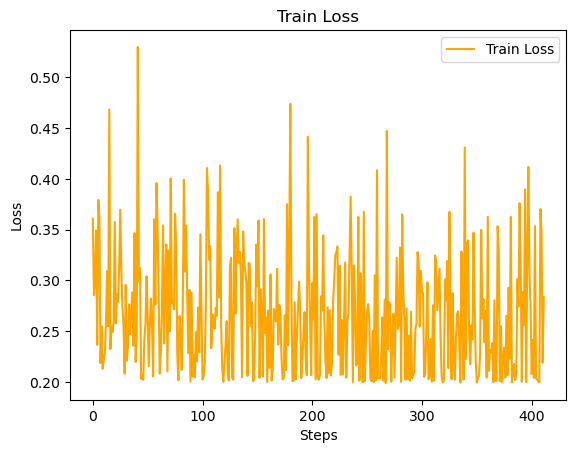

In [185]:
plot_losses(train_loss, "Train Loss", "orange", "duplicated_balanced_train_loss")

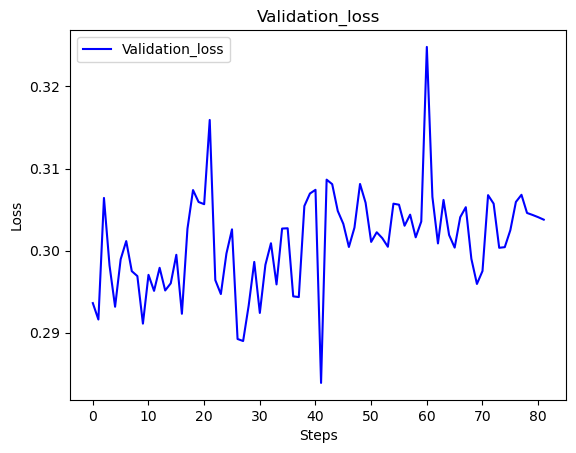

In [186]:
plot_losses(eval_loss, "Validation_loss", "blue", "duplicated_balanced_val_loss")

In [187]:
len(train_loss)

412

#### epoch loss behaviour

In [188]:
def avg_loss(loss, start, end, step):
    loss = np.array(train_loss)
    losses = []
    prev_i = 0
    for i in range(start, end, step):
        summation = np.sum(loss[prev_i:i])
        prev_i = i
        summation/=100
        losses.append(summation)
    return losses
averaged_train_loss = avg_loss(train_loss, 100, 800, 100)

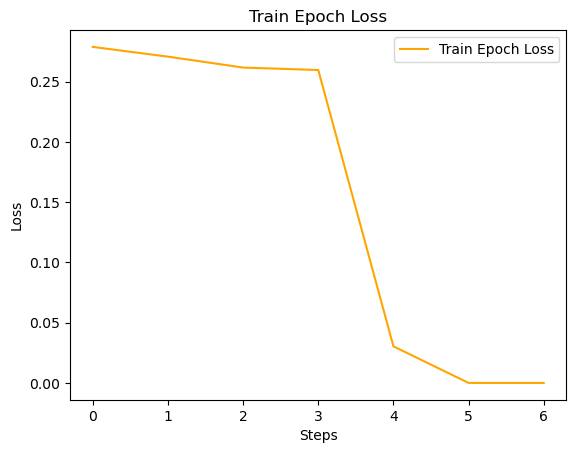

In [189]:

plot_losses(averaged_train_loss, "Train Epoch Loss", "orange", "duplicated_balanced_train_loss_epochs")

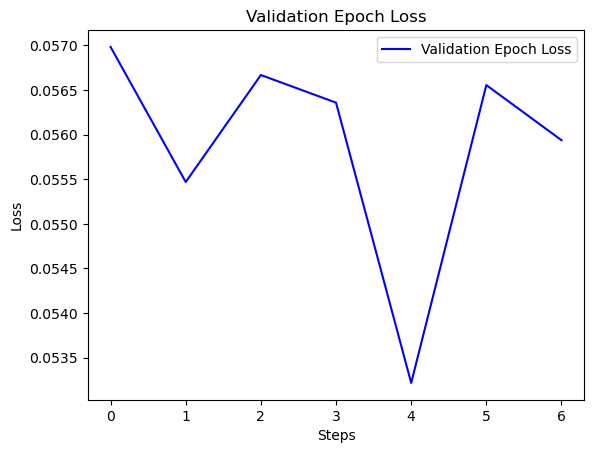

In [190]:
averaged_val_loss = avg_loss(eval_loss, 20, 160, 20)
plot_losses(averaged_val_loss, "Validation Epoch Loss", "blue", "duplicated_balanced_val_loss_epochs")

## Perfomance Matrics

In [191]:
print("Train set:")
check_data_distribution(train)

Train set:
Label distribution:
Label 0: 1498 (50.47%)
Label 1: 1470 (49.53%)


In [192]:
len(test_set)

206

In [193]:
true_labels  =  get_true_labels(test_set)
predicted_labels = get_predicted_labes(test_set)

Step 4120, Loss: 0.1998


Step 4120, Loss: 0.1986
Step 4120, Loss: 0.1989
Step 4120, Loss: 0.7055
Step 4120, Loss: 0.2019
Step 4120, Loss: 0.1999
Step 4120, Loss: 0.2944
Step 4120, Loss: 0.2578
Step 4120, Loss: 0.1987
Step 4120, Loss: 0.7700
Step 4120, Loss: 0.1989
Step 4120, Loss: 0.1996
Step 4120, Loss: 0.1989
Step 4120, Loss: 0.6268
Step 4120, Loss: 0.1988
Step 4120, Loss: 0.2009
Step 4120, Loss: 0.1986
Step 4120, Loss: 0.1989
Step 4120, Loss: 0.1991
Step 4120, Loss: 0.3439
Step 4120, Loss: 0.1991
Step 4120, Loss: 0.2317
Step 4120, Loss: 0.1990
Step 4120, Loss: 0.2001
Step 4120, Loss: 0.1990
Step 4120, Loss: 0.9142
Step 4120, Loss: 0.2001
Step 4120, Loss: 0.2434
Step 4120, Loss: 0.1988
Step 4120, Loss: 0.5531
Step 4120, Loss: 0.1990
Step 4120, Loss: 0.2005
Step 4120, Loss: 0.1995
Step 4120, Loss: 0.7718
Step 4120, Loss: 0.1992
Step 4120, Loss: 0.2137
Step 4120, Loss: 0.1988
Step 4120, Loss: 0.1989
Step 4120, Loss: 0.2070
Step 4120, Loss: 0.1991
Step 4120, Loss: 0.4010
Step 4120, Loss: 0.3099
Step 4120, Loss:

In [194]:
true_labels

[0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0]

In [195]:
print(classification_report(true_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       187
           1       0.70      0.84      0.76        19

    accuracy                           0.95       206
   macro avg       0.84      0.90      0.87       206
weighted avg       0.96      0.95      0.95       206



In [198]:
analyze_and_highlight_all(lora_model, tokenizer, test_set)


=== Article 1/206 ===

Analyzing text: <s> KUTHELE izithelo ezinhle ukubambisana kwezinhlaka ezahlukene zezomthetho i-Asset Forfeiture Unit...
True label: 0
Predicted label: 0

Top 5 most influential tokens:
Token: phakathi        Importance: 0.00258
Token: mthetho         Importance: 0.00255
Token: mthetho         Importance: 0.00235
Token: mthetho         Importance: 0.00196
Token: puma            Importance: 0.00141

Text with highlighting:
<s> KUTHELE izithelo ezinhle ukubambisana kwezinhlaka ezahlukene **zezomthetho** i-Asset Forfeiture Unit (AFU), uphiko lukazwelonke lwezokushushisa kanjalo nophiko oluphenya amacala ayisipesheli noKlebe kushaqwa imphahla yezigidi ezingu-R52.6 million ezikhulwini ezingu-22 zoMnyango wezemiSebenzi **yoMphakathi** **eMpumalanga,** nakumabhizinisi aphakela lo mnyango ngemisebenzi.Ukushaqwa kwale mpahla kuhambisana **nomthetho** wesiGaba 26 **womthetho** Wokuvimbela Ubugebengu Obuhleliwe, 121 ka-1998. Lokhu kumayelana nophenyo lweSIU ngezinkontileka 

Saving all visualizations to: ./duplicates/health/20241023_234854
Saved attention plot to: ./duplicates/health/20241023_234854/20241023_234854/attention_layer_-1.png


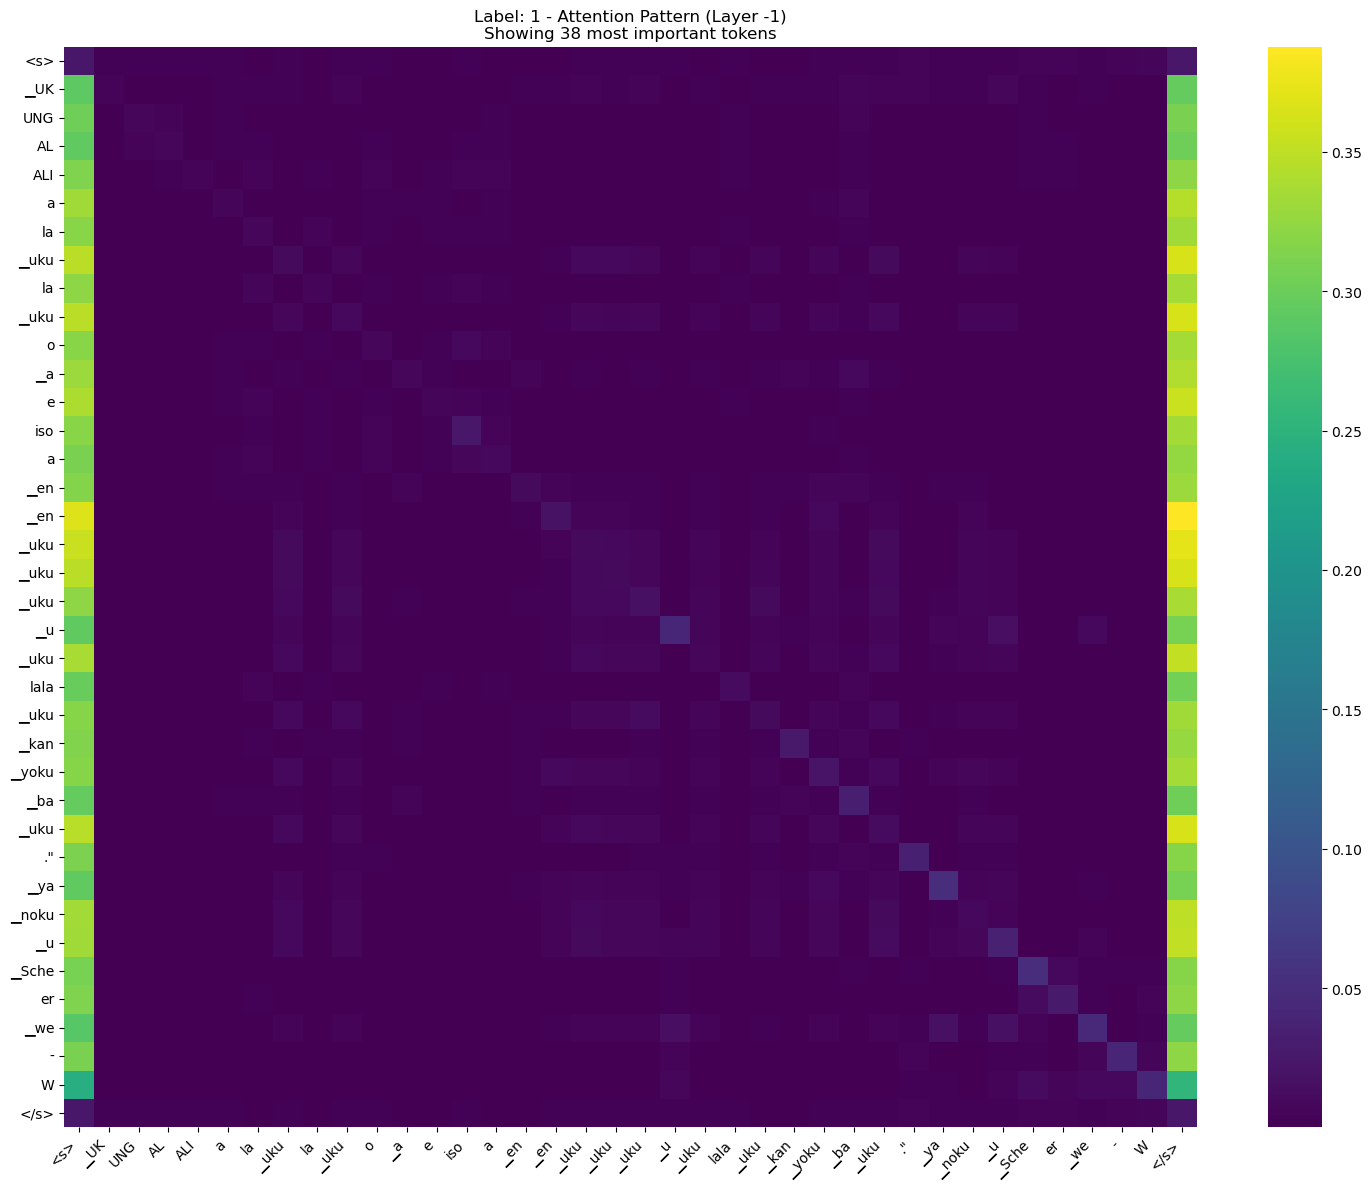

RuntimeError: can't retain_grad on Tensor that has requires_grad=False

In [210]:
sample = test_set[138]
save_dir = "./duplicates/health/"
analyze_single_sample(model, tokenizer, sample, max_tokens=30, save_dir=save_dir)

Saving all visualizations to: ./duplicates/20241023_234807
Saved attention plot to: ./duplicates/20241023_234807/20241023_234807/attention_layer_-1.png


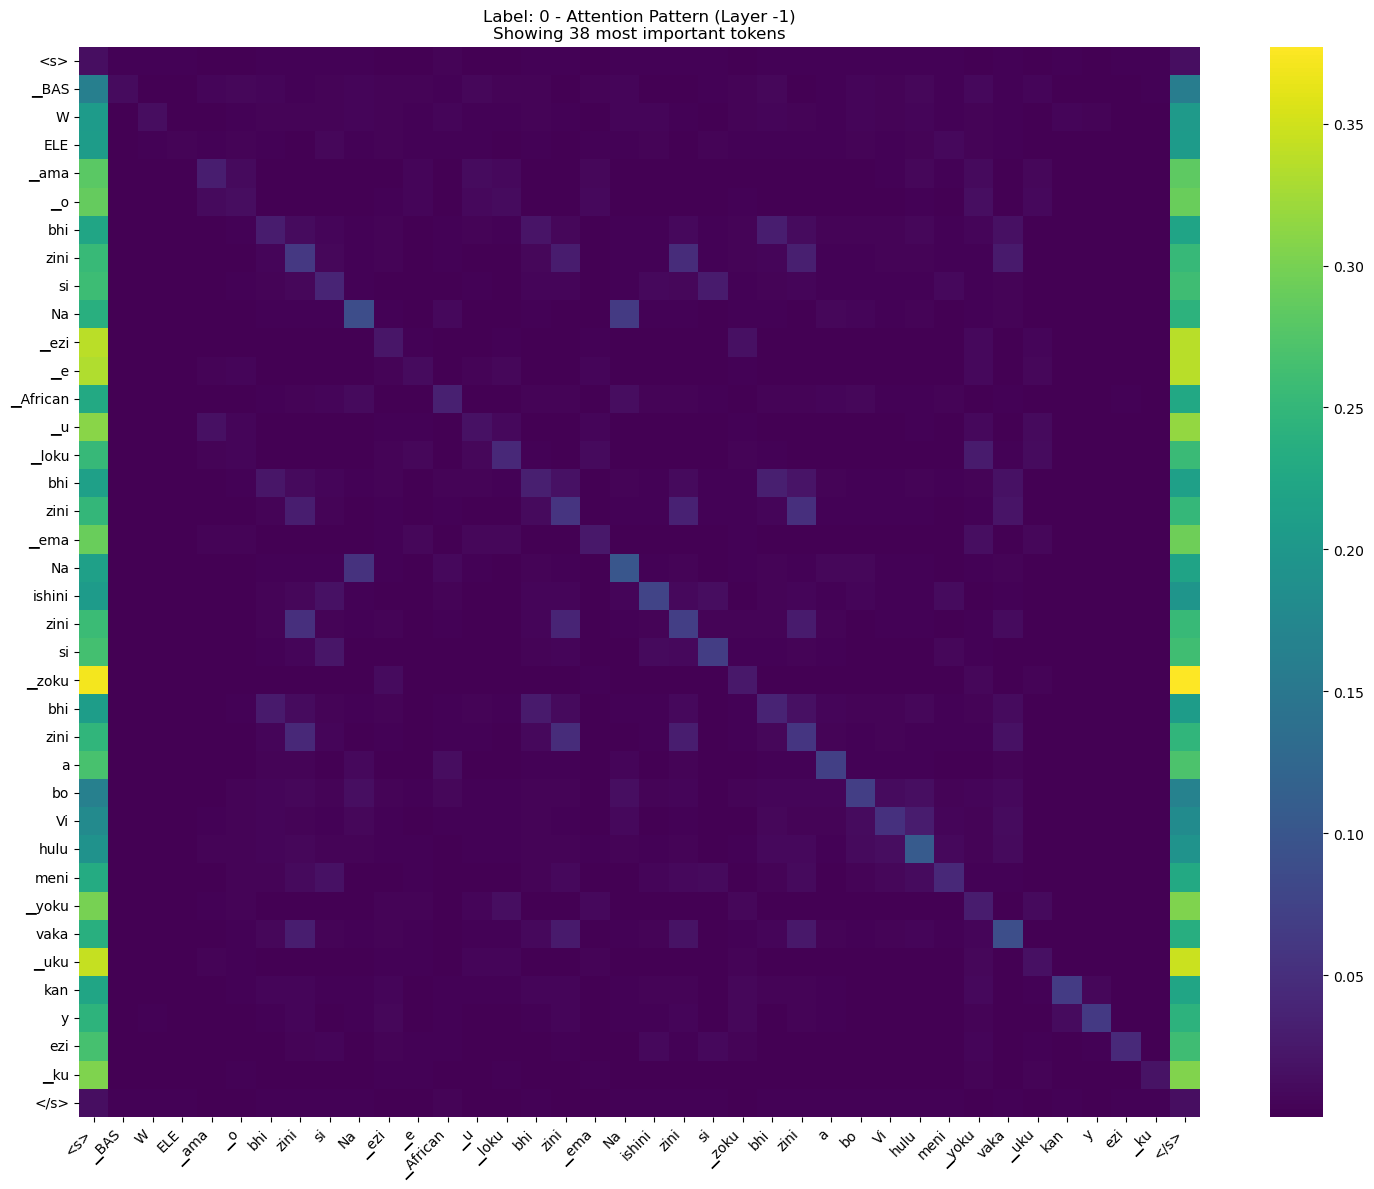

RuntimeError: can't retain_grad on Tensor that has requires_grad=False

In [208]:
sample = test_set[100]
save_dir = "./duplicates/"
analyze_single_sample(model, tokenizer, sample, max_tokens=30, save_dir=save_dir)

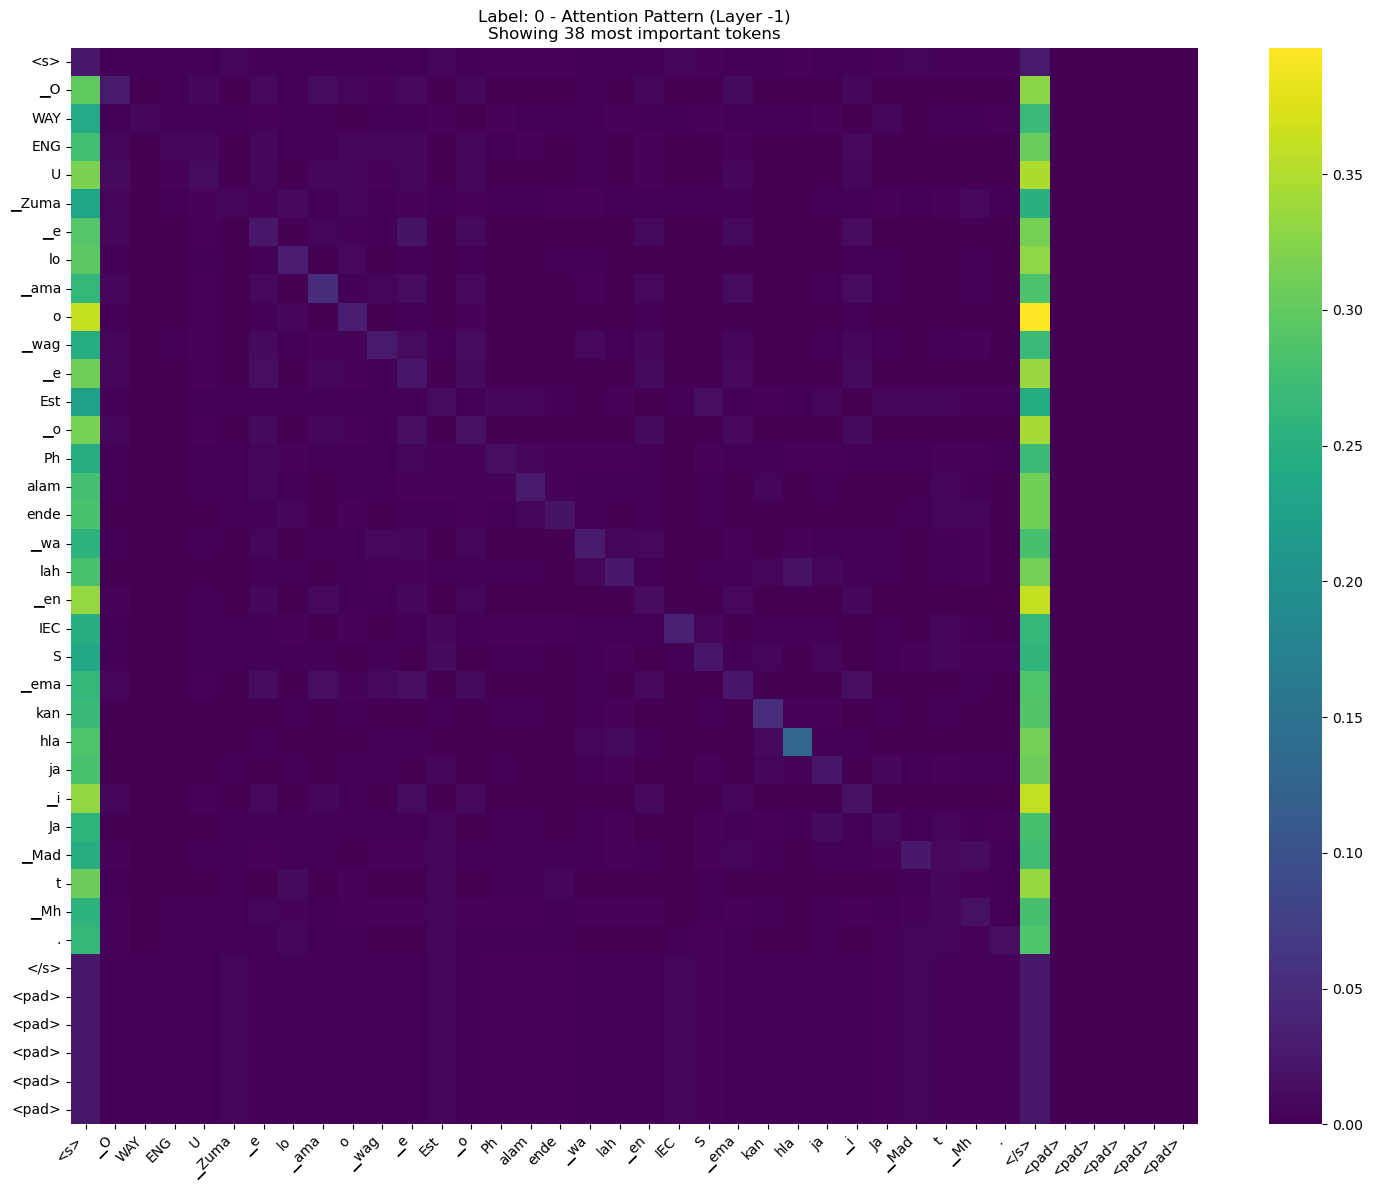

RuntimeError: can't retain_grad on Tensor that has requires_grad=False

In [205]:
sample = test_set[8]
analyze_single_sample(model, tokenizer, sample, max_tokens=30)

# fine tuning further on Domain specific data

In [343]:
with open(HEALTH_DATA_PATH, "r", encoding = "utf-8") as file:
    health_data = json.load(file)
#health_data, domain_specific_articles = separate_sugar_diabetes(health_data)

In [344]:
CANCER_DATA_PATH = "./data/addtional_cancer_info.json"
with open(CANCER_DATA_PATH, "r", encoding = "utf-8") as file:
    cancer_data = json.load(file)

In [345]:
len(cancer_data)

18

In [346]:
domain_specific_articles.extend(cancer_data)

In [347]:
domain_specific_articles = cancer_data

In [348]:
len(domain_specific_articles)

18

In [349]:
len(health_data)

187

In [350]:
# since we are comparing general health and domain or disease specific health we convert general_health to label 0
health_data = label_data(health_data, 0)

In [351]:
health_data[0]

{'content': 'UKUBA nomuzwa wokuphila kahle, ukuthula nokukhululeka emoyeni, ngezinye zezinto eseziseqhulwini lezivakashi uma zihlela amaholidi nezindawo ezizozihambela.Yikho lokhu okwenza ukuthi sande isitayela sokuthi izivakashi uma zibheka izindawo ezizovakashela kuzo, ziqikelele ukuthi zinaso iSpa noma sisondelene yini naleyo ndawo.Izindawo eziningi zokuvakasha sezidlisa ngazo izindawo zokubhucunga nokwelapha umzimba.Sikuhlanganisele uhlu lwezindawo ezinhlanu ezineSpa esihamba phambili, okumele uhlele ukuzivakashela maduze.1. Brahman Hills Spa and Healing EarthSiyiklelise eqhulwini ngenhloso le ndawo njengoba nozokuthola kuyo kusezingeni eliphezulu.Uphuma uwuzwa umehluko hhayi emzimbeni kuphela kepha nasemoyeni uma uqeda ukubhucungwa nezinye izinto ezenziwa kulesi Spa njengeFacial, Yoga, iBody Detox neBody Polish.Kulesi Spa kunanechibi elinamanzi afudumele anezithako ezenza umzimba unethezeke. Ukuba sendaweni enokuthula nakho kukodwa kukunika umuzwa opholile.Lesi Spa singaphakathi e

In [352]:
domain_specific_articles = label_data(domain_specific_articles, 1)
domain_specific_articles[0]

{'content': 'UCONCHITA wayengenalutho olubonakala lungambeka engozini yokuba nomdlavuza.a Wayeneminyaka engu-40, ewumqemane futhi kwakungenamuntu emkhayeni wakubo owayeke waba nomdlavuza. Ukuhlolelwa umdlavuza ayevame ukukwenza kwakungabonisanga lutho olungajwayelekile. Kodwa ngolunye usuku lapho ehlola amabele akhe njengoba egeza, wezwa kuneguludla. Kwatholakala ukuthi umdlavuza. UConchita nomyeni wakhe babehleli bekhungathekile njengoba udokotela ebachazela izindlela zokwelapha abangakhetha kuzo.',
 'label': 1}

In [353]:
len(domain_specific_articles)

18

In [354]:
# combining the data
train_data = combine_data(health_data, domain_specific_articles)

In [322]:
len(train_data)

205

In [365]:
train, validation, test = split_data(train_data,duplicate=True, test_size = 0.4, test_size_2 = 0.6)
#train, validation, test = split_data(train_data, duplicate=True)

109
duplicating for 6 times


In [366]:
print("Train set:")
check_data_distribution(train)

Train set:
Label distribution:
Label 0: 109 (52.66%)
Label 1: 98 (47.34%)


In [367]:
print("Validation set")
check_data_distribution(validation)

Validation set
Label distribution:
Label 0: 30 (93.75%)
Label 1: 2 (6.25%)


In [368]:
print("Test set:")
check_data_distribution(test)

Test set:
Label distribution:
Label 0: 48 (96.00%)
Label 1: 2 (4.00%)


In [369]:
train_set, validation_set, test_set = tokenize(tokenizer)

In [370]:
print(len(train_set), len(validation_set), len(test_set))

164 20 21


In [329]:
train_set[0]

{'input_ids': tensor([     0, 117671,   9092,  24592,    841,   8356,    286,    927,    634,
            365,    228,  41225,   3647,    839,  21528,  15608,   7078,  62244,
          13923,   7316,  39001,  45793,     17,  10625,   5518,   8363, 214598,
             11,     17,  10770,  63065,   1363,   3288, 178949,   5431,    282,
          45670,  28078,   2527,  10625,   5518,      9,  12233,   1052,   8647,
            237,   1255,  29959,    596,     75,   1052,   4283,    198,   8654,
            228,   1052, 109189,      5,    670,  10521, 137362,  30930,  27633,
           2628,   1240,  85611,   1212,  16252,  37604, 105043,    157,    108,
          10770,  63065,   1363,  63871,  11180,    866,   7154,     18,    108,
              9,  23135, 128405,      5,  15766,    497,   2179,  13920,    642,
          10770,  63065,   1363,  63871,      4,     75,    594,     19,   3326,
          21217,   7568,  78468,  80469,  49713,     75,  46873, 195116,   2527,
              9

In [330]:
#training the model



In [344]:
from transformers import XLMRobertaForSequenceClassification
from peft import LoraConfig, PeftModel, PeftConfig, get_peft_model

# LoRa configuration for your model
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
    target_modules=["query", "key", "value"]
)

# Load the base XLM-RoBERTa model
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)

# Apply the LoRa configuration
lora_model = get_peft_model(model, lora_config)

# Load the adapter weights from the checkpoint folder
checkpoint_folder = "./results/checkpoint-8160/"
lora_model = PeftModel.from_pretrained(lora_model, checkpoint_folder)

# Now you can proceed with training or evaluation
trainable_params_after = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
total_params_after = sum(p.numel() for p in lora_model.parameters())
print(f"Trainable params after loading LoRa weights: {trainable_params_after:,}")
print(f"Total params after loading LoRa weights: {total_params_after:,}")


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params after loading LoRa weights: 592,130
Total params after loading LoRa weights: 284,166,916


In [371]:
"""training_args = TrainingArguments(
    output_dir="./second_finetune/",                   # Output directory
    evaluation_strategy="epoch",              # Evaluate every epoch
    save_strategy="epoch",                    # Save model every epoch
    learning_rate=1e-5,                       # Learning rate
    per_device_train_batch_size=8,            # Batch size for training
    per_device_eval_batch_size=8,             # Batch size for evaluation
    num_train_epochs=10,                       # Number of epochs
    weight_decay=0.01,                        # Strength of weight decay
    logging_dir="./logs",                     # Directory for storing logs
    logging_steps=10,                         # Log every 10 steps
)

# Initialize the Trainer
trainer = Trainer(
    model=lora_model,                         # Your LoRa model
    args=training_args,                       # Training arguments
    train_dataset=test_set,              # Training dataset
    eval_dataset=validation_set,                # Evaluation dataset
    compute_metrics=compute_metrics           # Optional: Define your metrics function
)

# Start training
trainer.train()"""
trainer = CustomTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics
)

trainer.train()

Step 0, Loss: 0.6086


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.236800,0.213048,1.000000,1.000000,1.000000,1.000000
100,0.208000,0.211059,1.000000,1.000000,1.000000,1.000000
150,0.207300,0.207772,1.000000,1.000000,1.000000,1.000000
200,0.205600,0.202717,1.000000,1.000000,1.000000,1.000000
250,0.229700,0.206157,1.000000,1.000000,1.000000,1.000000
300,0.207200,0.208296,1.000000,1.000000,1.000000,1.000000
350,0.204700,0.207828,1.000000,1.000000,1.000000,1.000000
400,0.204400,0.205223,1.000000,1.000000,1.000000,1.000000


Step 10, Loss: 0.2010
Step 20, Loss: 0.2006
Step 30, Loss: 0.3218
Step 40, Loss: 0.2020
Step 50, Loss: 0.2136
Step 50, Loss: 0.2052
Step 50, Loss: 0.2151
Step 50, Loss: 0.2305
Step 50, Loss: 0.2008
Step 50, Loss: 0.2006


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 60, Loss: 0.2022
Step 70, Loss: 0.3823
Step 80, Loss: 0.1997
Step 90, Loss: 0.2044
Step 100, Loss: 0.2208
Step 100, Loss: 0.2071
Step 100, Loss: 0.2206
Step 100, Loss: 0.2056
Step 100, Loss: 0.2011
Step 100, Loss: 0.2773


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 110, Loss: 0.2039
Step 120, Loss: 0.2008
Step 130, Loss: 0.2047
Step 140, Loss: 0.2058
Step 150, Loss: 0.2299
Step 150, Loss: 0.2007
Step 150, Loss: 0.2057
Step 150, Loss: 0.2017
Step 150, Loss: 0.2009
Step 150, Loss: 0.2043


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 160, Loss: 0.2046
Step 170, Loss: 0.1998
Step 180, Loss: 0.2036
Step 190, Loss: 0.2002
Step 200, Loss: 0.2093
Step 200, Loss: 0.1989
Step 200, Loss: 0.2039
Step 200, Loss: 0.2009
Step 200, Loss: 0.2005
Step 200, Loss: 0.2019


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 210, Loss: 0.2000
Step 220, Loss: 0.2066
Step 230, Loss: 0.2019
Step 240, Loss: 0.1996
Step 250, Loss: 0.2202
Step 250, Loss: 0.1995
Step 250, Loss: 0.2088
Step 250, Loss: 0.2021
Step 250, Loss: 0.2002
Step 250, Loss: 0.2021


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 260, Loss: 0.2045
Step 270, Loss: 0.2049
Step 280, Loss: 0.4614
Step 290, Loss: 0.1996
Step 300, Loss: 0.2295
Step 300, Loss: 0.2000
Step 300, Loss: 0.2102
Step 300, Loss: 0.2005
Step 300, Loss: 0.2012
Step 300, Loss: 0.2037


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 310, Loss: 0.2003
Step 320, Loss: 0.2014
Step 330, Loss: 0.4539
Step 340, Loss: 0.1991
Step 350, Loss: 0.2276
Step 350, Loss: 0.1996
Step 350, Loss: 0.2096
Step 350, Loss: 0.2015
Step 350, Loss: 0.2009
Step 350, Loss: 0.2019


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 360, Loss: 0.3736
Step 370, Loss: 0.4365
Step 380, Loss: 0.2073
Step 390, Loss: 0.2024
Step 400, Loss: 0.2159
Step 400, Loss: 0.1994
Step 400, Loss: 0.2084
Step 400, Loss: 0.2021
Step 400, Loss: 0.2002
Step 400, Loss: 0.2025


/home/mpho/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


TrainOutput(global_step=410, training_loss=0.22082648219131842, metrics={'train_runtime': 49.9447, 'train_samples_per_second': 32.836, 'train_steps_per_second': 8.209, 'total_flos': 462343896268800.0, 'train_loss': 0.22082648219131842, 'epoch': 10.0})

In [372]:
true_labels  =  get_true_labels(test_set)
predicted_labels = get_predicted_labes(test_set)

Step 410, Loss: 0.2070


Step 410, Loss: 0.1997
Step 410, Loss: 0.2101
Step 410, Loss: 0.2335
Step 410, Loss: 0.2026
Step 410, Loss: 0.2530


In [373]:
true_labels

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [374]:
predicted_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [375]:
len(predicted_labels)

21

In [376]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00         2

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



In [334]:
train_loss, eval_loss = get_losess(trainer)

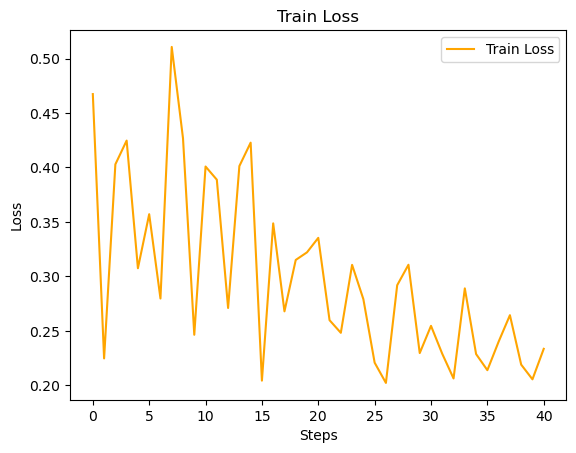

In [335]:
plot_losses(train_loss, "Train Loss", "orange", "final_fine_tune_train_loss")

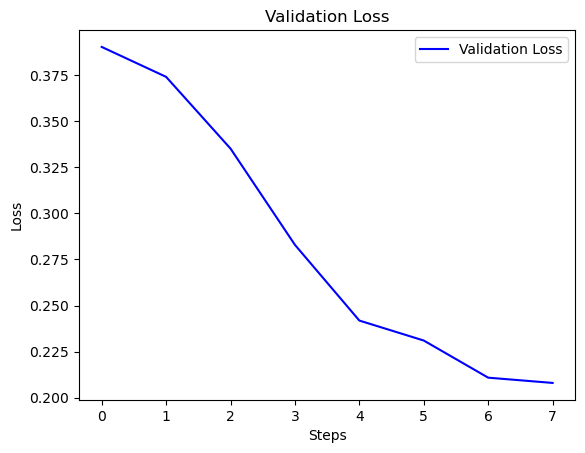

In [336]:
plot_losses(eval_loss, "Validation Loss", "blue", "final_finetune_val_loss")

In [377]:
analyze_and_highlight_all(lora_model, tokenizer, test_set)


=== Article 1/21 ===

Analyzing text: <s> UmbuzoNGINGOWESIFAZANE, ngihlala nengane yami enonyaka. Asisathandani nobaba wayo ngoba selokhu ...
True label: 0
Predicted label: 0

Top 5 most influential tokens:
Token: <s>             Importance: 0.00909
Token:                 Importance: 0.00687
Token:                 Importance: 0.00603
Token: <s>             Importance: 0.00524
Token:                 Importance: 0.00460

Text with highlighting:
**<s>** **UmbuzoNGINGOWESIFAZANE,** **ngihlala** **nengane** **yami** **enonyaka.** **Asisathandani** **nobaba** **wayo** **ngoba** **selokhu** **kwabakhona** **ingane** **izinto** **aziphindanga** **zahamba** **kahle** **phakathi** **kwethu.** **Sasixabana** **njalo,** **ngathola** **ukuthi** **useqonyiwe,** **sahlukana.** **Yize** **ngangisamthanda** **kodwa** **ngasamukela** **isimo.Inkinga** **wukuthi** **uyafika** **ezobona** **ingane** **futhi** **ayilethele** **nezinto,** **yilapho** **uthando** **luvele** **luvuke** **kimi** **lume** **ng

In [400]:
additional_test = "./data/additional_test.json"
with open(additional_test, "r", encoding = "utf-8") as file:
    add_cancer_test =  json.load(file)

In [412]:
additional_cancer_test = label_data(add_cancer_test, 1)

In [414]:
additional_cancer_test

[{'content': 'Izimpawu zokwexwayisa zomdlavuza (kwabadala) Izimpawu zokwexwayisa zomdlavuza (ezinganeni) Inguquko kwizinsumpa noma umkhangu Isilonda esingapholi, ujungujungu oluphuma kwisitho sangasese olungajwayelekile, ukopha ngokwedlulele Ukopha ngokweqile Ukuqina noma ukwakheka kwesigaxa Ukungagayeki kahle kokudla noma ukugwinya kanzima Ukukhwehlela okungapheli noma ukuhohoza uma uphefumula Inguquko ebonakalayo emathunjini noma ekuyeni endlini yangasese Thatha Izinqumo Ezinobuhlakan',
  'label': 1},
 {'content': 'Umdlavuza (Cancer) uyisifo esibulalayo esenzeka lapho amangqamuzana omzimba eqala ukukhula ngokungajwayelekile futhi alawulwe kabi. Lokhu kukhula kungaholela ekwakhekeni kwesimila esingaba sibi noma esingaba buthakathaka. Umdlavuza ungathinta noma yiliphi ingxenye yomzimba, njengamabele, umphimbo, amaphaphu, noma isibindi.',
  'label': 1},
 {'content': 'Izimpawu zomdlavuza ziyahlukahluka kuye ngohlobo lwesifo, kodwa kuvame ukubandakanya izinhlungu ezingachazeki, ukwehla kw

In [415]:
additional_test_data_tokenized = CustomDataset(add_cancer_test, tokenizer)

In [416]:
additional_test_data_tokenized[0]

{'input_ids': tensor([     0,   3519,  75750,  16612,   1602,  40935,    425,   7514,   4542,
             97,    306,  10627,   1783,    596,     15,  10521,  29261,    143,
             16,   3519,  75750,  16612,   1602,  40935,    425,   7514,   4542,
             97,    306,  10627,   1783,    596,     15,   1255,  43316,   4300,
             16,  11614,  30871,  11159,  22951,   7299,  71836,     11,  47715,
            286,  11395,  10393,     87, 106716,   1127,    198,    214,   2631,
          69810,      4, 142765,  12683,  10393,  37663,  62397,  22951,   6084,
            497,   6079,    162,   7717,  18865,  74271,   7514,  43472,   1340,
              4, 100722,  14612, 201073,  46814,  38914,    345,    265,  14612,
         201073,  84150,     13,  36795,  39988,     11,  47715,     75,  10521,
          19211,    161,  16646,  13350,   3798,  36795,   7652,    208,   1033,
            301,    156,   7057,  57197,  10627,  47715,   7316,    177,   2452,
            273

In [417]:
true_labels  =  get_true_labels(additional_test_data_tokenized)
predicted_labels = get_predicted_labes(additional_test_data_tokenized)


Step 410, Loss: 0.3422


In [418]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [419]:
analyze_and_highlight_all(lora_model, tokenizer, add_test_tokenized)


=== Article 1/4 ===

Analyzing text: <s> Izimpawu zokwexwayisa zomdlavuza (kwabadala) Izimpawu zokwexwayisa zomdlavuza (ezinganeni) Inguq...
True label: 1
Predicted label: 0

Top 5 most influential tokens:
Token: </s>            Importance: 0.01650
Token: <s>             Importance: 0.01168
Token: elek            Importance: 0.00685
Token: hle             Importance: 0.00511
Token: zo              Importance: 0.00504

Text with highlighting:
**<s>** Izimpawu **zokwexwayisa** **zomdlavuza** (kwabadala) Izimpawu **zokwexwayisa** **zomdlavuza** (ezinganeni) Inguquko kwizinsumpa noma umkhangu Isilonda esingapholi, ujungujungu oluphuma kwisitho sangasese **olungajwayelekile,** ukopha ngokwedlulele Ukopha ngokweqile Ukuqina noma ukwakheka kwesigaxa Ukungagayeki **kahle** kokudla noma ukugwinya kanzima **Ukukhwehlela** okungapheli noma ukuhohoza uma uphefumula Inguquko ebonakalayo emathunjini noma ekuyeni endlini yangasese Thatha Izinqumo **Ezinobuhlakan</s><pad><pad><pad><pad><pad><pad><pad

## BASELINE MODEL

In [ ]:
target_modules = [
    "query",
    "key",
    "value",
]

lora_config = LoraConfig(
    r=100,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
    target_modules=target_modules,
    modules_to_save=None
)


model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)


trainable_params_before = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params_before = sum(p.numel() for p in model.parameters())
print(f"Trainable params before LoRA: {trainable_params_before:,}")
print(f"Total params before LoRA: {total_params_before:,}")


for param in model.parameters():
    param.requires_grad = False


lora_model = get_peft_model(model, lora_config)


trainable_params_after = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
total_params_after = sum(p.numel() for p in lora_model.parameters())
print(f"\nTrainable params after LoRA: {trainable_params_after:,}")
print(f"Total params after LoRA: {total_params_after:,}")


print("\nTrainable layers:")
for name, param in lora_model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel():,} parameters")

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.epoch_loss = 0  # Initialize variable to keep track of epoch loss

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Cross entropy with label smoothing
        loss = torch.nn.functional.cross_entropy(
            logits.view(-1, model.config.num_labels),
            labels.view(-1),
            label_smoothing=0.1
        )
        
        self.epoch_loss += loss.item()  # Accumulate loss for the epoch
        
        if self.state.global_step % 10 == 0:  # Log every 10 steps
            print(f"Step {self.state.global_step}, Loss: {loss.item():.4f}")

        return (loss, outputs) if return_outputs else loss

    def on_epoch_end(self):
        # Calculate average epoch loss
        average_epoch_loss = self.epoch_loss / self.state.epoch
        print(f"Epoch {self.state.epoch}, Average Loss: {average_epoch_loss:.4f}")
        self.epoch_loss = 0  # Reset epoch loss for the next epoch


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",       # Evaluate more frequently
    eval_steps=50,                     # Evaluate every 50 steps
    learning_rate=2e-5,               # Lower learning rate
    per_device_train_batch_size=4,    # Smaller batch size
    per_device_eval_batch_size=4,
    logging_dir='./logs',
    logging_steps=10,
    num_train_epochs=10,
    weight_decay=0.01,                # Add weight decay
    warmup_steps=100,                 # Add warmup
    load_best_model_at_end=True,      # Load best model
    metric_for_best_model="f1",       # Use F1 score
    save_strategy="steps",            # Save checkpoints
    save_steps=50,
    fp16=True if torch.cuda.is_available() else False,  # Mixed precision training
)

# Custom trainer with loss monitoring
"""class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Cross entropy with label smoothing
        loss = torch.nn.functional.cross_entropy(
            logits.view(-1, model.config.num_labels),
            labels.view(-1),
            label_smoothing=0.1
        )
        
        if self.state.global_step % 10 == 0:  # Log every 10 steps
            print(f"Step {self.state.global_step}, Loss: {loss.item():.4f}")
        
        return (loss, outputs) if return_outputs else loss"""

trainer = CustomTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics
)

# Print initial predictions before training
def check_predictions(model, dataset, num_samples=3):
    model.eval()
    for i in range(num_samples):
        inputs = {k: v.unsqueeze(0).to(model.device) for k, v in dataset[i].items() 
                 if k != 'labels'}
        labels = dataset[i]['labels']
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        print(f"\nSample {i+1}:")
        print(f"True label: {labels}")
        print(f"Predicted probabilities: {probs}")

"""print("Initial predictions:")
check_predictions(model, train_set)"""

# Train the model
trainer.train()

# Print final predictions
"""print("\nFinal predictions:")
check_predictions(model, train_set)

# Evaluate on test set
test_results = trainer.evaluate(test_set)
print("\nTest Results:", test_results)"""



